In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

In [3]:
def get_sim_mat(Nf, Ra, Rb, sum_lbda=0.01):

    sin_t = np.sin(np.pi/Nf)
    sin_2t = np.sin(2*np.pi/Nf)

    A = 0.5 * (Rb**2 - Ra**2) * sin_2t
    dAdRa = - sin_2t * Ra
    dAdRb = sin_2t * Rb
    dladRa = dlbdRb = 2*sin_t

    # variables are
    # (A - A_0), \Lambda_a, \Lambda_h
    problem_mat = np.array(
        [
            [dAdRa, dladRa, -1],
            [dAdRb, 0,       1],
            [0,     1,       1]
        ])

    b = np.array([0, 0, sum_lbda])
    return problem_mat, b

Reseting datasets values with new specs


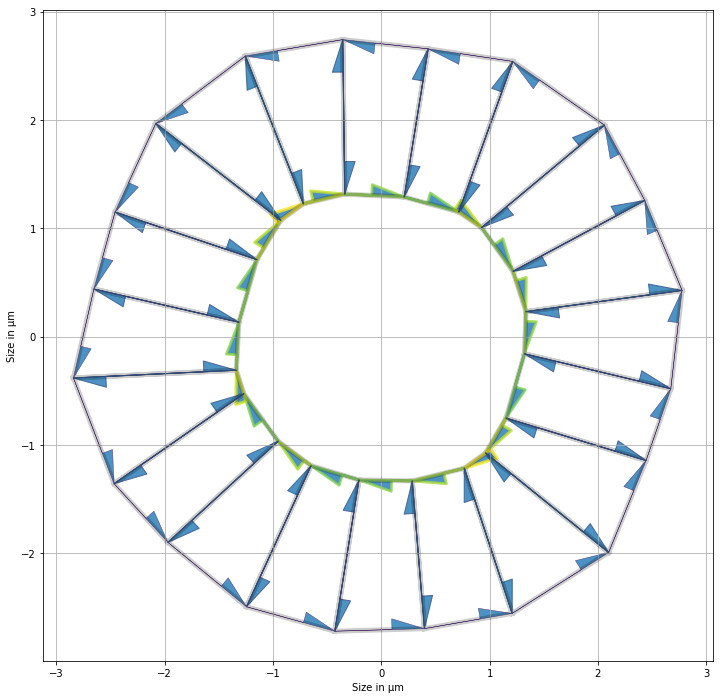

In [4]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo = create_organo(nf, r_in, r_out)

organo.edge_df.loc[organo.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo.edge_df.loc[organo.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo.edge_df.loc[organo.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo.face_df.area

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

## Const opt

In [5]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    api_vertex = organo.edge_df.loc[organo.apical_edges,
                                    ('srce', 'trgt')][organo.edge_df.face == cell]
    coord_api_vertex = organo.vert_df.loc[np.squeeze(api_vertex.values),
                                          ('x', 'y')].values
    coord_cell_center = np.squeeze(organo.face_df.loc[[cell], ('x', 'y')].values)
    #((C(1,1)-A(1,1))*(B(1,1)-A(1,1)))+((C(1,2)-A(1,2))*(B(1,2)-A(1,2)))
    pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                       coord_cell_center - coord_api_vertex[1])
    comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                     coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
    proj = coord_api_vertex[0] + pos_param * comp
    #api_vert = organo.vert_df.loc[organo.apical_verts[[cell, (cell+1)%organo.Nf]],
    #                              ('x', 'y')].values
    polar_coefs[cell] = np.linalg.norm(proj - coord_cell_center)
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.68814571, 0.68960892, 0.68880027, 0.69274873, 0.6926759 ,
       0.70580654, 0.68949272, 0.70710696, 0.71211228, 0.71385017,
       0.69106288, 0.69941376, 0.70467986, 0.71160196, 0.70308148,
       0.71293015, 0.71254563, 0.71218888, 0.69801196, 0.69944966])

In [7]:
list_of_dist = []
initial_lumen_volume = organo.settings['lumen_volume']
initial_lumen_prefered_volume = organo.settings['lumen_prefered_vol']
for cst in np.linspace(0.001, 0.25, 250):
    params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out, sum_lbda=cst))
    matrix = _coef_matrix(organo, sup_param='areas')
    constant = _right_side(organo, matrix)
    matrix = matrix[:-1]
    constant = constant[:-1]
    avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
                   (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
    for i in range(organo.Nf):
        i_cell_line = np.zeros(4*organo.Nf+1)
        index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
        index_suiv = np.squeeze(np.argwhere(organo.edge_df.face.values == (i+1)%organo.Nf))
        index[-1] = index_suiv[-2]
        i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
        matrix = np.vstack((matrix, i_cell_line))
    constant = np.concatenate((constant, avg_cste))
    mat_eq_cst, residuals = nnls(matrix, constant)
    organo_eq_cst = organo.copy()
    organo_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_eq_cst,
                                                                     mat_eq_cst[:3*organo.Nf])
    organo_eq_cst.face_df.loc[:, 'prefered_area'] = organo_eq_cst.face_df.area.values + mat_eq_cst[3*organo.Nf:
                                                                                                   4*organo.Nf]
    organo_eq_cst.settings['lumen_prefered_vol'] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
    Solver.find_energy_min(organo_eq_cst, geom, model)
    organo.settings['lumen_volume'] = initial_lumen_volume
    organo.settings['lumen_prefered_vol'] = initial_lumen_prefered_volume
    print('cst: ', cst, ' dist: ', np.sum(np.linalg.norm(_distance(organo_eq_cst, organo.copy()), axis=1)))
    list_of_dist.append(np.sum(np.linalg.norm(_distance(organo_eq_cst, organo.copy()), axis=1)))

cst:  0.001  dist:  2.815839627910881
cst:  0.002  dist:  2.6376363766897595
cst:  0.003  dist:  2.453638934102637
cst:  0.004  dist:  2.172441247534386
cst:  0.005  dist:  1.8823486348397425
cst:  0.006  dist:  0.03744515016022262
cst:  0.007  dist:  1.4355644618690762
cst:  0.008  dist:  0.057155739994247556
cst:  0.009000000000000001  dist:  0.059103593557213244
cst:  0.010000000000000002  dist:  1.0373784268953754
cst:  0.011  dist:  0.956957172037671
cst:  0.012  dist:  0.8968066975740133
cst:  0.013000000000000001  dist:  0.8447752309911569
cst:  0.014000000000000002  dist:  0.807943630703265
cst:  0.015  dist:  0.7784945119879914
cst:  0.016  dist:  0.7531601846794327
cst:  0.017  dist:  0.7307435122210194
cst:  0.018000000000000002  dist:  0.7128831726284495
cst:  0.019000000000000003  dist:  0.7003682067275074
cst:  0.02  dist:  0.7023917630002094
cst:  0.021  dist:  0.6928262515424602
cst:  0.022000000000000002  dist:  0.6859941758919081
cst:  0.023  dist:  0.6828261864667233

cst:  0.198  dist:  23.56970899837766
cst:  0.199  dist:  7.315500050962291
cst:  0.2  dist:  24.18230265084757
cst:  0.201  dist:  7.270685791915594
cst:  0.202  dist:  22.96110982380602
cst:  0.203  dist:  26.490434607422507
cst:  0.20400000000000001  dist:  26.26376268284494
cst:  0.20500000000000002  dist:  22.996147805501664
cst:  0.20600000000000002  dist:  27.46749287460684
cst:  0.20700000000000002  dist:  23.719573678489667
cst:  0.20800000000000002  dist:  22.989267656749806
cst:  0.20900000000000002  dist:  27.008843390336217
cst:  0.21  dist:  23.523696217837678
cst:  0.211  dist:  27.427131771279072
cst:  0.212  dist:  23.53436854381897
cst:  0.213  dist:  27.954351937391486
cst:  0.214  dist:  26.725653253066895
cst:  0.215  dist:  27.40550291917488
cst:  0.216  dist:  23.884060270766167
cst:  0.217  dist:  27.276966193124714
cst:  0.218  dist:  6.976948145175394
cst:  0.219  dist:  23.57479484880397
cst:  0.22  dist:  23.228401653464367
cst:  0.221  dist:  23.35845218352

In [13]:
cst = 0
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out, sum_lbda=cst))
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
matrix = matrix[:-1]
constant = constant[:-1]
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
for i in range(organo.Nf):
    i_cell_line = np.zeros(4*organo.Nf+1)
    index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
    index_suiv = np.squeeze(np.argwhere(organo.edge_df.face.values == (i+1)%organo.Nf))
    index[-1] = index_suiv[-2]
    i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo_eq_cst = organo.copy()
organo_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_eq_cst,
                                                                 mat_eq_cst[:3*organo.Nf])
organo_eq_cst.face_df.loc[:, 'prefered_area'] = organo_eq_cst.face_df.area.values + mat_eq_cst[3*organo.Nf:
                                                                                               4*organo.Nf]
organo_eq_cst.settings['lumen_prefered_vol'] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo_eq_cst, geom, model)
organo.settings['lumen_volume'] = initial_lumen_volume
organo.settings['lumen_prefered_vol'] = initial_lumen_prefered_volume
print('cst: ', cst, ' dist: ', np.sum(np.linalg.norm(_distance(organo_eq_cst, organo.copy()), axis=1)))

cst:  0  dist:  2.823749842464208


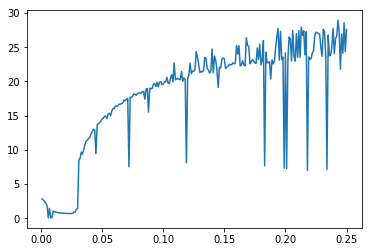

In [14]:
from matplotlib import pyplot as plt
plt.plot(np.linspace(0.001, 0.25, 250), list_of_dist)

## Half polarized

In [15]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.01,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


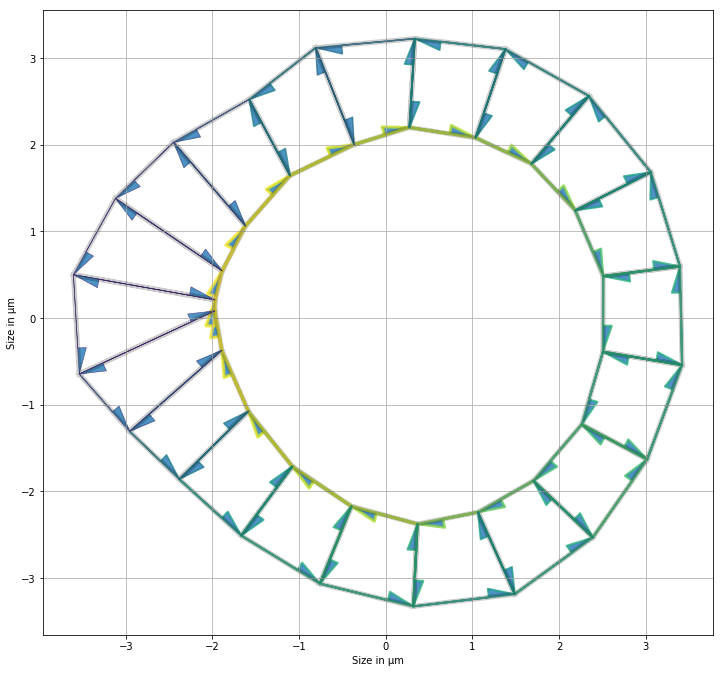

In [16]:
nf, r_in, r_out = (20, 1, 1.5)
seed = 1
organo = create_organo(nf, r_in, r_out)

organo.edge_df.loc[organo.apical_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.060, 0.065, 0.070,
    0.072, 0.074, 0.076, 0.078, 0.078,
    0.079, 0.078, 0.076, 0.074, 0.072,
    0.070, 0.068, 0.065, 0.057, 0.052
])

organo.edge_df.loc[organo.basal_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.045, 0.050,
    0.050, 0.045, 0.035, 0.020, 0.010,
    0.011, 0.015, 0.020, 0.035, 0.030,
    0.040, 0.040, 0.042, 0.045, 0.050
])

organo.edge_df.loc[organo.lateral_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051,
    0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051, 0.050
])

organo.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo.face_df.area

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

In [17]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    api_vertex = organo.edge_df.loc[organo.apical_edges,
                                    ('srce', 'trgt')][organo.edge_df.face == cell]
    coord_api_vertex = organo.vert_df.loc[np.squeeze(api_vertex.values),
                                          ('x', 'y')].values
    coord_cell_center = np.squeeze(organo.face_df.loc[[cell], ('x', 'y')].values)
    #((C(1,1)-A(1,1))*(B(1,1)-A(1,1)))+((C(1,2)-A(1,2))*(B(1,2)-A(1,2)))
    pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                       coord_cell_center - coord_api_vertex[1])
    comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                     coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
    proj = coord_api_vertex[0] + pos_param * comp
    #api_vert = organo.vert_df.loc[organo.apical_verts[[cell, (cell+1)%organo.Nf]],
    #                              ('x', 'y')].values
    polar_coefs[cell] = np.linalg.norm(proj - coord_cell_center)
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.6298519 , 0.58552087, 0.54554701, 0.5578145 , 0.57129197,
       0.57944321, 0.56423776, 0.59851501, 0.78701856, 0.81035332,
       0.76745019, 0.70391654, 0.6724686 , 0.63208301, 0.60714558,
       0.60834998, 0.59372321, 0.59204298, 0.62304487, 0.62635186])

In [20]:
list_of_dist = []
initial_lumen_volume = organo.settings['lumen_volume']
initial_lumen_prefered_volume = organo.settings['lumen_prefered_vol']
for cst in np.linspace(0.001, 0.5, 500):
    params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out, sum_lbda=cst))
    matrix = _coef_matrix(organo, sup_param='areas')
    constant = _right_side(organo, matrix)
    matrix = matrix[:-1]
    constant = constant[:-1]
    avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
                   (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
    for i in range(organo.Nf):
        i_cell_line = np.zeros(4*organo.Nf+1)
        index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
        index_suiv = np.squeeze(np.argwhere(organo.edge_df.face.values == (i+1)%organo.Nf))
        index[-1] = index_suiv[-2]
        i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
        matrix = np.vstack((matrix, i_cell_line))
    constant = np.concatenate((constant, avg_cste))
    mat_eq_cst, residuals = nnls(matrix, constant)
    organo_eq_cst = organo.copy()
    organo_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_eq_cst,
                                                                     mat_eq_cst[:3*organo.Nf])
    organo_eq_cst.face_df.loc[:, 'prefered_area'] = organo_eq_cst.face_df.area.values + mat_eq_cst[3*organo.Nf:
                                                                                                   4*organo.Nf]
    organo_eq_cst.settings['lumen_prefered_vol'] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
    Solver.find_energy_min(organo_eq_cst, geom, model)
    organo.settings['lumen_volume'] = initial_lumen_volume
    organo.settings['lumen_prefered_vol'] = initial_lumen_prefered_volume
    print('cst: ', cst, ' dist: ', np.sum(np.linalg.norm(_distance(organo_eq_cst, organo.copy()), axis=1)))
    list_of_dist.append(np.sum(np.linalg.norm(_distance(organo_eq_cst, organo.copy()), axis=1)))

from matplotlib import pyplot as plt
plt.plot(np.linspace(0.001, 0.25, 250), list_of_dist)

cst:  0.001  dist:  11.081179520711169
cst:  0.002  dist:  11.02406747928504
cst:  0.003  dist:  10.905586429355555
cst:  0.004  dist:  10.756353555606761
cst:  0.005  dist:  10.842785203514431
cst:  0.006  dist:  10.730817266733634
cst:  0.007  dist:  10.673104420863169
cst:  0.008  dist:  10.52629268520143
cst:  0.009000000000000001  dist:  10.431652339279143
cst:  0.010000000000000002  dist:  10.332644444861442
cst:  0.011  dist:  10.310676408128996
cst:  0.012  dist:  10.16019182141746
cst:  0.013000000000000001  dist:  10.14852020547964
cst:  0.014000000000000002  dist:  9.991502971134667
cst:  0.015  dist:  9.973019083665083
cst:  0.016  dist:  9.821243309551322
cst:  0.017  dist:  9.760185270070462
cst:  0.018000000000000002  dist:  9.72959058311184
cst:  0.019000000000000003  dist:  9.65872183544652
cst:  0.02  dist:  9.785486672513615
cst:  0.021  dist:  9.591040967100394
cst:  0.022000000000000002  dist:  9.448708497552087
cst:  0.023  dist:  9.437851565647808
cst:  0.024  di

cst:  0.201  dist:  4.488177911956694
cst:  0.202  dist:  4.52239242456298
cst:  0.203  dist:  4.47986385623896
cst:  0.20400000000000001  dist:  4.477451749420612
cst:  0.20500000000000002  dist:  4.4753339510156795
cst:  0.20600000000000002  dist:  4.473519789448485
cst:  0.20700000000000002  dist:  4.472036781682022
cst:  0.20800000000000002  dist:  4.4709437800745935
cst:  0.20900000000000002  dist:  4.47037619694141
cst:  0.21  dist:  4.470652536675036
cst:  0.211  dist:  4.462810671374388
cst:  0.212  dist:  4.4660444431857425
cst:  0.213  dist:  4.4693199613322605
cst:  0.214  dist:  4.471923173696095
cst:  0.215  dist:  4.473150309009431
cst:  0.216  dist:  4.473138093096149
cst:  0.217  dist:  4.472958118831888
cst:  0.218  dist:  4.473486468074675
cst:  0.219  dist:  4.474806476477826
cst:  0.22  dist:  4.4762670830800655
cst:  0.221  dist:  4.477442775494412
cst:  0.222  dist:  4.526610199023123
cst:  0.223  dist:  4.485578596874192
cst:  0.224  dist:  4.559281189379979
cst:

cst:  0.40700000000000003  dist:  11.281211746307736
cst:  0.40800000000000003  dist:  11.284497711954115
cst:  0.40900000000000003  dist:  11.252934540907045
cst:  0.41000000000000003  dist:  11.557745725140563
cst:  0.41100000000000003  dist:  11.301557072077108
cst:  0.41200000000000003  dist:  11.623192101207419
cst:  0.41300000000000003  dist:  11.699806893078492
cst:  0.41400000000000003  dist:  11.769551622286247
cst:  0.41500000000000004  dist:  11.821254741319109
cst:  0.41600000000000004  dist:  11.805585801697744
cst:  0.41700000000000004  dist:  12.033373870912225
cst:  0.418  dist:  12.127631276699184
cst:  0.419  dist:  11.942432110267728
cst:  0.42  dist:  11.986819648819106
cst:  0.421  dist:  12.11237715841285
cst:  0.422  dist:  12.202818664474103
cst:  0.423  dist:  12.22630194150667
cst:  0.424  dist:  12.44281451694671
cst:  0.425  dist:  12.438241555921795
cst:  0.426  dist:  12.568966486636427
cst:  0.427  dist:  12.63471181478889
cst:  0.428  dist:  12.854615011

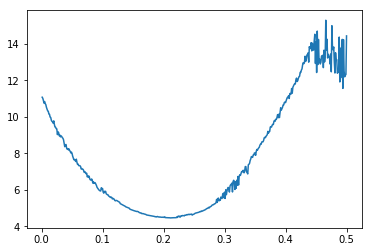

In [21]:
from matplotlib import pyplot as plt
plt.plot(np.linspace(0.001, 0.5, 500), list_of_dist)

## Real image

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)

In [14]:
brigthfield_path = '../assets/sample_image_actin_surligned.tif'
#dapi_path = '../assets/CELLPROFILER_sample_image_dapi.tiff.csv'
dapi_path = '../assets/sample_image_dapi.tiff'
scp_path = '../assets/star_convex_polynoms/models'
#initialising the mesh
organo, inners, outers, centers = generate_ring_from_image(brigthfield_path, dapi_path,
                                                           threshold=2,
                                                           method='SCP',
                                                           scp_model_path=scp_path,
                                                           rol_window_inside=20,
                                                           rol_window_outside=5)
Nf = organo.Nf
geom.update_all(organo)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + np.sin(np.pi/Nf)/(np.mean(organo.face_df.area)*organo.settings['R_in']*np.sin(2*np.pi/Nf)-2*np.mean(organo.face_df.area)*
                             np.sin(2*np.pi/Nf)*(8-2*(np.sin(2*np.pi/Nf)**2-4)/(np.sin(np.pi/Nf)**4+8*np.sin(np.pi/Nf)**2)
                                                )*(organo.settings['R_in']+organo.settings['R_out']))
print(alpha)
alpha = 1.001
# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  list(alpha*organo.face_df.area.values), 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)
normalize_scale(organo, geom)
geom.update_all(organo)
inners = inners[:int(2830/2)]
outers = outers[:int(outers.shape[0]/2)]

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01


Loading network weights from 'weights_best.h5'.


Reseting datasets values with new specs


{'geometry': 'planar', 'R_in': 119.94799383544922, 'R_out': 134.21666275024415, 'R_vit': None}
0.9999999950313019


In [15]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-8,'ftol': 1e-5, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-7,'ftol': 1e-6, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', 'output_path': './PSQP_min_dist'}

reg_weight = 1e-3
theta = 0.02

In [16]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (organo.settings['R_out']-organo.settings['R_in'])*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    api_vertex = organo.edge_df.loc[organo.apical_edges,
                                    ('srce', 'trgt')][organo.edge_df.face == cell]
    coord_api_vertex = organo.vert_df.loc[np.squeeze(api_vertex.values),
                                          ('x', 'y')].values
    coord_cell_center = np.squeeze(organo.face_df.loc[[cell], ('x', 'y')].values)
    pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                       coord_cell_center - coord_api_vertex[1])
    comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                     coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
    proj = coord_api_vertex[0] + pos_param * comp
    polar_coefs[cell] = np.linalg.norm(proj - coord_cell_center)
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.95693172, 0.94232203, 0.94547194, 0.95858202, 0.96833792,
       0.9648219 , 0.91607392, 0.85245031, 0.80282889, 0.77572843,
       0.74689122, 0.73455372, 0.76503627, 0.77568011, 0.74695913,
       0.7138449 , 0.7060971 , 0.68668743, 0.667607  , 0.77223273,
       0.71364921, 0.66963075, 0.71233387, 0.75011691, 0.637165  ,
       0.63926996, 0.63303069, 0.64547174, 0.59256778, 0.5841828 ,
       0.616935  , 0.63340362, 0.65084187, 0.67714867, 0.71492676,
       0.75004673, 0.79005016, 0.8337358 , 0.85660728, 0.87035794,
       0.87652863, 0.90518726, 0.93586089, 0.91716886, 0.87918212,
       0.8638491 , 0.88470231, 0.91139483, 0.91125517, 0.90822272,
       0.86054048, 0.84655011, 0.85550326, 0.84336572, 0.82600268,
       0.83246584, 0.84701109, 0.84902142, 0.81567255, 0.79344111,
       0.79803644, 0.82439882, 0.86254302, 0.89941738, 0.94820363,
       1.0266123 , 1.04023913, 1.08902115, 1.1329334 , 1.09416166,
       1.09408824, 1.10747654, 1.11939874, 1.0692942 , 0.95281

In [9]:
from tyssue_taylor.adjusters.cost_functions import distance_regularized
list_of_dist = []
initial_lumen_volume = organo.settings['lumen_volume']
initial_lumen_prefered_volume = organo.settings['lumen_prefered_vol']
organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0
for cst in np.linspace(0.001, 0.5, 500):
    params_in_sym_mesh = np.linalg.solve(*get_sim_mat(organo.Nf,
                                                      organo.settings['R_in'],
                                                      organo.settings['R_out'],
                                                      sum_lbda=cst))
    matrix = _coef_matrix(organo, sup_param='areas')
    constant = _right_side(organo, matrix)
    matrix = matrix[:-1]
    constant = constant[:-1]
    avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
                   (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
    for i in range(organo.Nf):
        i_cell_line = np.zeros(4*organo.Nf+1)
        index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
        index_suiv = np.squeeze(np.argwhere(organo.edge_df.face.values == (i+1)%organo.Nf))
        index[-1] = index_suiv[-2]
        i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
        matrix = np.vstack((matrix, i_cell_line))
    constant = np.concatenate((constant, avg_cste))
    mat_eq_cst, residuals = nnls(matrix, constant)
    organo_eq_cst = organo.copy()
    parameters = [('edge', 'line_tension'), ('face', 'prefered_area')]
    variables = {}
    variables[('edge_df', 'line_tension')] = prepare_tensions(organo, mat_eq_cst[:3*organo.Nf])
    variables[('face_df', 'prefered_area')] = mat_eq_cst[3*organo.Nf:4*organo.Nf]
    variables[('lumen_prefered_vol', None)] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
    Solver.find_energy_min(organo_eq_cst, geom, model)
    organo.settings['lumen_volume'] = initial_lumen_volume
    organo.settings['lumen_prefered_vol'] = initial_lumen_prefered_volume
    current_dist = distance_regularized(organo, organo_eq_cst,
                                        variables,
                                        Solver, geom, model,
                                        COPY_OR_SYM='sym')
    print('cst: ', cst, ' dist: ', current_dist)
    list_of_dist.append(current_dist)

Reseting datasets values with new specs


7916.547540039257 [22.48159874 22.16942638 21.76949576 ...  0.          0.
  0.        ]
cst:  0.001  dist:  [22.48159874 22.16942638 21.76949576 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7757.27289448159 [18.60794957 18.33247053 18.13834075 ...  0.          0.
  0.        ]
cst:  0.002  dist:  [18.60794957 18.33247053 18.13834075 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7757.24943831724 [18.60815161 18.33264977 18.13843318 ...  0.          0.
  0.        ]
cst:  0.003  dist:  [18.60815161 18.33264977 18.13843318 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7757.096896013619 [18.60828743 18.33302069 18.13861589 ...  0.          0.
  0.        ]
cst:  0.004  dist:  [18.60828743 18.33302069 18.13861589 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7756.883966747891 [18.60845904 18.33378194 18.13920632 ...  0.          0.
  0.        ]
cst:  0.005  dist:  [18.60845904 18.33378194 18.13920632 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.615865297371 [17.93851626 18.2243442  18.50958349 ...  0.          0.
  0.        ]
cst:  0.006  dist:  [17.93851626 18.2243442  18.50958349 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.551848917133 [17.99652793 18.27332756 18.50011389 ...  0.          0.
  0.        ]
cst:  0.007  dist:  [17.99652793 18.27332756 18.50011389 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.655249720362 [17.98994781 18.22752465 18.45752375 ...  0.          0.
  0.        ]
cst:  0.008  dist:  [17.98994781 18.22752465 18.45752375 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7647.487725499926 [18.05859832 18.3301473  18.51036421 ...  0.          0.
  0.        ]
cst:  0.009000000000000001  dist:  [18.05859832 18.3301473  18.51036421 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7647.280388834149 [17.9808512  18.27742002 18.52834681 ...  0.          0.
  0.        ]
cst:  0.010000000000000002  dist:  [17.9808512  18.27742002 18.52834681 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7645.621838666408 [18.05431224 18.31114537 18.53033494 ...  0.          0.
  0.        ]
cst:  0.011  dist:  [18.05431224 18.31114537 18.53033494 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7668.105642798834 [17.96803262 18.13428991 18.48014959 ...  0.          0.
  0.        ]
cst:  0.012  dist:  [17.96803262 18.13428991 18.48014959 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.352864063097 [18.00754629 18.18289019 18.51869911 ...  0.          0.
  0.        ]
cst:  0.013000000000000001  dist:  [18.00754629 18.18289019 18.51869911 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7658.133604864671 [17.96660274 18.18033476 18.49921543 ...  0.          0.
  0.        ]
cst:  0.014000000000000002  dist:  [17.96660274 18.18033476 18.49921543 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.209757068411 [18.09738943 18.30712199 18.49672659 ...  0.          0.
  0.        ]
cst:  0.015  dist:  [18.09738943 18.30712199 18.49672659 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.067982100589 [18.03810688 18.25842191 18.53612632 ...  0.          0.
  0.        ]
cst:  0.016  dist:  [18.03810688 18.25842191 18.53612632 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7669.867277702251 [17.96963002 18.25251201 18.53392646 ...  0.          0.
  0.        ]
cst:  0.017  dist:  [17.96963002 18.25251201 18.53392646 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7669.8306543735525 [18.01040847 18.16229732 18.48321623 ...  0.          0.
  0.        ]
cst:  0.018000000000000002  dist:  [18.01040847 18.16229732 18.48321623 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.008372121754 [18.03323346 18.28893141 18.50752398 ...  0.          0.
  0.        ]
cst:  0.019000000000000003  dist:  [18.03323346 18.28893141 18.50752398 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.418417242833 [18.12474076 18.36511204 18.5131773  ...  0.          0.
  0.        ]
cst:  0.02  dist:  [18.12474076 18.36511204 18.5131773  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7679.728305150979 [18.06372951 18.07878766 18.42552067 ...  0.          0.
  0.        ]
cst:  0.021  dist:  [18.06372951 18.07878766 18.42552067 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7646.662312177033 [18.14026871 18.37276176 18.46886085 ...  0.          0.
  0.        ]
cst:  0.022000000000000002  dist:  [18.14026871 18.37276176 18.46886085 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7672.125917273231 [18.06688404 18.25723754 18.52781752 ...  0.          0.
  0.        ]
cst:  0.023  dist:  [18.06688404 18.25723754 18.52781752 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7675.105141063898 [18.01708483 18.05209851 18.42283887 ...  0.          0.
  0.        ]
cst:  0.024  dist:  [18.01708483 18.05209851 18.42283887 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7676.385455801269 [18.03868861 18.17103577 18.49876181 ...  0.          0.
  0.        ]
cst:  0.025  dist:  [18.03868861 18.17103577 18.49876181 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7645.510562630572 [18.17038353 18.41260938 18.49103341 ...  0.          0.
  0.        ]
cst:  0.026000000000000002  dist:  [18.17038353 18.41260938 18.49103341 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7672.642700886583 [18.03453143 18.1562876  18.48149151 ...  0.          0.
  0.        ]
cst:  0.027000000000000003  dist:  [18.03453143 18.1562876  18.48149151 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7668.819477047299 [18.01104715 18.13935608 18.49658022 ...  0.          0.
  0.        ]
cst:  0.028  dist:  [18.01104715 18.13935608 18.49658022 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.7275358248 [18.08655019 18.37070183 18.5343877  ...  0.          0.
  0.        ]
cst:  0.029  dist:  [18.08655019 18.37070183 18.5343877  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7677.3339522680735 [18.01098027 18.07430922 18.47271793 ...  0.          0.
  0.        ]
cst:  0.030000000000000002  dist:  [18.01098027 18.07430922 18.47271793 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7654.16824933275 [18.09818092 18.34055224 18.53314391 ...  0.          0.
  0.        ]
cst:  0.031  dist:  [18.09818092 18.34055224 18.53314391 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.047170209056 [18.11423759 18.37583454 18.53982999 ...  0.          0.
  0.        ]
cst:  0.032  dist:  [18.11423759 18.37583454 18.53982999 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7672.121759513827 [18.02211525 18.08023638 18.38489112 ...  0.          0.
  0.        ]
cst:  0.033  dist:  [18.02211525 18.08023638 18.38489112 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7678.800037110327 [18.06222659 18.06065438 18.36799987 ...  0.          0.
  0.        ]
cst:  0.034  dist:  [18.06222659 18.06065438 18.36799987 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7676.885324479629 [18.00724491 18.02954503 18.40048445 ...  0.          0.
  0.        ]
cst:  0.035  dist:  [18.00724491 18.02954503 18.40048445 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.812567017632 [18.07244449 18.3628405  18.52640584 ...  0.          0.
  0.        ]
cst:  0.036000000000000004  dist:  [18.07244449 18.3628405  18.52640584 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7675.1965346314655 [18.04751839 18.12348232 18.49364468 ...  0.          0.
  0.        ]
cst:  0.037000000000000005  dist:  [18.04751839 18.12348232 18.49364468 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7658.0477662656385 [18.06057288 18.28922086 18.51444505 ...  0.          0.
  0.        ]
cst:  0.038  dist:  [18.06057288 18.28922086 18.51444505 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7649.5829561478895 [18.13316416 18.35296938 18.51419738 ...  0.          0.
  0.        ]
cst:  0.039  dist:  [18.13316416 18.35296938 18.51419738 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.68762353234 [18.10181731 18.33540375 18.54312584 ...  0.          0.
  0.        ]
cst:  0.04  dist:  [18.10181731 18.33540375 18.54312584 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.629737631263 [18.16263042 18.41595456 18.55839012 ...  0.          0.
  0.        ]
cst:  0.041  dist:  [18.16263042 18.41595456 18.55839012 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.841195759267 [18.12345756 18.36298833 18.54938535 ...  0.          0.
  0.        ]
cst:  0.042  dist:  [18.12345756 18.36298833 18.54938535 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.262068720907 [18.09559051 18.3490153  18.54049409 ...  0.          0.
  0.        ]
cst:  0.043000000000000003  dist:  [18.09559051 18.3490153  18.54049409 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.126805657321 [18.13732873 18.31192412 18.59581424 ...  0.          0.
  0.        ]
cst:  0.044000000000000004  dist:  [18.13732873 18.31192412 18.59581424 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.846815272408 [18.11665675 18.3230031  18.51675983 ...  0.          0.
  0.        ]
cst:  0.045  dist:  [18.11665675 18.3230031  18.51675983 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.97864494403 [18.13592163 18.38525439 18.52227121 ...  0.          0.
  0.        ]
cst:  0.046  dist:  [18.13592163 18.38525439 18.52227121 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.3909186402725 [18.10530942 18.36445515 18.52981097 ...  0.          0.
  0.        ]
cst:  0.047  dist:  [18.10530942 18.36445515 18.52981097 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.623418367942 [18.12530349 18.34485808 18.54870787 ...  0.          0.
  0.        ]
cst:  0.048  dist:  [18.12530349 18.34485808 18.54870787 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.947390512312 [18.09608124 18.33484558 18.55264419 ...  0.          0.
  0.        ]
cst:  0.049  dist:  [18.09608124 18.33484558 18.55264419 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.207008620994 [18.08977425 18.34480118 18.54678815 ...  0.          0.
  0.        ]
cst:  0.05  dist:  [18.08977425 18.34480118 18.54678815 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.295903267099 [18.08778155 18.32858463 18.53156871 ...  0.          0.
  0.        ]
cst:  0.051000000000000004  dist:  [18.08778155 18.32858463 18.53156871 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7669.9720830976685 [18.04852786 18.14475829 18.49795097 ...  0.          0.
  0.        ]
cst:  0.052000000000000005  dist:  [18.04852786 18.14475829 18.49795097 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7670.299163400831 [18.07452202 18.201544   18.50046484 ...  0.          0.
  0.        ]
cst:  0.053000000000000005  dist:  [18.07452202 18.201544   18.50046484 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.624234007888 [18.06287274 18.31784241 18.53061366 ...  0.          0.
  0.        ]
cst:  0.054  dist:  [18.06287274 18.31784241 18.53061366 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7674.6850473659 [18.04067692 18.04695255 18.38908844 ...  0.          0.
  0.        ]
cst:  0.055  dist:  [18.04067692 18.04695255 18.38908844 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7658.445775699309 [18.10374983 18.36342176 18.54823127 ...  0.          0.
  0.        ]
cst:  0.056  dist:  [18.10374983 18.36342176 18.54823127 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.684071227834 [18.07178838 18.34808811 18.51794247 ...  0.          0.
  0.        ]
cst:  0.057  dist:  [18.07178838 18.34808811 18.51794247 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7673.999824027527 [18.0625329  18.10020823 18.45151459 ...  0.          0.
  0.        ]
cst:  0.058  dist:  [18.0625329  18.10020823 18.45151459 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.369520815406 [18.12780571 18.37422051 18.51894506 ...  0.          0.
  0.        ]
cst:  0.059000000000000004  dist:  [18.12780571 18.37422051 18.51894506 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7658.450964503332 [18.10108553 18.36813542 18.53335227 ...  0.          0.
  0.        ]
cst:  0.060000000000000005  dist:  [18.10108553 18.36813542 18.53335227 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7668.338542328013 [18.09274773 18.14287239 18.45697916 ...  0.          0.
  0.        ]
cst:  0.061  dist:  [18.09274773 18.14287239 18.45697916 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.517977197879 [18.04753266 18.25490507 18.4507673  ...  0.          0.
  0.        ]
cst:  0.062  dist:  [18.04753266 18.25490507 18.4507673  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.517771087707 [18.13226767 18.39039549 18.53290993 ...  0.          0.
  0.        ]
cst:  0.063  dist:  [18.13226767 18.39039549 18.53290993 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7668.329713611608 [18.06849787 18.23967609 18.50232876 ...  0.          0.
  0.        ]
cst:  0.064  dist:  [18.06849787 18.23967609 18.50232876 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.213063582369 [18.19983845 18.45650247 18.5169665  ...  0.          0.
  0.        ]
cst:  0.065  dist:  [18.19983845 18.45650247 18.5169665  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.3785326945945 [18.14536215 18.40884529 18.52275975 ...  0.          0.
  0.        ]
cst:  0.066  dist:  [18.14536215 18.40884529 18.52275975 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7674.021067896887 [18.07605358 18.11726103 18.4250651  ...  0.          0.
  0.        ]
cst:  0.067  dist:  [18.07605358 18.11726103 18.4250651  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.334052039012 [18.13059389 18.34028061 18.52491569 ...  0.          0.
  0.        ]
cst:  0.068  dist:  [18.13059389 18.34028061 18.52491569 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7669.165427822428 [18.02457815 18.14534583 18.47629054 ...  0.          0.
  0.        ]
cst:  0.069  dist:  [18.02457815 18.14534583 18.47629054 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.521176734887 [18.13723946 18.41507724 18.54132775 ...  0.          0.
  0.        ]
cst:  0.07  dist:  [18.13723946 18.41507724 18.54132775 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.203092587105 [18.11505126 18.35108728 18.51962447 ...  0.          0.
  0.        ]
cst:  0.07100000000000001  dist:  [18.11505126 18.35108728 18.51962447 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7667.9398196632765 [18.07306949 18.20999177 18.51191215 ...  0.          0.
  0.        ]
cst:  0.07200000000000001  dist:  [18.07306949 18.20999177 18.51191215 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.941792892749 [18.13103115 18.38933068 18.53099211 ...  0.          0.
  0.        ]
cst:  0.07300000000000001  dist:  [18.13103115 18.38933068 18.53099211 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.896665760165 [18.02389358 18.23977434 18.51466769 ...  0.          0.
  0.        ]
cst:  0.074  dist:  [18.02389358 18.23977434 18.51466769 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.00213399325 [18.10550088 18.37214973 18.54905616 ...  0.          0.
  0.        ]
cst:  0.075  dist:  [18.10550088 18.37214973 18.54905616 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7647.876466537416 [18.12976838 18.38720401 18.49496622 ...  0.          0.
  0.        ]
cst:  0.076  dist:  [18.12976838 18.38720401 18.49496622 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.783421419625 [18.17358115 18.40644123 18.46724244 ...  0.          0.
  0.        ]
cst:  0.077  dist:  [18.17358115 18.40644123 18.46724244 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.6673746679135 [18.13998795 18.37319465 18.53798411 ...  0.          0.
  0.        ]
cst:  0.078  dist:  [18.13998795 18.37319465 18.53798411 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.989551633235 [18.09538398 18.30453855 18.52323662 ...  0.          0.
  0.        ]
cst:  0.079  dist:  [18.09538398 18.30453855 18.52323662 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.34091387912 [18.16369041 18.41689283 18.51436554 ...  0.          0.
  0.        ]
cst:  0.08  dist:  [18.16369041 18.41689283 18.51436554 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.524643505165 [18.12396889 18.38977403 18.53483932 ...  0.          0.
  0.        ]
cst:  0.081  dist:  [18.12396889 18.38977403 18.53483932 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.903039675338 [18.14558113 18.39381121 18.55388756 ...  0.          0.
  0.        ]
cst:  0.082  dist:  [18.14558113 18.39381121 18.55388756 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7670.055737350897 [18.06165651 18.13467086 18.4605831  ...  0.          0.
  0.        ]
cst:  0.083  dist:  [18.06165651 18.13467086 18.4605831  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.1096752212925 [18.15737107 18.39916255 18.5231604  ...  0.          0.
  0.        ]
cst:  0.084  dist:  [18.15737107 18.39916255 18.5231604  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.4528034198775 [18.14022969 18.40583733 18.49109117 ...  0.          0.
  0.        ]
cst:  0.085  dist:  [18.14022969 18.40583733 18.49109117 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.204051864388 [18.15270901 18.39086531 18.50442775 ...  0.          0.
  0.        ]
cst:  0.08600000000000001  dist:  [18.15270901 18.39086531 18.50442775 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7666.713904651641 [18.03744286 18.22834103 18.52359756 ...  0.          0.
  0.        ]
cst:  0.08700000000000001  dist:  [18.03744286 18.22834103 18.52359756 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.110076293671 [18.10039073 18.3381988  18.50604368 ...  0.          0.
  0.        ]
cst:  0.08800000000000001  dist:  [18.10039073 18.3381988  18.50604368 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7671.6611465103315 [18.08411057 18.11867647 18.42712414 ...  0.          0.
  0.        ]
cst:  0.089  dist:  [18.08411057 18.11867647 18.42712414 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.18379668449 [18.14456419 18.3828123  18.53175999 ...  0.          0.
  0.        ]
cst:  0.09  dist:  [18.14456419 18.3828123  18.53175999 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.948368528108 [18.08285256 18.31292711 18.52390807 ...  0.          0.
  0.        ]
cst:  0.091  dist:  [18.08285256 18.31292711 18.52390807 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.636742104334 [18.11490173 18.19014701 18.49398312 ...  0.          0.
  0.        ]
cst:  0.092  dist:  [18.11490173 18.19014701 18.49398312 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.0171648318355 [18.11844097 18.32609745 18.47693354 ...  0.          0.
  0.        ]
cst:  0.093  dist:  [18.11844097 18.32609745 18.47693354 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7649.65476069333 [18.09448752 18.34471735 18.52877399 ...  0.          0.
  0.        ]
cst:  0.094  dist:  [18.09448752 18.34471735 18.52877399 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.387255111397 [18.10112388 18.36526196 18.52924844 ...  0.          0.
  0.        ]
cst:  0.095  dist:  [18.10112388 18.36526196 18.52924844 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.041888973941 [18.10499929 18.39297831 18.52167983 ...  0.          0.
  0.        ]
cst:  0.096  dist:  [18.10499929 18.39297831 18.52167983 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.07344515989 [18.10315581 18.37895038 18.5680736  ...  0.          0.
  0.        ]
cst:  0.097  dist:  [18.10315581 18.37895038 18.5680736  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7649.665228126577 [18.11696352 18.34530179 18.50212638 ...  0.          0.
  0.        ]
cst:  0.098  dist:  [18.11696352 18.34530179 18.50212638 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.516050508713 [18.14682138 18.37632375 18.52752111 ...  0.          0.
  0.        ]
cst:  0.099  dist:  [18.14682138 18.37632375 18.52752111 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.087618046215 [18.08437913 18.34348092 18.54964255 ...  0.          0.
  0.        ]
cst:  0.1  dist:  [18.08437913 18.34348092 18.54964255 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.465200055209 [18.08325678 18.35481046 18.54738991 ...  0.          0.
  0.        ]
cst:  0.101  dist:  [18.08325678 18.35481046 18.54738991 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7646.909391196852 [18.14486602 18.38911354 18.50503673 ...  0.          0.
  0.        ]
cst:  0.10200000000000001  dist:  [18.14486602 18.38911354 18.50503673 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.569138861878 [18.08695089 18.34078836 18.53972287 ...  0.          0.
  0.        ]
cst:  0.10300000000000001  dist:  [18.08695089 18.34078836 18.53972287 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7645.994110286246 [18.10554357 18.35164595 18.49926241 ...  0.          0.
  0.        ]
cst:  0.10400000000000001  dist:  [18.10554357 18.35164595 18.49926241 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.1520590970895 [18.13203243 18.35073569 18.52173663 ...  0.          0.
  0.        ]
cst:  0.10500000000000001  dist:  [18.13203243 18.35073569 18.52173663 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.073561525343 [18.03038226 18.2839725  18.51905315 ...  0.          0.
  0.        ]
cst:  0.106  dist:  [18.03038226 18.2839725  18.51905315 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.942100122051 [18.12884444 18.19095563 18.51930823 ...  0.          0.
  0.        ]
cst:  0.107  dist:  [18.12884444 18.19095563 18.51930823 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7649.614661132104 [18.10947744 18.3549264  18.52458359 ...  0.          0.
  0.        ]
cst:  0.108  dist:  [18.10947744 18.3549264  18.52458359 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.137002590936 [18.08850439 18.33597251 18.55509218 ...  0.          0.
  0.        ]
cst:  0.109  dist:  [18.08850439 18.33597251 18.55509218 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.721265192585 [18.1352682  18.36741993 18.53090212 ...  0.          0.
  0.        ]
cst:  0.11  dist:  [18.1352682  18.36741993 18.53090212 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.318826654275 [18.07304172 18.28329671 18.47196879 ...  0.          0.
  0.        ]
cst:  0.111  dist:  [18.07304172 18.28329671 18.47196879 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.815528473748 [18.08882205 18.36583044 18.54447973 ...  0.          0.
  0.        ]
cst:  0.112  dist:  [18.08882205 18.36583044 18.54447973 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.0764070650985 [18.10101412 18.34274163 18.50967304 ...  0.          0.
  0.        ]
cst:  0.113  dist:  [18.10101412 18.34274163 18.50967304 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.714540167026 [18.03588555 18.22266379 18.51929193 ...  0.          0.
  0.        ]
cst:  0.114  dist:  [18.03588555 18.22266379 18.51929193 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7658.871935101948 [18.06916366 18.26452968 18.56255984 ...  0.          0.
  0.        ]
cst:  0.115  dist:  [18.06916366 18.26452968 18.56255984 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.027880737247 [18.11049467 18.15509335 18.47377415 ...  0.          0.
  0.        ]
cst:  0.116  dist:  [18.11049467 18.15509335 18.47377415 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.516759432242 [18.10251904 18.15369996 18.48518405 ...  0.          0.
  0.        ]
cst:  0.117  dist:  [18.10251904 18.15369996 18.48518405 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.148724048089 [18.02740631 18.22321906 18.49795166 ...  0.          0.
  0.        ]
cst:  0.11800000000000001  dist:  [18.02740631 18.22321906 18.49795166 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.570119225461 [18.09480636 18.3018744  18.54711954 ...  0.          0.
  0.        ]
cst:  0.11900000000000001  dist:  [18.09480636 18.3018744  18.54711954 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.911801307329 [18.11070195 18.3375631  18.5234567  ...  0.          0.
  0.        ]
cst:  0.12000000000000001  dist:  [18.11070195 18.3375631  18.5234567  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.60143890791 [18.10463652 18.16434067 18.5128457  ...  0.          0.
  0.        ]
cst:  0.121  dist:  [18.10463652 18.16434067 18.5128457  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.243682218492 [18.07721404 18.14500812 18.48752729 ...  0.          0.
  0.        ]
cst:  0.122  dist:  [18.07721404 18.14500812 18.48752729 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7647.325950503244 [18.13260704 18.35850987 18.52742952 ...  0.          0.
  0.        ]
cst:  0.123  dist:  [18.13260704 18.35850987 18.52742952 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.912308320297 [18.11345343 18.34836517 18.55156894 ...  0.          0.
  0.        ]
cst:  0.124  dist:  [18.11345343 18.34836517 18.55156894 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7658.11330698705 [18.06316996 18.23698462 18.54469545 ...  0.          0.
  0.        ]
cst:  0.125  dist:  [18.06316996 18.23698462 18.54469545 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.671017864277 [18.11800331 18.16796777 18.51502919 ...  0.          0.
  0.        ]
cst:  0.126  dist:  [18.11800331 18.16796777 18.51502919 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7646.702158856071 [18.12892142 18.34725384 18.51750401 ...  0.          0.
  0.        ]
cst:  0.127  dist:  [18.12892142 18.34725384 18.51750401 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.769876833016 [18.06986251 18.30155767 18.52323016 ...  0.          0.
  0.        ]
cst:  0.128  dist:  [18.06986251 18.30155767 18.52323016 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7668.180683068296 [18.13650277 18.16500494 18.48596131 ...  0.          0.
  0.        ]
cst:  0.129  dist:  [18.13650277 18.16500494 18.48596131 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.480423628331 [18.1025191  18.14734342 18.49161686 ...  0.          0.
  0.        ]
cst:  0.13  dist:  [18.1025191  18.14734342 18.49161686 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7649.813806043674 [18.11562123 18.32527599 18.52233751 ...  0.          0.
  0.        ]
cst:  0.131  dist:  [18.11562123 18.32527599 18.52233751 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.758964990428 [18.10001502 18.2027494  18.54215085 ...  0.          0.
  0.        ]
cst:  0.132  dist:  [18.10001502 18.2027494  18.54215085 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.548422127402 [18.13873963 18.35441933 18.55997246 ...  0.          0.
  0.        ]
cst:  0.133  dist:  [18.13873963 18.35441933 18.55997246 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7647.796237667931 [18.12751276 18.35237309 18.53308412 ...  0.          0.
  0.        ]
cst:  0.134  dist:  [18.12751276 18.35237309 18.53308412 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.641963169882 [18.13879423 18.19308853 18.52435422 ...  0.          0.
  0.        ]
cst:  0.135  dist:  [18.13879423 18.19308853 18.52435422 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.478429119472 [18.13590542 18.21509758 18.53126749 ...  0.          0.
  0.        ]
cst:  0.136  dist:  [18.13590542 18.21509758 18.53126749 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.113079096989 [18.11234328 18.32486907 18.53110832 ...  0.          0.
  0.        ]
cst:  0.137  dist:  [18.11234328 18.32486907 18.53110832 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.049425498924 [18.10652794 18.31622291 18.5383366  ...  0.          0.
  0.        ]
cst:  0.138  dist:  [18.10652794 18.31622291 18.5383366  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.996601295499 [18.10900407 18.3437888  18.56027179 ...  0.          0.
  0.        ]
cst:  0.139  dist:  [18.10900407 18.3437888  18.56027179 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.224797963148 [18.08479293 18.30628825 18.52372864 ...  0.          0.
  0.        ]
cst:  0.14  dist:  [18.08479293 18.30628825 18.52372864 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.424509426617 [18.14794914 18.20524379 18.52848027 ...  0.          0.
  0.        ]
cst:  0.14100000000000001  dist:  [18.14794914 18.20524379 18.52848027 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.963207030153 [18.12625759 18.17812232 18.51590944 ...  0.          0.
  0.        ]
cst:  0.14200000000000002  dist:  [18.12625759 18.17812232 18.51590944 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.4225338382075 [18.09279991 18.31049206 18.54532979 ...  0.          0.
  0.        ]
cst:  0.14300000000000002  dist:  [18.09279991 18.31049206 18.54532979 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.591214614356 [18.11380477 18.30616729 18.51911075 ...  0.          0.
  0.        ]
cst:  0.14400000000000002  dist:  [18.11380477 18.30616729 18.51911075 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.2405019702965 [18.09765289 18.3252679  18.50664936 ...  0.          0.
  0.        ]
cst:  0.14500000000000002  dist:  [18.09765289 18.3252679  18.50664936 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.06349408767 [18.14792394 18.23184461 18.51604619 ...  0.          0.
  0.        ]
cst:  0.146  dist:  [18.14792394 18.23184461 18.51604619 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7700.046024520134 [18.10357661 18.17877434 18.54897726 ...  0.          0.
  0.        ]
cst:  0.147  dist:  [18.10357661 18.17877434 18.54897726 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.543946172514 [18.12094506 18.32684446 18.53467265 ...  0.          0.
  0.        ]
cst:  0.148  dist:  [18.12094506 18.32684446 18.53467265 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.113665942585 [18.12720894 18.31979735 18.51928913 ...  0.          0.
  0.        ]
cst:  0.149  dist:  [18.12720894 18.31979735 18.51928913 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.550678323871 [18.11953296 18.30026984 18.53755753 ...  0.          0.
  0.        ]
cst:  0.15  dist:  [18.11953296 18.30026984 18.53755753 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.366111025129 [18.13110772 18.19426699 18.52814673 ...  0.          0.
  0.        ]
cst:  0.151  dist:  [18.13110772 18.19426699 18.52814673 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7654.795550492258 [18.12557059 18.31159099 18.54327531 ...  0.          0.
  0.        ]
cst:  0.152  dist:  [18.12557059 18.31159099 18.54327531 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.2092381754 [18.0917252  18.33761816 18.53247548 ...  0.          0.
  0.        ]
cst:  0.153  dist:  [18.0917252  18.33761816 18.53247548 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.970730347856 [18.13651167 18.34200359 18.53532025 ...  0.          0.
  0.        ]
cst:  0.154  dist:  [18.13651167 18.34200359 18.53532025 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.700493175112 [18.11591448 18.32248524 18.5263585  ...  0.          0.
  0.        ]
cst:  0.155  dist:  [18.11591448 18.32248524 18.5263585  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.850936088469 [18.12548678 18.3041907  18.53419197 ...  0.          0.
  0.        ]
cst:  0.156  dist:  [18.12548678 18.3041907  18.53419197 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.948303747084 [18.12901318 18.33792877 18.5315244  ...  0.          0.
  0.        ]
cst:  0.157  dist:  [18.12901318 18.33792877 18.5315244  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.864570164241 [18.09152156 18.28190813 18.52911649 ...  0.          0.
  0.        ]
cst:  0.158  dist:  [18.09152156 18.28190813 18.52911649 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.85926977977 [18.13774958 18.33419009 18.55386886 ...  0.          0.
  0.        ]
cst:  0.159  dist:  [18.13774958 18.33419009 18.55386886 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.063138427987 [18.08231978 18.25163894 18.54082123 ...  0.          0.
  0.        ]
cst:  0.16  dist:  [18.08231978 18.25163894 18.54082123 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.376871427393 [18.07912087 18.30308603 18.58776412 ...  0.          0.
  0.        ]
cst:  0.161  dist:  [18.07912087 18.30308603 18.58776412 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.070305147964 [18.11133216 18.34273354 18.55604025 ...  0.          0.
  0.        ]
cst:  0.162  dist:  [18.11133216 18.34273354 18.55604025 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.527793635176 [18.15216555 18.31661733 18.53421271 ...  0.          0.
  0.        ]
cst:  0.163  dist:  [18.15216555 18.31661733 18.53421271 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7667.087923819929 [18.15989558 18.22303855 18.53261441 ...  0.          0.
  0.        ]
cst:  0.164  dist:  [18.15989558 18.22303855 18.53261441 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.974137875174 [18.08704013 18.29234701 18.54657007 ...  0.          0.
  0.        ]
cst:  0.165  dist:  [18.08704013 18.29234701 18.54657007 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.761379057472 [18.14498908 18.34104051 18.53361919 ...  0.          0.
  0.        ]
cst:  0.166  dist:  [18.14498908 18.34104051 18.53361919 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.080588183852 [18.11118695 18.34094906 18.5677482  ...  0.          0.
  0.        ]
cst:  0.167  dist:  [18.11118695 18.34094906 18.5677482  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.01904628843 [18.08971768 18.33114973 18.5514223  ...  0.          0.
  0.        ]
cst:  0.168  dist:  [18.08971768 18.33114973 18.5514223  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7654.958877290364 [18.08219341 18.29189243 18.54386183 ...  0.          0.
  0.        ]
cst:  0.169  dist:  [18.08219341 18.29189243 18.54386183 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.468006293734 [18.09556452 18.31673744 18.53781928 ...  0.          0.
  0.        ]
cst:  0.17  dist:  [18.09556452 18.31673744 18.53781928 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.418045736734 [18.16311101 18.25668021 18.55784337 ...  0.          0.
  0.        ]
cst:  0.171  dist:  [18.16311101 18.25668021 18.55784337 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.073326317791 [18.10147634 18.30274495 18.55647362 ...  0.          0.
  0.        ]
cst:  0.17200000000000001  dist:  [18.10147634 18.30274495 18.55647362 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7676.463768708634 [18.17978245 18.12322967 18.43701288 ...  0.          0.
  0.        ]
cst:  0.17300000000000001  dist:  [18.17978245 18.12322967 18.43701288 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.727445881157 [18.14720099 18.3320849  18.55806009 ...  0.          0.
  0.        ]
cst:  0.17400000000000002  dist:  [18.14720099 18.3320849  18.55806009 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.593745280945 [18.18745252 18.2679992  18.55419451 ...  0.          0.
  0.        ]
cst:  0.17500000000000002  dist:  [18.18745252 18.2679992  18.55419451 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.254452982881 [18.1384926  18.25947757 18.53686102 ...  0.          0.
  0.        ]
cst:  0.17600000000000002  dist:  [18.1384926  18.25947757 18.53686102 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7667.987167887128 [18.17544845 18.22321814 18.5264892  ...  0.          0.
  0.        ]
cst:  0.177  dist:  [18.17544845 18.22321814 18.5264892  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.356903221324 [18.118073   18.31616185 18.54533941 ...  0.          0.
  0.        ]
cst:  0.178  dist:  [18.118073   18.31616185 18.54533941 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.559506931653 [18.10909852 18.29697862 18.56537372 ...  0.          0.
  0.        ]
cst:  0.179  dist:  [18.10909852 18.29697862 18.56537372 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7666.196909288091 [18.16603323 18.26167061 18.58412825 ...  0.          0.
  0.        ]
cst:  0.18  dist:  [18.16603323 18.26167061 18.58412825 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.955827082715 [18.18284758 18.27946402 18.56164508 ...  0.          0.
  0.        ]
cst:  0.181  dist:  [18.18284758 18.27946402 18.56164508 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.133493568931 [18.15381432 18.34840696 18.53586179 ...  0.          0.
  0.        ]
cst:  0.182  dist:  [18.15381432 18.34840696 18.53586179 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.7373934031475 [18.11922349 18.31519885 18.52988613 ...  0.          0.
  0.        ]
cst:  0.183  dist:  [18.11922349 18.31519885 18.52988613 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7654.449098352561 [18.12231166 18.33050829 18.57140363 ...  0.          0.
  0.        ]
cst:  0.184  dist:  [18.12231166 18.33050829 18.57140363 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7654.181203119752 [18.1527886  18.35517297 18.59077147 ...  0.          0.
  0.        ]
cst:  0.185  dist:  [18.1527886  18.35517297 18.59077147 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7672.39488878075 [18.19993865 18.2871856  18.57351482 ...  0.          0.
  0.        ]
cst:  0.186  dist:  [18.19993865 18.2871856  18.57351482 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.568529083088 [18.18631542 18.28588088 18.55667853 ...  0.          0.
  0.        ]
cst:  0.187  dist:  [18.18631542 18.28588088 18.55667853 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7672.421211501523 [18.21996808 18.22662705 18.47371466 ...  0.          0.
  0.        ]
cst:  0.188  dist:  [18.21996808 18.22662705 18.47371466 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.218126733266 [18.18782805 18.29241887 18.58911516 ...  0.          0.
  0.        ]
cst:  0.189  dist:  [18.18782805 18.29241887 18.58911516 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7666.134574760011 [18.1766196  18.29489044 18.57314738 ...  0.          0.
  0.        ]
cst:  0.19  dist:  [18.1766196  18.29489044 18.57314738 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7666.446665404142 [18.18563544 18.28860693 18.55905781 ...  0.          0.
  0.        ]
cst:  0.191  dist:  [18.18563544 18.28860693 18.55905781 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7666.729212024469 [18.18767162 18.30867669 18.57385999 ...  0.          0.
  0.        ]
cst:  0.192  dist:  [18.18767162 18.30867669 18.57385999 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.08233870863 [18.15675997 18.32575831 18.54672496 ...  0.          0.
  0.        ]
cst:  0.193  dist:  [18.15675997 18.32575831 18.54672496 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.264622461314 [18.1770495  18.36951274 18.57774555 ...  0.          0.
  0.        ]
cst:  0.194  dist:  [18.1770495  18.36951274 18.57774555 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7658.370850515074 [18.13323158 18.2915707  18.56849637 ...  0.          0.
  0.        ]
cst:  0.195  dist:  [18.13323158 18.2915707  18.56849637 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.227647227482 [18.21050738 18.37472498 18.60631977 ...  0.          0.
  0.        ]
cst:  0.196  dist:  [18.21050738 18.37472498 18.60631977 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.370168374835 [18.1496457  18.33787426 18.55315757 ...  0.          0.
  0.        ]
cst:  0.197  dist:  [18.1496457  18.33787426 18.55315757 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.644553352875 [18.17762759 18.34036569 18.56898565 ...  0.          0.
  0.        ]
cst:  0.198  dist:  [18.17762759 18.34036569 18.56898565 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.484657435116 [18.1821935  18.35205359 18.55762092 ...  0.          0.
  0.        ]
cst:  0.199  dist:  [18.1821935  18.35205359 18.55762092 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.540835263292 [18.17331546 18.34584996 18.58886236 ...  0.          0.
  0.        ]
cst:  0.2  dist:  [18.17331546 18.34584996 18.58886236 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.012358578354 [18.16135944 18.33396891 18.5757609  ...  0.          0.
  0.        ]
cst:  0.201  dist:  [18.16135944 18.33396891 18.5757609  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.139211656057 [18.19082554 18.36512258 18.5923641  ...  0.          0.
  0.        ]
cst:  0.202  dist:  [18.19082554 18.36512258 18.5923641  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.197870247314 [18.18420053 18.35969517 18.58015574 ...  0.          0.
  0.        ]
cst:  0.203  dist:  [18.18420053 18.35969517 18.58015574 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.378961921062 [18.17346308 18.34917245 18.55085141 ...  0.          0.
  0.        ]
cst:  0.20400000000000001  dist:  [18.17346308 18.34917245 18.55085141 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.626148082267 [18.19232006 18.37203056 18.5836277  ...  0.          0.
  0.        ]
cst:  0.20500000000000002  dist:  [18.19232006 18.37203056 18.5836277  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7668.178825441654 [18.22307535 18.3185591  18.58905453 ...  0.          0.
  0.        ]
cst:  0.20600000000000002  dist:  [18.22307535 18.3185591  18.58905453 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.372404397476 [18.18659297 18.34501601 18.59485584 ...  0.          0.
  0.        ]
cst:  0.20700000000000002  dist:  [18.18659297 18.34501601 18.59485584 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.890092919478 [18.18354292 18.33915415 18.56699062 ...  0.          0.
  0.        ]
cst:  0.20800000000000002  dist:  [18.18354292 18.33915415 18.56699062 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7658.459831742792 [18.18469497 18.33941419 18.56890385 ...  0.          0.
  0.        ]
cst:  0.20900000000000002  dist:  [18.18469497 18.33941419 18.56890385 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.887936117346 [18.19947114 18.35292485 18.59166711 ...  0.          0.
  0.        ]
cst:  0.21  dist:  [18.19947114 18.35292485 18.59166711 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.414304554553 [18.18434668 18.35221547 18.56957794 ...  0.          0.
  0.        ]
cst:  0.211  dist:  [18.18434668 18.35221547 18.56957794 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.295464938845 [18.2244051  18.34457033 18.60090919 ...  0.          0.
  0.        ]
cst:  0.212  dist:  [18.2244051  18.34457033 18.60090919 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.133567899221 [18.22109984 18.3922502  18.57851239 ...  0.          0.
  0.        ]
cst:  0.213  dist:  [18.22109984 18.3922502  18.57851239 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.628688930572 [18.22488793 18.39380957 18.56074237 ...  0.          0.
  0.        ]
cst:  0.214  dist:  [18.22488793 18.39380957 18.56074237 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.728760485825 [18.22578974 18.39591119 18.58883795 ...  0.          0.
  0.        ]
cst:  0.215  dist:  [18.22578974 18.39591119 18.58883795 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.838108257187 [18.21623977 18.36325505 18.59446126 ...  0.          0.
  0.        ]
cst:  0.216  dist:  [18.21623977 18.36325505 18.59446126 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.094148401781 [18.19982074 18.36143103 18.58992936 ...  0.          0.
  0.        ]
cst:  0.217  dist:  [18.19982074 18.36143103 18.58992936 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.221261716365 [18.24088651 18.41767007 18.61913338 ...  0.          0.
  0.        ]
cst:  0.218  dist:  [18.24088651 18.41767007 18.61913338 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.639469217815 [18.19977287 18.4099216  18.55945953 ...  0.          0.
  0.        ]
cst:  0.219  dist:  [18.19977287 18.4099216  18.55945953 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7670.1274836261855 [18.23308805 18.36323189 18.61803624 ...  0.          0.
  0.        ]
cst:  0.22  dist:  [18.23308805 18.36323189 18.61803624 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.087805877682 [18.21598846 18.37094114 18.5939171  ...  0.          0.
  0.        ]
cst:  0.221  dist:  [18.21598846 18.37094114 18.5939171  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.2168084757495 [18.20460435 18.35910894 18.59027586 ...  0.          0.
  0.        ]
cst:  0.222  dist:  [18.20460435 18.35910894 18.59027586 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.742039676363 [18.21863237 18.38279295 18.59030273 ...  0.          0.
  0.        ]
cst:  0.223  dist:  [18.21863237 18.38279295 18.59030273 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7666.855838298325 [18.21073088 18.33637441 18.57661345 ...  0.          0.
  0.        ]
cst:  0.224  dist:  [18.21073088 18.33637441 18.57661345 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.473119444049 [18.20911878 18.39007754 18.57934199 ...  0.          0.
  0.        ]
cst:  0.225  dist:  [18.20911878 18.39007754 18.57934199 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.932995774992 [18.18889113 18.33236935 18.55389672 ...  0.          0.
  0.        ]
cst:  0.226  dist:  [18.18889113 18.33236935 18.55389672 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.796654429332 [18.22401923 18.3963369  18.60629395 ...  0.          0.
  0.        ]
cst:  0.227  dist:  [18.22401923 18.3963369  18.60629395 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.751892963728 [18.22037598 18.38636681 18.58609148 ...  0.          0.
  0.        ]
cst:  0.228  dist:  [18.22037598 18.38636681 18.58609148 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7666.242267435983 [18.20111767 18.34238854 18.56776248 ...  0.          0.
  0.        ]
cst:  0.229  dist:  [18.20111767 18.34238854 18.56776248 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7666.589315602652 [18.2052017  18.36089016 18.5902225  ...  0.          0.
  0.        ]
cst:  0.23  dist:  [18.2052017  18.36089016 18.5902225  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.321966177092 [18.24772611 18.41758919 18.59627403 ...  0.          0.
  0.        ]
cst:  0.231  dist:  [18.24772611 18.41758919 18.59627403 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.9935122219895 [18.23938127 18.40728126 18.60383262 ...  0.          0.
  0.        ]
cst:  0.232  dist:  [18.23938127 18.40728126 18.60383262 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.480469508221 [18.2526481  18.39394375 18.60973759 ...  0.          0.
  0.        ]
cst:  0.233  dist:  [18.2526481  18.39394375 18.60973759 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7674.637634687473 [18.27490046 18.37409306 18.59622485 ...  0.          0.
  0.        ]
cst:  0.234  dist:  [18.27490046 18.37409306 18.59622485 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7668.1940458132085 [18.21480295 18.36731501 18.60477159 ...  0.          0.
  0.        ]
cst:  0.23500000000000001  dist:  [18.21480295 18.36731501 18.60477159 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.316135162425 [18.22613125 18.39432798 18.58862992 ...  0.          0.
  0.        ]
cst:  0.23600000000000002  dist:  [18.22613125 18.39432798 18.58862992 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7667.152929003904 [18.19659819 18.34788561 18.56597659 ...  0.          0.
  0.        ]
cst:  0.23700000000000002  dist:  [18.19659819 18.34788561 18.56597659 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.602793856633 [18.21519313 18.39915031 18.60665766 ...  0.          0.
  0.        ]
cst:  0.23800000000000002  dist:  [18.21519313 18.39915031 18.60665766 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.2177768013635 [18.27136013 18.43491234 18.63466232 ...  0.          0.
  0.        ]
cst:  0.23900000000000002  dist:  [18.27136013 18.43491234 18.63466232 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.827485877755 [18.26982344 18.42751434 18.5766486  ...  0.          0.
  0.        ]
cst:  0.24000000000000002  dist:  [18.26982344 18.42751434 18.5766486  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7666.7894059951 [18.23543496 18.41114047 18.59541721 ...  0.          0.
  0.        ]
cst:  0.241  dist:  [18.23543496 18.41114047 18.59541721 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.576127348856 [18.24623595 18.42172662 18.60532712 ...  0.          0.
  0.        ]
cst:  0.242  dist:  [18.24623595 18.42172662 18.60532712 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.5413848982025 [18.25253956 18.39024088 18.60866329 ...  0.          0.
  0.        ]
cst:  0.243  dist:  [18.25253956 18.39024088 18.60866329 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7667.555500231133 [18.27025416 18.40413281 18.56556429 ...  0.          0.
  0.        ]
cst:  0.244  dist:  [18.27025416 18.40413281 18.56556429 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.564545885298 [18.23701467 18.41884472 18.63203109 ...  0.          0.
  0.        ]
cst:  0.245  dist:  [18.23701467 18.41884472 18.63203109 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.500510397427 [18.28260789 18.43655959 18.61875909 ...  0.          0.
  0.        ]
cst:  0.246  dist:  [18.28260789 18.43655959 18.61875909 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7667.582456733891 [18.22999326 18.38470995 18.57746447 ...  0.          0.
  0.        ]
cst:  0.247  dist:  [18.22999326 18.38470995 18.57746447 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.985866307203 [18.23268793 18.40723564 18.63401521 ...  0.          0.
  0.        ]
cst:  0.248  dist:  [18.23268793 18.40723564 18.63401521 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7660.690865443054 [18.29840474 18.4693044  18.61900378 ...  0.          0.
  0.        ]
cst:  0.249  dist:  [18.29840474 18.4693044  18.61900378 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7667.4833620038435 [18.21082332 18.36214235 18.55467514 ...  0.          0.
  0.        ]
cst:  0.25  dist:  [18.21082332 18.36214235 18.55467514 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.757134451086 [18.27924039 18.42672869 18.60952972 ...  0.          0.
  0.        ]
cst:  0.251  dist:  [18.27924039 18.42672869 18.60952972 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7671.597219595948 [18.27153991 18.3711147  18.59712919 ...  0.          0.
  0.        ]
cst:  0.252  dist:  [18.27153991 18.3711147  18.59712919 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7669.528243935899 [18.26241502 18.43314287 18.56829113 ...  0.          0.
  0.        ]
cst:  0.253  dist:  [18.26241502 18.43314287 18.56829113 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7666.704005182034 [18.24902382 18.38078903 18.58640827 ...  0.          0.
  0.        ]
cst:  0.254  dist:  [18.24902382 18.38078903 18.58640827 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.056435720775 [18.28768257 18.44924032 18.64838594 ...  0.          0.
  0.        ]
cst:  0.255  dist:  [18.28768257 18.44924032 18.64838594 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7669.079959051062 [18.25973497 18.41084678 18.56721913 ...  0.          0.
  0.        ]
cst:  0.256  dist:  [18.25973497 18.41084678 18.56721913 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.829822152567 [18.26735043 18.43994649 18.64274058 ...  0.          0.
  0.        ]
cst:  0.257  dist:  [18.26735043 18.43994649 18.64274058 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.534025972253 [18.25975469 18.42306535 18.60295694 ...  0.          0.
  0.        ]
cst:  0.258  dist:  [18.25975469 18.42306535 18.60295694 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7667.60052228661 [18.2639139  18.4179671  18.57817655 ...  0.          0.
  0.        ]
cst:  0.259  dist:  [18.2639139  18.4179671  18.57817655 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.206272784173 [18.28103997 18.46125356 18.63794109 ...  0.          0.
  0.        ]
cst:  0.26  dist:  [18.28103997 18.46125356 18.63794109 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.73594305676 [18.29412506 18.42527585 18.62600895 ...  0.          0.
  0.        ]
cst:  0.261  dist:  [18.29412506 18.42527585 18.62600895 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7672.722810392361 [18.28918709 18.38914231 18.5975247  ...  0.          0.
  0.        ]
cst:  0.262  dist:  [18.28918709 18.38914231 18.5975247  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.346536260406 [18.26906964 18.43769139 18.58459116 ...  0.          0.
  0.        ]
cst:  0.263  dist:  [18.26906964 18.43769139 18.58459116 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7672.932201865095 [18.30163578 18.39562929 18.57872325 ...  0.          0.
  0.        ]
cst:  0.264  dist:  [18.30163578 18.39562929 18.57872325 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.682145886379 [18.32725361 18.48805002 18.66456545 ...  0.          0.
  0.        ]
cst:  0.265  dist:  [18.32725361 18.48805002 18.66456545 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7670.412883709926 [18.28792919 18.39956425 18.59854167 ...  0.          0.
  0.        ]
cst:  0.266  dist:  [18.28792919 18.39956425 18.59854167 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.506172736182 [18.30455559 18.45767015 18.64027185 ...  0.          0.
  0.        ]
cst:  0.267  dist:  [18.30455559 18.45767015 18.64027185 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.681966610777 [18.25030342 18.38912366 18.57636544 ...  0.          0.
  0.        ]
cst:  0.268  dist:  [18.25030342 18.38912366 18.57636544 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.951551480401 [18.25978552 18.39012684 18.59957267 ...  0.          0.
  0.        ]
cst:  0.269  dist:  [18.25978552 18.39012684 18.59957267 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.879393309948 [18.26859985 18.42659116 18.59618867 ...  0.          0.
  0.        ]
cst:  0.27  dist:  [18.26859985 18.42659116 18.59618867 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.762467670014 [18.28151142 18.41500061 18.60037267 ...  0.          0.
  0.        ]
cst:  0.271  dist:  [18.28151142 18.41500061 18.60037267 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.615157970671 [18.27956318 18.43051918 18.60771487 ...  0.          0.
  0.        ]
cst:  0.272  dist:  [18.27956318 18.43051918 18.60771487 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.559785792435 [18.2922731  18.41709987 18.60220387 ...  0.          0.
  0.        ]
cst:  0.273  dist:  [18.2922731  18.41709987 18.60220387 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.29625578166 [18.32413966 18.42447216 18.62253963 ...  0.          0.
  0.        ]
cst:  0.274  dist:  [18.32413966 18.42447216 18.62253963 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7668.58464698906 [18.31271901 18.41145012 18.59675239 ...  0.          0.
  0.        ]
cst:  0.275  dist:  [18.31271901 18.41145012 18.59675239 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.8548242623165 [18.28916495 18.41568003 18.59760305 ...  0.          0.
  0.        ]
cst:  0.276  dist:  [18.28916495 18.41568003 18.59760305 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.248758164567 [18.28488675 18.4104887  18.59723907 ...  0.          0.
  0.        ]
cst:  0.277  dist:  [18.28488675 18.4104887  18.59723907 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7668.378586655193 [18.33270964 18.40358881 18.59861963 ...  0.          0.
  0.        ]
cst:  0.278  dist:  [18.33270964 18.40358881 18.59861963 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7658.612957448078 [18.30245602 18.44137468 18.62405137 ...  0.          0.
  0.        ]
cst:  0.279  dist:  [18.30245602 18.44137468 18.62405137 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.974528401518 [18.28086617 18.41993839 18.59535309 ...  0.          0.
  0.        ]
cst:  0.28  dist:  [18.28086617 18.41993839 18.59535309 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7666.049329507989 [18.26558552 18.40576409 18.57932542 ...  0.          0.
  0.        ]
cst:  0.281  dist:  [18.26558552 18.40576409 18.57932542 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7671.769763943068 [18.33766158 18.41275434 18.58645184 ...  0.          0.
  0.        ]
cst:  0.28200000000000003  dist:  [18.33766158 18.41275434 18.58645184 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.229033165501 [18.27911978 18.41490966 18.59305444 ...  0.          0.
  0.        ]
cst:  0.28300000000000003  dist:  [18.27911978 18.41490966 18.59305444 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7667.957221859208 [18.29594148 18.40723819 18.58340743 ...  0.          0.
  0.        ]
cst:  0.28400000000000003  dist:  [18.29594148 18.40723819 18.58340743 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7676.50850644696 [18.40100899 18.44282253 18.56796809 ...  0.          0.
  0.        ]
cst:  0.28500000000000003  dist:  [18.40100899 18.44282253 18.56796809 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.50794053933 [18.30129935 18.41134139 18.60311263 ...  0.          0.
  0.        ]
cst:  0.28600000000000003  dist:  [18.30129935 18.41134139 18.60311263 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.105530981084 [18.28997843 18.40433259 18.56313916 ...  0.          0.
  0.        ]
cst:  0.28700000000000003  dist:  [18.28997843 18.40433259 18.56313916 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7668.81588395633 [18.34031249 18.40420366 18.58877167 ...  0.          0.
  0.        ]
cst:  0.28800000000000003  dist:  [18.34031249 18.40420366 18.58877167 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.263933932272 [18.28106509 18.38453774 18.53553061 ...  0.          0.
  0.        ]
cst:  0.28900000000000003  dist:  [18.28106509 18.38453774 18.53553061 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.969661461552 [18.26815689 18.37502834 18.51520102 ...  0.          0.
  0.        ]
cst:  0.29  dist:  [18.26815689 18.37502834 18.51520102 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7672.4535156669 [18.36283233 18.39096965 18.58272449 ...  0.          0.
  0.        ]
cst:  0.291  dist:  [18.36283233 18.39096965 18.58272449 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.692726210071 [18.32091104 18.40312719 18.5307629  ...  0.          0.
  0.        ]
cst:  0.292  dist:  [18.32091104 18.40312719 18.5307629  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.753536791171 [18.3171545  18.40476082 18.52441941 ...  0.          0.
  0.        ]
cst:  0.293  dist:  [18.3171545  18.40476082 18.52441941 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7654.387564682988 [18.35497402 18.43156566 18.48335328 ...  0.          0.
  0.        ]
cst:  0.294  dist:  [18.35497402 18.43156566 18.48335328 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.391466506281 [18.33148968 18.42302095 18.49396953 ...  0.          0.
  0.        ]
cst:  0.295  dist:  [18.33148968 18.42302095 18.49396953 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.721007136819 [18.31420371 18.40095793 18.51211155 ...  0.          0.
  0.        ]
cst:  0.296  dist:  [18.31420371 18.40095793 18.51211155 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.276111377533 [18.34186479 18.40717295 18.4510711  ...  0.          0.
  0.        ]
cst:  0.297  dist:  [18.34186479 18.40717295 18.4510711  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.628827228476 [18.33925396 18.40731546 18.55459496 ...  0.          0.
  0.        ]
cst:  0.298  dist:  [18.33925396 18.40731546 18.55459496 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.733874083724 [18.36271678 18.44698208 18.46530986 ...  0.          0.
  0.        ]
cst:  0.299  dist:  [18.36271678 18.44698208 18.46530986 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.664192983202 [18.3737558  18.41737785 18.45779039 ...  0.          0.
  0.        ]
cst:  0.3  dist:  [18.3737558  18.41737785 18.45779039 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.795371549844 [18.37922235 18.41357999 18.4439012  ...  0.          0.
  0.        ]
cst:  0.301  dist:  [18.37922235 18.41357999 18.4439012  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.219559263718 [18.36852852 18.44762719 18.45559537 ...  0.          0.
  0.        ]
cst:  0.302  dist:  [18.36852852 18.44762719 18.45559537 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7647.252080465385 [18.37007004 18.45338276 18.47199789 ...  0.          0.
  0.        ]
cst:  0.303  dist:  [18.37007004 18.45338276 18.47199789 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.854730660453 [18.37596807 18.41704006 18.52589295 ...  0.          0.
  0.        ]
cst:  0.304  dist:  [18.37596807 18.41704006 18.52589295 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.897364306945 [18.38043153 18.45352728 18.45383335 ...  0.          0.
  0.        ]
cst:  0.305  dist:  [18.38043153 18.45352728 18.45383335 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7639.324852990027 [18.42119427 18.43591075 18.40559557 ...  0.          0.
  0.        ]
cst:  0.306  dist:  [18.42119427 18.43591075 18.40559557 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7646.856460808821 [18.41136304 18.48168044 18.43974037 ...  0.          0.
  0.        ]
cst:  0.307  dist:  [18.41136304 18.48168044 18.43974037 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7680.312825096605 [18.36730086 18.37745826 18.49267217 ...  0.          0.
  0.        ]
cst:  0.308  dist:  [18.36730086 18.37745826 18.49267217 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.694226594719 [18.41988858 18.43631549 18.42518359 ...  0.          0.
  0.        ]
cst:  0.309  dist:  [18.41988858 18.43631549 18.42518359 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7658.613786318749 [18.39275723 18.4532058  18.48797209 ...  0.          0.
  0.        ]
cst:  0.31  dist:  [18.39275723 18.4532058  18.48797209 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.043603993296 [18.42587188 18.43061267 18.50609384 ...  0.          0.
  0.        ]
cst:  0.311  dist:  [18.42587188 18.43061267 18.50609384 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7645.7996614680715 [18.42881439 18.43724305 18.4255208  ...  0.          0.
  0.        ]
cst:  0.312  dist:  [18.42881439 18.43724305 18.4255208  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.9556082282725 [18.38447998 18.45294632 18.45524124 ...  0.          0.
  0.        ]
cst:  0.313  dist:  [18.38447998 18.45294632 18.45524124 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.645526317416 [18.42188717 18.4849928  18.46174374 ...  0.          0.
  0.        ]
cst:  0.314  dist:  [18.42188717 18.4849928  18.46174374 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7645.373590256054 [18.43244258 18.45034806 18.44532043 ...  0.          0.
  0.        ]
cst:  0.315  dist:  [18.43244258 18.45034806 18.44532043 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.988630701961 [18.38182467 18.43271482 18.4756106  ...  0.          0.
  0.        ]
cst:  0.316  dist:  [18.38182467 18.43271482 18.4756106  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.638614085036 [18.41177847 18.45268325 18.51080748 ...  0.          0.
  0.        ]
cst:  0.317  dist:  [18.41177847 18.45268325 18.51080748 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.732333040311 [18.43330945 18.4920666  18.47317567 ...  0.          0.
  0.        ]
cst:  0.318  dist:  [18.43330945 18.4920666  18.47317567 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.891923136796 [18.44174714 18.45549966 18.4677011  ...  0.          0.
  0.        ]
cst:  0.319  dist:  [18.44174714 18.45549966 18.4677011  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7654.862279964507 [18.41808287 18.45780059 18.46894867 ...  0.          0.
  0.        ]
cst:  0.32  dist:  [18.41808287 18.45780059 18.46894867 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.293433357433 [18.4490422  18.44463847 18.52873204 ...  0.          0.
  0.        ]
cst:  0.321  dist:  [18.4490422  18.44463847 18.52873204 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.936715503811 [18.4709353  18.45671615 18.48265047 ...  0.          0.
  0.        ]
cst:  0.322  dist:  [18.4709353  18.45671615 18.48265047 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7642.683842233354 [18.46042388 18.45756337 18.47391201 ...  0.          0.
  0.        ]
cst:  0.323  dist:  [18.46042388 18.45756337 18.47391201 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.151533188716 [18.43942976 18.48753571 18.46652558 ...  0.          0.
  0.        ]
cst:  0.324  dist:  [18.43942976 18.48753571 18.46652558 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.140013965176 [18.45183622 18.43570431 18.47708691 ...  0.          0.
  0.        ]
cst:  0.325  dist:  [18.45183622 18.43570431 18.47708691 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.194786156765 [18.43357164 18.436444   18.54538927 ...  0.          0.
  0.        ]
cst:  0.326  dist:  [18.43357164 18.436444   18.54538927 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7649.434389919747 [18.49090079 18.50655036 18.49208048 ...  0.          0.
  0.        ]
cst:  0.327  dist:  [18.49090079 18.50655036 18.49208048 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.675776068934 [18.48219524 18.48857313 18.54852337 ...  0.          0.
  0.        ]
cst:  0.328  dist:  [18.48219524 18.48857313 18.54852337 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7646.1671821613545 [18.49070378 18.48284802 18.48379897 ...  0.          0.
  0.        ]
cst:  0.329  dist:  [18.49070378 18.48284802 18.48379897 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.943674629785 [18.48862567 18.48738276 18.55593395 ...  0.          0.
  0.        ]
cst:  0.33  dist:  [18.48862567 18.48738276 18.55593395 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7634.998310743409 [18.48020066 18.47727722 18.49676458 ...  0.          0.
  0.        ]
cst:  0.331  dist:  [18.48020066 18.47727722 18.49676458 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.003201161203 [18.51936316 18.49680004 18.54814869 ...  0.          0.
  0.        ]
cst:  0.332  dist:  [18.51936316 18.49680004 18.54814869 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7647.79340192688 [18.48218304 18.47477928 18.47442051 ...  0.          0.
  0.        ]
cst:  0.333  dist:  [18.48218304 18.47477928 18.47442051 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7638.315865695071 [18.49936549 18.52331821 18.49135403 ...  0.          0.
  0.        ]
cst:  0.334  dist:  [18.49936549 18.52331821 18.49135403 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.708670150674 [18.43369766 18.43567953 18.51385371 ...  0.          0.
  0.        ]
cst:  0.335  dist:  [18.43369766 18.43567953 18.51385371 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.451823429368 [18.48615584 18.45761681 18.51178728 ...  0.          0.
  0.        ]
cst:  0.336  dist:  [18.48615584 18.45761681 18.51178728 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.92420222611 [18.43919382 18.45320329 18.51534796 ...  0.          0.
  0.        ]
cst:  0.337  dist:  [18.43919382 18.45320329 18.51534796 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.310470317092 [18.43896131 18.44461706 18.51340501 ...  0.          0.
  0.        ]
cst:  0.338  dist:  [18.43896131 18.44461706 18.51340501 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7664.0429663275045 [18.44738089 18.44968505 18.51319077 ...  0.          0.
  0.        ]
cst:  0.339  dist:  [18.44738089 18.44968505 18.51319077 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7668.37419729735 [18.45606897 18.45406253 18.49766603 ...  0.          0.
  0.        ]
cst:  0.34  dist:  [18.45606897 18.45406253 18.49766603 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7634.765076451758 [18.47478188 18.47926902 18.48702061 ...  0.          0.
  0.        ]
cst:  0.341  dist:  [18.47478188 18.47926902 18.48702061 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7667.223955692108 [18.46257941 18.45523394 18.49792694 ...  0.          0.
  0.        ]
cst:  0.342  dist:  [18.46257941 18.45523394 18.49792694 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7626.405987529521 [18.51644472 18.52176544 18.50874604 ...  0.          0.
  0.        ]
cst:  0.343  dist:  [18.51644472 18.52176544 18.50874604 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7623.001630098281 [18.5044824  18.49499792 18.4887802  ...  0.          0.
  0.        ]
cst:  0.34400000000000003  dist:  [18.5044824  18.49499792 18.4887802  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7658.22654071367 [18.51431333 18.48148834 18.53771908 ...  0.          0.
  0.        ]
cst:  0.34500000000000003  dist:  [18.51431333 18.48148834 18.53771908 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7665.208930169154 [18.5136068  18.48612011 18.49027885 ...  0.          0.
  0.        ]
cst:  0.34600000000000003  dist:  [18.5136068  18.48612011 18.49027885 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7663.4408365797135 [18.4969004  18.5048923  18.50470881 ...  0.          0.
  0.        ]
cst:  0.34700000000000003  dist:  [18.4969004  18.5048923  18.50470881 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.218623293088 [18.53376719 18.51200634 18.51971458 ...  0.          0.
  0.        ]
cst:  0.34800000000000003  dist:  [18.53376719 18.51200634 18.51971458 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.7229430055695 [18.48185214 18.48411414 18.50356463 ...  0.          0.
  0.        ]
cst:  0.34900000000000003  dist:  [18.48185214 18.48411414 18.50356463 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7654.28429417736 [18.50389606 18.4924145  18.51319213 ...  0.          0.
  0.        ]
cst:  0.35000000000000003  dist:  [18.50389606 18.4924145  18.51319213 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7630.878825972416 [18.5340001  18.57054679 18.50643394 ...  0.          0.
  0.        ]
cst:  0.35100000000000003  dist:  [18.5340001  18.57054679 18.50643394 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.115365329504 [18.49472615 18.46163896 18.47438421 ...  0.          0.
  0.        ]
cst:  0.35200000000000004  dist:  [18.49472615 18.46163896 18.47438421 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.977523970805 [18.50428982 18.47793769 18.47958192 ...  0.          0.
  0.        ]
cst:  0.353  dist:  [18.50428982 18.47793769 18.47958192 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.14878338849 [18.56621969 18.52907861 18.52240533 ...  0.          0.
  0.        ]
cst:  0.354  dist:  [18.56621969 18.52907861 18.52240533 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.951147844689 [18.52354168 18.5023524  18.50880326 ...  0.          0.
  0.        ]
cst:  0.355  dist:  [18.52354168 18.5023524  18.50880326 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7667.570751518944 [18.52068308 18.48924471 18.45643569 ...  0.          0.
  0.        ]
cst:  0.356  dist:  [18.52068308 18.48924471 18.45643569 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.481417434803 [18.51703634 18.50120931 18.49367327 ...  0.          0.
  0.        ]
cst:  0.357  dist:  [18.51703634 18.50120931 18.49367327 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.51080225229 [18.51748014 18.49886214 18.48644448 ...  0.          0.
  0.        ]
cst:  0.358  dist:  [18.51748014 18.49886214 18.48644448 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.497608194246 [18.52606899 18.52538822 18.49887588 ...  0.          0.
  0.        ]
cst:  0.359  dist:  [18.52606899 18.52538822 18.49887588 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.102705801989 [18.55626774 18.53614327 18.52751894 ...  0.          0.
  0.        ]
cst:  0.36  dist:  [18.55626774 18.53614327 18.52751894 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7638.342438115375 [18.5604149  18.55856783 18.55919246 ...  0.          0.
  0.        ]
cst:  0.361  dist:  [18.5604149  18.55856783 18.55919246 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.1123267295025 [18.51669765 18.49074955 18.47174989 ...  0.          0.
  0.        ]
cst:  0.362  dist:  [18.51669765 18.49074955 18.47174989 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7662.000627362657 [18.52419649 18.51796225 18.45748019 ...  0.          0.
  0.        ]
cst:  0.363  dist:  [18.52419649 18.51796225 18.45748019 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.665038042444 [18.5208252  18.52608498 18.5296847  ...  0.          0.
  0.        ]
cst:  0.364  dist:  [18.5208252  18.52608498 18.5296847  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.860540241981 [18.57265256 18.54298694 18.53286677 ...  0.          0.
  0.        ]
cst:  0.365  dist:  [18.57265256 18.54298694 18.53286677 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.440382116873 [18.55324232 18.54125421 18.51621827 ...  0.          0.
  0.        ]
cst:  0.366  dist:  [18.55324232 18.54125421 18.51621827 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7649.991718003283 [18.54693967 18.54235097 18.52651517 ...  0.          0.
  0.        ]
cst:  0.367  dist:  [18.54693967 18.54235097 18.52651517 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.918924613768 [18.52644385 18.50441508 18.44851455 ...  0.          0.
  0.        ]
cst:  0.368  dist:  [18.52644385 18.50441508 18.44851455 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7631.277211729499 [18.58132912 18.59828347 18.57809639 ...  0.          0.
  0.        ]
cst:  0.369  dist:  [18.58132912 18.59828347 18.57809639 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.288083124936 [18.58033429 18.57027733 18.52541283 ...  0.          0.
  0.        ]
cst:  0.37  dist:  [18.58033429 18.57027733 18.52541283 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7657.247694094318 [18.53439534 18.51175125 18.44367655 ...  0.          0.
  0.        ]
cst:  0.371  dist:  [18.53439534 18.51175125 18.44367655 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.611195837055 [18.52472386 18.52101498 18.46444588 ...  0.          0.
  0.        ]
cst:  0.372  dist:  [18.52472386 18.52101498 18.46444588 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.165617967665 [18.56077108 18.54382471 18.49207364 ...  0.          0.
  0.        ]
cst:  0.373  dist:  [18.56077108 18.54382471 18.49207364 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.050528619555 [18.59641584 18.56312349 18.524927   ...  0.          0.
  0.        ]
cst:  0.374  dist:  [18.59641584 18.56312349 18.524927   ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7635.112389781454 [18.59402125 18.57937733 18.54127576 ...  0.          0.
  0.        ]
cst:  0.375  dist:  [18.59402125 18.57937733 18.54127576 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.9692746416895 [18.55647322 18.56362869 18.44842048 ...  0.          0.
  0.        ]
cst:  0.376  dist:  [18.55647322 18.56362869 18.44842048 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7659.965358534235 [18.56349606 18.54120547 18.4415715  ...  0.          0.
  0.        ]
cst:  0.377  dist:  [18.56349606 18.54120547 18.4415715  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.850098681623 [18.58778978 18.57183423 18.52360164 ...  0.          0.
  0.        ]
cst:  0.378  dist:  [18.58778978 18.57183423 18.52360164 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.614660566642 [18.56196374 18.55331179 18.50890021 ...  0.          0.
  0.        ]
cst:  0.379  dist:  [18.56196374 18.55331179 18.50890021 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.983506636583 [18.56823569 18.56072931 18.50811407 ...  0.          0.
  0.        ]
cst:  0.38  dist:  [18.56823569 18.56072931 18.50811407 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7633.970817513089 [18.62482385 18.64373392 18.60199333 ...  0.          0.
  0.        ]
cst:  0.381  dist:  [18.62482385 18.64373392 18.60199333 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.320195882953 [18.56966045 18.56444622 18.52929101 ...  0.          0.
  0.        ]
cst:  0.382  dist:  [18.56966045 18.56444622 18.52929101 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7646.986338651211 [18.60693683 18.598775   18.53642733 ...  0.          0.
  0.        ]
cst:  0.383  dist:  [18.60693683 18.598775   18.53642733 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.4653062554335 [18.57595778 18.57620324 18.44910137 ...  0.          0.
  0.        ]
cst:  0.384  dist:  [18.57595778 18.57620324 18.44910137 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.329813766162 [18.56621425 18.56614538 18.43910941 ...  0.          0.
  0.        ]
cst:  0.385  dist:  [18.56621425 18.56614538 18.43910941 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.464785206142 [18.5922343  18.57506379 18.47800049 ...  0.          0.
  0.        ]
cst:  0.386  dist:  [18.5922343  18.57506379 18.47800049 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7649.165587455259 [18.58565536 18.57869401 18.4896725  ...  0.          0.
  0.        ]
cst:  0.387  dist:  [18.58565536 18.57869401 18.4896725  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.870290677989 [18.57790695 18.57752329 18.46957622 ...  0.          0.
  0.        ]
cst:  0.388  dist:  [18.57790695 18.57752329 18.46957622 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.610525047936 [18.59030475 18.57803537 18.45434791 ...  0.          0.
  0.        ]
cst:  0.389  dist:  [18.59030475 18.57803537 18.45434791 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7652.64942410863 [18.59208846 18.57102957 18.44795319 ...  0.          0.
  0.        ]
cst:  0.39  dist:  [18.59208846 18.57102957 18.44795319 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7661.381000649338 [18.59358431 18.5948772  18.41095557 ...  0.          0.
  0.        ]
cst:  0.391  dist:  [18.59358431 18.5948772  18.41095557 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7649.357844609877 [18.61222476 18.60453099 18.50003688 ...  0.          0.
  0.        ]
cst:  0.392  dist:  [18.61222476 18.60453099 18.50003688 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.670882265408 [18.6290979  18.61791266 18.51025268 ...  0.          0.
  0.        ]
cst:  0.393  dist:  [18.6290979  18.61791266 18.51025268 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.251915959238 [18.58322403 18.57322514 18.42303419 ...  0.          0.
  0.        ]
cst:  0.394  dist:  [18.58322403 18.57322514 18.42303419 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7653.600773875917 [18.57723299 18.57767569 18.43406427 ...  0.          0.
  0.        ]
cst:  0.395  dist:  [18.57723299 18.57767569 18.43406427 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.306868328437 [18.58097374 18.56691361 18.42635753 ...  0.          0.
  0.        ]
cst:  0.396  dist:  [18.58097374 18.56691361 18.42635753 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.309624187508 [18.59082455 18.59392176 18.44350391 ...  0.          0.
  0.        ]
cst:  0.397  dist:  [18.59082455 18.59392176 18.44350391 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.317689441676 [18.64314662 18.65625342 18.49859569 ...  0.          0.
  0.        ]
cst:  0.398  dist:  [18.64314662 18.65625342 18.49859569 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.678098640815 [18.61391704 18.60346731 18.40998301 ...  0.          0.
  0.        ]
cst:  0.399  dist:  [18.61391704 18.60346731 18.40998301 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.584219245611 [18.61089056 18.59679578 18.41763577 ...  0.          0.
  0.        ]
cst:  0.4  dist:  [18.61089056 18.59679578 18.41763577 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.708856067226 [18.6220705  18.60419057 18.40849001 ...  0.          0.
  0.        ]
cst:  0.401  dist:  [18.6220705  18.60419057 18.40849001 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.63058949048 [18.61307808 18.59348453 18.39106074 ...  0.          0.
  0.        ]
cst:  0.402  dist:  [18.61307808 18.59348453 18.39106074 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7650.920011518641 [18.61753038 18.59643897 18.39413754 ...  0.          0.
  0.        ]
cst:  0.403  dist:  [18.61753038 18.59643897 18.39413754 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7655.599365935435 [18.60885922 18.62342375 18.42574764 ...  0.          0.
  0.        ]
cst:  0.404  dist:  [18.60885922 18.62342375 18.42574764 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7656.221758538716 [18.60395933 18.62171141 18.39517559 ...  0.          0.
  0.        ]
cst:  0.405  dist:  [18.60395933 18.62171141 18.39517559 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.683279004799 [18.61211846 18.6392736  18.41218142 ...  0.          0.
  0.        ]
cst:  0.406  dist:  [18.61211846 18.6392736  18.41218142 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.640316384936 [18.65930071 18.66199301 18.4054257  ...  0.          0.
  0.        ]
cst:  0.40700000000000003  dist:  [18.65930071 18.66199301 18.4054257  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7645.436683036906 [18.66244031 18.65414538 18.44721511 ...  0.          0.
  0.        ]
cst:  0.40800000000000003  dist:  [18.66244031 18.65414538 18.44721511 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7647.1907976258535 [18.65154918 18.67924439 18.40771263 ...  0.          0.
  0.        ]
cst:  0.40900000000000003  dist:  [18.65154918 18.67924439 18.40771263 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.366596024818 [18.66605818 18.6766283  18.39601268 ...  0.          0.
  0.        ]
cst:  0.41000000000000003  dist:  [18.66605818 18.6766283  18.39601268 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.954062191029 [18.68402033 18.68278237 18.37364536 ...  0.          0.
  0.        ]
cst:  0.41100000000000003  dist:  [18.68402033 18.68278237 18.37364536 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7651.164024534644 [18.77571762 18.65687104 18.33764484 ...  0.          0.
  0.        ]
cst:  0.41200000000000003  dist:  [18.77571762 18.65687104 18.33764484 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.018113995421 [18.67353187 18.68766904 18.38366555 ...  0.          0.
  0.        ]
cst:  0.41300000000000003  dist:  [18.67353187 18.68766904 18.38366555 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.281185721425 [19.08746293 18.56877291 18.23684896 ...  0.          0.
  0.        ]
cst:  0.41400000000000003  dist:  [19.08746293 18.56877291 18.23684896 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7648.781951391818 [19.09934225 18.58097383 18.24701963 ...  0.          0.
  0.        ]
cst:  0.41500000000000004  dist:  [19.09934225 18.58097383 18.24701963 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.718033435645 [19.06957787 18.55340724 18.22465702 ...  0.          0.
  0.        ]
cst:  0.41600000000000004  dist:  [19.06957787 18.55340724 18.22465702 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.106492804783 [19.09011984 18.57364325 18.24467765 ...  0.          0.
  0.        ]
cst:  0.41700000000000004  dist:  [19.09011984 18.57364325 18.24467765 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.289157717367 [19.08434628 18.56848515 18.24016616 ...  0.          0.
  0.        ]
cst:  0.418  dist:  [19.08434628 18.56848515 18.24016616 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7649.2494385083955 [19.11462439 18.59508987 18.26271491 ...  0.          0.
  0.        ]
cst:  0.419  dist:  [19.11462439 18.59508987 18.26271491 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.073247004331 [19.10061607 18.58578024 18.25878786 ...  0.          0.
  0.        ]
cst:  0.42  dist:  [19.10061607 18.58578024 18.25878786 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.27176544812 [19.17218004 18.65592007 18.32682745 ...  0.          0.
  0.        ]
cst:  0.421  dist:  [19.17218004 18.65592007 18.32682745 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.88579628293 [19.1802854  18.66306866 18.33257016 ...  0.          0.
  0.        ]
cst:  0.422  dist:  [19.1802854  18.66306866 18.33257016 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.894411101437 [19.15697876 18.64116609 18.31268944 ...  0.          0.
  0.        ]
cst:  0.423  dist:  [19.15697876 18.64116609 18.31268944 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.803213513344 [19.15304878 18.63754307 18.30954486 ...  0.          0.
  0.        ]
cst:  0.424  dist:  [19.15304878 18.63754307 18.30954486 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.692890801905 [19.15548411 18.63955036 18.31096575 ...  0.          0.
  0.        ]
cst:  0.425  dist:  [19.15548411 18.63955036 18.31096575 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.519160300513 [19.15811461 18.64199302 18.31306068 ...  0.          0.
  0.        ]
cst:  0.426  dist:  [19.15811461 18.64199302 18.31306068 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.777669998872 [19.15297658 18.63655158 18.30729468 ...  0.          0.
  0.        ]
cst:  0.427  dist:  [19.15297658 18.63655158 18.30729468 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.613765140151 [19.15352099 18.63763453 18.30939    ...  0.          0.
  0.        ]
cst:  0.428  dist:  [19.15352099 18.63763453 18.30939    ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7649.86321796917 [19.16556624 18.64565731 18.31172562 ...  0.          0.
  0.        ]
cst:  0.429  dist:  [19.16556624 18.64565731 18.31172562 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7645.102731405184 [19.14508993 18.62861579 18.29923925 ...  0.          0.
  0.        ]
cst:  0.43  dist:  [19.14508993 18.62861579 18.29923925 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.939805311839 [19.1625727  18.64593503 18.31644715 ...  0.          0.
  0.        ]
cst:  0.431  dist:  [19.1625727  18.64593503 18.31644715 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.685446655819 [19.15787215 18.64131934 18.31193868 ...  0.          0.
  0.        ]
cst:  0.432  dist:  [19.15787215 18.64131934 18.31193868 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.9557819341235 [19.14921483 18.63258244 18.30293734 ...  0.          0.
  0.        ]
cst:  0.433  dist:  [19.14921483 18.63258244 18.30293734 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.023376603214 [19.1615818  18.645233   18.31606748 ...  0.          0.
  0.        ]
cst:  0.434  dist:  [19.1615818  18.645233   18.31606748 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.999882767743 [19.14496874 18.62876707 18.29983554 ...  0.          0.
  0.        ]
cst:  0.435  dist:  [19.14496874 18.62876707 18.29983554 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.965321049151 [19.16538464 18.64869472 18.31903332 ...  0.          0.
  0.        ]
cst:  0.436  dist:  [19.16538464 18.64869472 18.31903332 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7642.62509344542 [19.15741602 18.64265959 18.31562382 ...  0.          0.
  0.        ]
cst:  0.437  dist:  [19.15741602 18.64265959 18.31562382 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.443489315603 [19.1469894  18.6308083  18.30204032 ...  0.          0.
  0.        ]
cst:  0.438  dist:  [19.1469894  18.6308083  18.30204032 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.9394881862145 [19.13998727 18.62369263 18.29469364 ...  0.          0.
  0.        ]
cst:  0.439  dist:  [19.13998727 18.62369263 18.29469364 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.215096608183 [19.14862977 18.63233233 18.3032217  ...  0.          0.
  0.        ]
cst:  0.44  dist:  [19.14862977 18.63233233 18.3032217  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7642.835122836524 [19.14690899 18.63134683 18.30328614 ...  0.          0.
  0.        ]
cst:  0.441  dist:  [19.14690899 18.63134683 18.30328614 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7642.587292195605 [19.15273635 18.63657095 18.30768274 ...  0.          0.
  0.        ]
cst:  0.442  dist:  [19.15273635 18.63657095 18.30768274 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7642.245222073454 [19.14802953 18.63276662 18.30511659 ...  0.          0.
  0.        ]
cst:  0.443  dist:  [19.14802953 18.63276662 18.30511659 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.368911863814 [19.14777409 18.6313143  18.30219665 ...  0.          0.
  0.        ]
cst:  0.444  dist:  [19.14777409 18.6313143  18.30219665 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7641.742022392496 [19.15070856 18.63540192 18.30768525 ...  0.          0.
  0.        ]
cst:  0.445  dist:  [19.15070856 18.63540192 18.30768525 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7641.137884118913 [19.14710363 18.63193158 18.30439987 ...  0.          0.
  0.        ]
cst:  0.446  dist:  [19.14710363 18.63193158 18.30439987 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7646.452587360421 [19.14981145 18.63092717 18.29801922 ...  0.          0.
  0.        ]
cst:  0.447  dist:  [19.14981145 18.63092717 18.29801922 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7641.8561130444095 [19.13455403 18.6192246  18.29143981 ...  0.          0.
  0.        ]
cst:  0.448  dist:  [19.13455403 18.6192246  18.29143981 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.980690013382 [19.16306893 18.64547329 18.31458217 ...  0.          0.
  0.        ]
cst:  0.449  dist:  [19.16306893 18.64547329 18.31458217 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7635.39189604975 [19.14323598 18.63300261 18.31231826 ...  0.          0.
  0.        ]
cst:  0.45  dist:  [19.14323598 18.63300261 18.31231826 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7642.324353953957 [19.14019947 18.62426613 18.29577411 ...  0.          0.
  0.        ]
cst:  0.451  dist:  [19.14019947 18.62426613 18.29577411 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.012384861809 [19.14795095 18.63087481 18.30070505 ...  0.          0.
  0.        ]
cst:  0.452  dist:  [19.14795095 18.63087481 18.30070505 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7640.56916976458 [19.13828416 18.62261785 18.29448303 ...  0.          0.
  0.        ]
cst:  0.453  dist:  [19.13828416 18.62261785 18.29448303 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7641.121923314848 [19.14631672 18.6305645  18.30208001 ...  0.          0.
  0.        ]
cst:  0.454  dist:  [19.14631672 18.6305645  18.30208001 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7641.230067709292 [19.13668099 18.62118365 18.29304357 ...  0.          0.
  0.        ]
cst:  0.455  dist:  [19.13668099 18.62118365 18.29304357 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7642.2844400784115 [19.14042943 18.6237858  18.29424997 ...  0.          0.
  0.        ]
cst:  0.456  dist:  [19.14042943 18.6237858  18.29424997 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7640.407334255657 [19.13664412 18.62077747 18.29237631 ...  0.          0.
  0.        ]
cst:  0.457  dist:  [19.13664412 18.62077747 18.29237631 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7640.588055825772 [19.14249817 18.62625865 18.29727724 ...  0.          0.
  0.        ]
cst:  0.458  dist:  [19.14249817 18.62625865 18.29727724 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7639.19498111657 [19.12631345 18.61120734 18.28381289 ...  0.          0.
  0.        ]
cst:  0.459  dist:  [19.12631345 18.61120734 18.28381289 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7642.102254910455 [19.15162288 18.633983   18.3032368  ...  0.          0.
  0.        ]
cst:  0.46  dist:  [19.15162288 18.633983   18.3032368  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7639.626602726125 [19.13425307 18.61814312 18.28934759 ...  0.          0.
  0.        ]
cst:  0.461  dist:  [19.13425307 18.61814312 18.28934759 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7641.927784542487 [19.14620237 18.62805047 18.29622472 ...  0.          0.
  0.        ]
cst:  0.462  dist:  [19.14620237 18.62805047 18.29622472 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7637.949178264012 [19.14550399 18.63004803 18.30210579 ...  0.          0.
  0.        ]
cst:  0.463  dist:  [19.14550399 18.63004803 18.30210579 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7636.30996593992 [19.13175672 18.61869257 18.29412644 ...  0.          0.
  0.        ]
cst:  0.464  dist:  [19.13175672 18.61869257 18.29412644 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7638.655339464855 [19.1345437  18.61856934 18.2899604  ...  0.          0.
  0.        ]
cst:  0.465  dist:  [19.1345437  18.61856934 18.2899604  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7637.071273787467 [19.13477126 18.61975268 18.29241399 ...  0.          0.
  0.        ]
cst:  0.466  dist:  [19.13477126 18.61975268 18.29241399 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7639.774982400045 [19.15373818 18.63717354 18.30773999 ...  0.          0.
  0.        ]
cst:  0.467  dist:  [19.15373818 18.63717354 18.30773999 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7638.209619993591 [19.1401342  18.62371119 18.29447748 ...  0.          0.
  0.        ]
cst:  0.468  dist:  [19.1401342  18.62371119 18.29447748 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7643.464464642428 [19.14591303 18.62601109 18.29179955 ...  0.          0.
  0.        ]
cst:  0.46900000000000003  dist:  [19.14591303 18.62601109 18.29179955 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7635.141788639105 [19.12439164 18.61123348 18.28660471 ...  0.          0.
  0.        ]
cst:  0.47000000000000003  dist:  [19.12439164 18.61123348 18.28660471 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7642.2887225037 [19.14779624 18.62766142 18.29325153 ...  0.          0.
  0.        ]
cst:  0.47100000000000003  dist:  [19.14779624 18.62766142 18.29325153 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7637.749474042832 [19.12998234 18.61496746 18.28765712 ...  0.          0.
  0.        ]
cst:  0.47200000000000003  dist:  [19.12998234 18.61496746 18.28765712 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7636.056332831338 [19.12791634 18.61398407 18.28828458 ...  0.          0.
  0.        ]
cst:  0.47300000000000003  dist:  [19.12791634 18.61398407 18.28828458 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7636.350235216824 [19.13105265 18.61541    18.28726235 ...  0.          0.
  0.        ]
cst:  0.47400000000000003  dist:  [19.13105265 18.61541    18.28726235 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7644.765937422897 [19.15905664 18.63530753 18.29572061 ...  0.          0.
  0.        ]
cst:  0.47500000000000003  dist:  [19.15905664 18.63530753 18.29572061 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7636.005680840815 [19.13104037 18.61614231 18.2890495  ...  0.          0.
  0.        ]
cst:  0.47600000000000003  dist:  [19.13104037 18.61614231 18.2890495  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7633.956077211995 [19.13494991 18.62341823 18.29768447 ...  0.          0.
  0.        ]
cst:  0.47700000000000004  dist:  [19.13494991 18.62341823 18.29768447 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7632.652309110676 [19.124631   18.61264693 18.28958438 ...  0.          0.
  0.        ]
cst:  0.47800000000000004  dist:  [19.124631   18.61264693 18.28958438 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7633.324238775686 [19.12721183 18.61305643 18.28711509 ...  0.          0.
  0.        ]
cst:  0.47900000000000004  dist:  [19.12721183 18.61305643 18.28711509 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7627.948609061057 [19.14330256 18.63400803 18.31465564 ...  0.          0.
  0.        ]
cst:  0.48000000000000004  dist:  [19.14330256 18.63400803 18.31465564 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7628.415007435235 [19.13756481 18.62814964 18.30861862 ...  0.          0.
  0.        ]
cst:  0.481  dist:  [19.13756481 18.62814964 18.30861862 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7631.3570289446225 [19.13122579 18.61875945 18.29498519 ...  0.          0.
  0.        ]
cst:  0.482  dist:  [19.13122579 18.61875945 18.29498519 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7639.466896675469 [19.10859656 18.58902191 18.25545145 ...  0.          0.
  0.        ]
cst:  0.483  dist:  [19.10859656 18.58902191 18.25545145 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7635.608406111707 [19.1285123  18.61095521 18.28014737 ...  0.          0.
  0.        ]
cst:  0.484  dist:  [19.1285123  18.61095521 18.28014737 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7634.949333728789 [19.11503996 18.59817308 18.26866351 ...  0.          0.
  0.        ]
cst:  0.485  dist:  [19.11503996 18.59817308 18.26866351 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7629.464773852264 [19.13341697 18.62118772 18.2977273  ...  0.          0.
  0.        ]
cst:  0.486  dist:  [19.13341697 18.62118772 18.2977273  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7631.120373094689 [19.11674507 18.60362193 18.27895944 ...  0.          0.
  0.        ]
cst:  0.487  dist:  [19.11674507 18.60362193 18.27895944 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7634.607512938146 [19.11722627 18.60052491 18.27086351 ...  0.          0.
  0.        ]
cst:  0.488  dist:  [19.11722627 18.60052491 18.27086351 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7629.316053416762 [19.12947283 18.61626515 18.29150805 ...  0.          0.
  0.        ]
cst:  0.489  dist:  [19.12947283 18.61626515 18.29150805 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7632.545382278796 [19.13889185 18.62291344 18.29458997 ...  0.          0.
  0.        ]
cst:  0.49  dist:  [19.13889185 18.62291344 18.29458997 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7631.428715321807 [19.13089685 18.6159194  18.28878998 ...  0.          0.
  0.        ]
cst:  0.491  dist:  [19.13089685 18.6159194  18.28878998 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7634.691041227685 [19.11585316 18.59756389 18.26603867 ...  0.          0.
  0.        ]
cst:  0.492  dist:  [19.11585316 18.59756389 18.26603867 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7633.473755795985 [19.13112714 18.61416097 18.28426188 ...  0.          0.
  0.        ]
cst:  0.493  dist:  [19.13112714 18.61416097 18.28426188 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7630.926919083327 [19.13458787 18.61986636 18.2930396  ...  0.          0.
  0.        ]
cst:  0.494  dist:  [19.13458787 18.61986636 18.2930396  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7628.354249774511 [19.1290037  18.61687911 18.29362216 ...  0.          0.
  0.        ]
cst:  0.495  dist:  [19.1290037  18.61687911 18.29362216 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7633.399733675256 [19.11963611 18.60268087 18.27276435 ...  0.          0.
  0.        ]
cst:  0.496  dist:  [19.11963611 18.60268087 18.27276435 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7629.584986345557 [19.14034638 18.62671466 18.30154471 ...  0.          0.
  0.        ]
cst:  0.497  dist:  [19.14034638 18.62671466 18.30154471 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7634.421498609579 [19.12271469 18.60436239 18.2724542  ...  0.          0.
  0.        ]
cst:  0.498  dist:  [19.12271469 18.60436239 18.2724542  ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7633.835082589648 [19.11750751 18.59960985 18.26848541 ...  0.          0.
  0.        ]
cst:  0.499  dist:  [19.11750751 18.59960985 18.26848541 ...  0.          0.
  0.        ]


Reseting datasets values with new specs


7633.754253162253 [19.11189385 18.59392881 18.26238852 ...  0.          0.
  0.        ]
cst:  0.5  dist:  [19.11189385 18.59392881 18.26238852 ...  0.          0.
  0.        ]


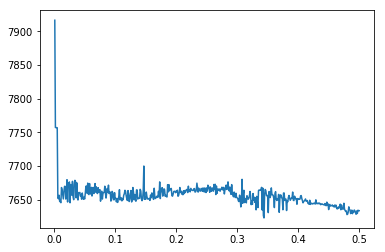

In [11]:
from matplotlib import pyplot as plt
list_of_copm_dist = []
for table in list_of_dist:
    somme = np.sum(table)
    list_of_copm_dist.append(somme)
plt.plot(np.linspace(0.001, 0.5, 500), list_of_copm_dist)

In [12]:
from tyssue_taylor.adjusters.cost_functions import distance_regularized
list_of_dist = []
initial_lumen_volume = organo.settings['lumen_volume']
initial_lumen_prefered_volume = organo.settings['lumen_prefered_vol']
organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0
for cst in np.linspace(0.001, 0.5, 500):
    params_in_sym_mesh = np.linalg.solve(*get_sim_mat(organo.Nf,
                                                      organo.settings['R_in'],
                                                      organo.settings['R_out'],
                                                      sum_lbda=cst))
    matrix = _coef_matrix(organo, sup_param='areas')
    constant = _right_side(organo, matrix)
    matrix = matrix[:-1]
    constant = constant[:-1]
    avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
                   (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
    for i in range(organo.Nf):
        i_cell_line = np.zeros(4*organo.Nf+1)
        index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
        index_suiv = np.squeeze(np.argwhere(organo.edge_df.face.values == (i+1)%organo.Nf))
        index[-1] = index_suiv[-2]
        i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
        matrix = np.vstack((matrix, i_cell_line))
    constant = np.concatenate((constant, avg_cste))
    mat_eq_cst, residuals = nnls(matrix, constant)
    organo_eq_cst = organo.copy()
    parameters = [('edge', 'line_tension'), ('face', 'prefered_area')]
    variables = {}
    variables[('edge_df', 'line_tension')] = prepare_tensions(organo, mat_eq_cst[:3*organo.Nf])
    variables[('face_df', 'prefered_area')] = mat_eq_cst[3*organo.Nf:4*organo.Nf]
    variables[('lumen_prefered_vol', None)] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
    Solver.find_energy_min(organo_eq_cst, geom, model)
    organo.settings['lumen_volume'] = initial_lumen_volume
    organo.settings['lumen_prefered_vol'] = initial_lumen_prefered_volume
    current_dist = distance_regularized(organo, organo_eq_cst,
                                        variables,
                                        Solver, geom, model,
                                        COPY_OR_SYM='copy')
    print('cst: ', cst, ' dist: ', current_dist)
    list_of_dist.append(current_dist)

330.51641541167754 [0.7012458  0.31059016 0.15846489 ... 0.         0.         0.        ]
cst:  0.001  dist:  [0.7012458  0.31059016 0.15846489 ... 0.         0.         0.        ]
0.022822526496171655 [2.56522932e-05 9.20181014e-06 1.41769428e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
cst:  0.002  dist:  [2.56522932e-05 9.20181014e-06 1.41769428e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
0.38567173531678295 [0.00047041 0.00055049 0.00036972 ... 0.         0.         0.        ]
cst:  0.003  dist:  [0.00047041 0.00055049 0.00036972 ... 0.         0.         0.        ]
0.2574690612121497 [0.00018601 0.00026491 0.00018887 ... 0.         0.         0.        ]
cst:  0.004  dist:  [0.00018601 0.00026491 0.00018887 ... 0.         0.         0.        ]
29.194582734395087 [0.05172273 0.04755827 0.05764977 ... 0.         0.         0.        ]
cst:  0.005  dist:  [0.05172273 0.04755827 0.05764977 ... 0.         0.         0.        ]
560.3284171381725 [0.70914107 0.

68.33784008901611 [0.0160525  0.03823071 0.06690554 ... 0.         0.         0.        ]
cst:  0.045  dist:  [0.0160525  0.03823071 0.06690554 ... 0.         0.         0.        ]
177.47203310977687 [0.07417406 0.42784454 0.59911077 ... 0.         0.         0.        ]
cst:  0.046  dist:  [0.07417406 0.42784454 0.59911077 ... 0.         0.         0.        ]
167.17747048238186 [0.04672074 0.39133575 0.53555725 ... 0.         0.         0.        ]
cst:  0.047  dist:  [0.04672074 0.39133575 0.53555725 ... 0.         0.         0.        ]
42.68506720666071 [0.04008175 0.06406074 0.05730495 ... 0.         0.         0.        ]
cst:  0.048  dist:  [0.04008175 0.06406074 0.05730495 ... 0.         0.         0.        ]
63.679206056731246 [0.06316483 0.13193042 0.15078099 ... 0.         0.         0.        ]
cst:  0.049  dist:  [0.06316483 0.13193042 0.15078099 ... 0.         0.         0.        ]
66.0095122705292 [0.07085856 0.10934785 0.12559427 ... 0.         0.         0.        

38.69565050230915 [0.01473622 0.0912192  0.12166378 ... 0.         0.         0.        ]
cst:  0.09  dist:  [0.01473622 0.0912192  0.12166378 ... 0.         0.         0.        ]
22.360813660425308 [0.04865155 0.05010662 0.04619445 ... 0.         0.         0.        ]
cst:  0.091  dist:  [0.04865155 0.05010662 0.04619445 ... 0.         0.         0.        ]
90.71615587459368 [0.06001925 0.19108411 0.32119513 ... 0.         0.         0.        ]
cst:  0.092  dist:  [0.06001925 0.19108411 0.32119513 ... 0.         0.         0.        ]
92.4425750228973 [0.06497773 0.19553998 0.3157743  ... 0.         0.         0.        ]
cst:  0.093  dist:  [0.06497773 0.19553998 0.3157743  ... 0.         0.         0.        ]
47.446748041003005 [0.08088637 0.07108155 0.09029326 ... 0.         0.         0.        ]
cst:  0.094  dist:  [0.08088637 0.07108155 0.09029326 ... 0.         0.         0.        ]
160.3611928665323 [0.06248116 0.32762217 0.45822789 ... 0.         0.         0.        ]


148.8770599644186 [0.06611451 0.24070738 0.43013665 ... 0.         0.         0.        ]
cst:  0.135  dist:  [0.06611451 0.24070738 0.43013665 ... 0.         0.         0.        ]
170.06167771200933 [0.01500102 0.32352937 0.50267569 ... 0.         0.         0.        ]
cst:  0.136  dist:  [0.01500102 0.32352937 0.50267569 ... 0.         0.         0.        ]
27.241084514012996 [0.02827618 0.00994355 0.02136701 ... 0.         0.         0.        ]
cst:  0.137  dist:  [0.02827618 0.00994355 0.02136701 ... 0.         0.         0.        ]
17.866665988950366 [0.02743638 0.036615   0.03306156 ... 0.         0.         0.        ]
cst:  0.138  dist:  [0.02743638 0.036615   0.03306156 ... 0.         0.         0.        ]
80.3838095030671 [0.11073956 0.15642542 0.17561916 ... 0.         0.         0.        ]
cst:  0.139  dist:  [0.11073956 0.15642542 0.17561916 ... 0.         0.         0.        ]
45.35003323640605 [0.0767103  0.09870717 0.11284507 ... 0.         0.         0.        

134.22640920927097 [0.08561601 0.18517985 0.36318898 ... 0.         0.         0.        ]
cst:  0.18  dist:  [0.08561601 0.18517985 0.36318898 ... 0.         0.         0.        ]
85.15240480811333 [0.07060575 0.09305681 0.23184632 ... 0.         0.         0.        ]
cst:  0.181  dist:  [0.07060575 0.09305681 0.23184632 ... 0.         0.         0.        ]
55.19417833754271 [0.05837806 0.0940562  0.08657421 ... 0.         0.         0.        ]
cst:  0.182  dist:  [0.05837806 0.0940562  0.08657421 ... 0.         0.         0.        ]
24.860143277814075 [0.00562547 0.05870642 0.07707884 ... 0.         0.         0.        ]
cst:  0.183  dist:  [0.00562547 0.05870642 0.07707884 ... 0.         0.         0.        ]
33.95977726079154 [0.00778164 0.07955563 0.09278718 ... 0.         0.         0.        ]
cst:  0.184  dist:  [0.00778164 0.07955563 0.09278718 ... 0.         0.         0.        ]
57.49831576124117 [0.06738306 0.1280575  0.15410277 ... 0.         0.         0.        ]

34.51242213139098 [0.02110428 0.04688017 0.05656772 ... 0.         0.         0.        ]
cst:  0.225  dist:  [0.02110428 0.04688017 0.05656772 ... 0.         0.         0.        ]
23.32753136728957 [0.0208222  0.05702334 0.06545152 ... 0.         0.         0.        ]
cst:  0.226  dist:  [0.0208222  0.05702334 0.06545152 ... 0.         0.         0.        ]
28.74730235567204 [0.015479   0.10578778 0.13112969 ... 0.         0.         0.        ]
cst:  0.227  dist:  [0.015479   0.10578778 0.13112969 ... 0.         0.         0.        ]
39.34240471494604 [0.04759517 0.0957151  0.10494669 ... 0.         0.         0.        ]
cst:  0.228  dist:  [0.04759517 0.0957151  0.10494669 ... 0.         0.         0.        ]
21.298556875519715 [0.01100796 0.00427847 0.02605365 ... 0.         0.         0.        ]
cst:  0.229  dist:  [0.01100796 0.00427847 0.02605365 ... 0.         0.         0.        ]
35.52181237613794 [0.01049641 0.05284652 0.08129149 ... 0.         0.         0.        ]

46.95885640763558 [0.04052942 0.02964814 0.02366764 ... 0.         0.         0.        ]
cst:  0.27  dist:  [0.04052942 0.02964814 0.02366764 ... 0.         0.         0.        ]
34.96244034838755 [0.01168266 0.0474087  0.05580947 ... 0.         0.         0.        ]
cst:  0.271  dist:  [0.01168266 0.0474087  0.05580947 ... 0.         0.         0.        ]
20.20101849035222 [0.01098677 0.01487674 0.0416702  ... 0.         0.         0.        ]
cst:  0.272  dist:  [0.01098677 0.01487674 0.0416702  ... 0.         0.         0.        ]
42.88086394025722 [0.00417842 0.02404919 0.02289587 ... 0.         0.         0.        ]
cst:  0.273  dist:  [0.00417842 0.02404919 0.02289587 ... 0.         0.         0.        ]
33.65399313670914 [0.02078523 0.02895175 0.03953066 ... 0.         0.         0.        ]
cst:  0.274  dist:  [0.02078523 0.02895175 0.03953066 ... 0.         0.         0.        ]
13.902513849114621 [0.00926096 0.01580914 0.04302785 ... 0.         0.         0.        ]


203.86353102404206 [0.13387538 0.092022   0.08519581 ... 0.         0.         0.        ]
cst:  0.315  dist:  [0.13387538 0.092022   0.08519581 ... 0.         0.         0.        ]
202.34361373422445 [0.12307572 0.06390796 0.08276334 ... 0.         0.         0.        ]
cst:  0.316  dist:  [0.12307572 0.06390796 0.08276334 ... 0.         0.         0.        ]
28.279906018098117 [0.01227961 0.02787493 0.00998998 ... 0.         0.         0.        ]
cst:  0.317  dist:  [0.01227961 0.02787493 0.00998998 ... 0.         0.         0.        ]
34.494111184480786 [0.03848301 0.02875815 0.01711964 ... 0.         0.         0.        ]
cst:  0.318  dist:  [0.03848301 0.02875815 0.01711964 ... 0.         0.         0.        ]
79.11124004908739 [0.0456611  0.03685895 0.05691946 ... 0.         0.         0.        ]
cst:  0.319  dist:  [0.0456611  0.03685895 0.05691946 ... 0.         0.         0.        ]
54.11886103826035 [0.03744311 0.01924986 0.03644514 ... 0.         0.         0.      

38.80446414362673 [0.01170824 0.03769755 0.05676628 ... 0.         0.         0.        ]
cst:  0.36  dist:  [0.01170824 0.03769755 0.05676628 ... 0.         0.         0.        ]
34.12106069084911 [0.03214713 0.04278467 0.04739005 ... 0.         0.         0.        ]
cst:  0.361  dist:  [0.03214713 0.04278467 0.04739005 ... 0.         0.         0.        ]
43.60877514882758 [0.04355009 0.01177225 0.02721612 ... 0.         0.         0.        ]
cst:  0.362  dist:  [0.04355009 0.01177225 0.02721612 ... 0.         0.         0.        ]
81.53777159725556 [0.0508634  0.01547561 0.01514117 ... 0.         0.         0.        ]
cst:  0.363  dist:  [0.0508634  0.01547561 0.01514117 ... 0.         0.         0.        ]
135.2237388516639 [0.09028696 0.048425   0.0583777  ... 0.         0.         0.        ]
cst:  0.364  dist:  [0.09028696 0.048425   0.0583777  ... 0.         0.         0.        ]
62.713718203918724 [0.05902827 0.0501023  0.06274283 ... 0.         0.         0.        ]


13.261232322964567 [0.01229571 0.0171789  0.01420109 ... 0.         0.         0.        ]
cst:  0.405  dist:  [0.01229571 0.0171789  0.01420109 ... 0.         0.         0.        ]
12.814493215714199 [0.02008928 0.00948088 0.01366406 ... 0.         0.         0.        ]
cst:  0.406  dist:  [0.02008928 0.00948088 0.01366406 ... 0.         0.         0.        ]
26.15286840355938 [0.07107992 0.05319783 0.02863576 ... 0.         0.         0.        ]
cst:  0.40700000000000003  dist:  [0.07107992 0.05319783 0.02863576 ... 0.         0.         0.        ]
15.55375838422719 [0.04762206 0.05086585 0.04282706 ... 0.         0.         0.        ]
cst:  0.40800000000000003  dist:  [0.04762206 0.05086585 0.04282706 ... 0.         0.         0.        ]
41.14137444740478 [0.08598543 0.12338241 0.16424015 ... 0.         0.         0.        ]
cst:  0.40900000000000003  dist:  [0.08598543 0.12338241 0.16424015 ... 0.         0.         0.        ]
6.6280629987761 [0.01203529 0.01825236 0.01741

38.00723601093516 [0.10671892 0.1066272  0.10663091 ... 0.         0.         0.        ]
cst:  0.45  dist:  [0.10671892 0.1066272  0.10663091 ... 0.         0.         0.        ]
25.924880089495687 [0.08868379 0.08864196 0.08843507 ... 0.         0.         0.        ]
cst:  0.451  dist:  [0.08868379 0.08864196 0.08843507 ... 0.         0.         0.        ]
16.937018963913296 [0.03077298 0.0304726  0.03037853 ... 0.         0.         0.        ]
cst:  0.452  dist:  [0.03077298 0.0304726  0.03037853 ... 0.         0.         0.        ]
32.728347213551636 [0.0983836  0.09785546 0.09795467 ... 0.         0.         0.        ]
cst:  0.453  dist:  [0.0983836  0.09785546 0.09795467 ... 0.         0.         0.        ]
9.646620864313862 [0.0226756  0.02264739 0.02263453 ... 0.         0.         0.        ]
cst:  0.454  dist:  [0.0226756  0.02264739 0.02263453 ... 0.         0.         0.        ]
6.259738088144976 [0.01034901 0.01036177 0.01040355 ... 0.         0.         0.        

48.00333869348127 [0.15818245 0.15818617 0.15819521 ... 0.         0.         0.        ]
cst:  0.495  dist:  [0.15818245 0.15818617 0.15819521 ... 0.         0.         0.        ]
72.0712732901789 [0.23480022 0.23480282 0.23477891 ... 0.         0.         0.        ]
cst:  0.496  dist:  [0.23480022 0.23480282 0.23477891 ... 0.         0.         0.        ]
6.95193237983055 [0.0167767  0.01678134 0.01682029 ... 0.         0.         0.        ]
cst:  0.497  dist:  [0.0167767  0.01678134 0.01682029 ... 0.         0.         0.        ]
55.709793930346365 [0.18618736 0.18612511 0.18604942 ... 0.         0.         0.        ]
cst:  0.498  dist:  [0.18618736 0.18612511 0.18604942 ... 0.         0.         0.        ]
25.000993179916435 [0.07350161 0.07344058 0.07351447 ... 0.         0.         0.        ]
cst:  0.499  dist:  [0.07350161 0.07344058 0.07351447 ... 0.         0.         0.        ]
27.869485131881135 [0.08809547 0.08798375 0.08799871 ... 0.         0.         0.        ]

## Matrice et constante de l'inférence de forces

In [24]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)

Calcul des paramètres dans l'organoïde régulier

In [25]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out))

Calcul du "coefficient de polarisation", avec le 

In [26]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    parrallel_edges = (organo.edge_df.loc[non_lateral_edges, ('srce', 'trgt')]
                       [organo.edge_df.face == cell]).values
    apical_middle = organo.vert_df.loc[parrallel_edges[0, :], ('x', 'y')].sum()/2
    basal_middle = organo.vert_df.loc[parrallel_edges[1, :], ('x', 'y')].sum()/2
    cell_height = np.linalg.norm(apical_middle - basal_middle)
    polar_coefs[cell] = cell_height/sym_height
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([1.38680545, 1.39720938, 1.39441585, 1.39709666, 1.39832084,
       1.42797119, 1.3959597 , 1.43345176, 1.44201388, 1.44398528,
       1.392824  , 1.41778809, 1.42702144, 1.43985784, 1.4182954 ,
       1.44300866, 1.44280479, 1.43956153, 1.41285569, 1.41541343])

[0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654]
-0.12455453620152321
[0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654]
(100, 81) (100,)
[0.01141819 0.01161966 0.01168804 0.01135039 0.01149399 0.01107888
 0.01142675 0

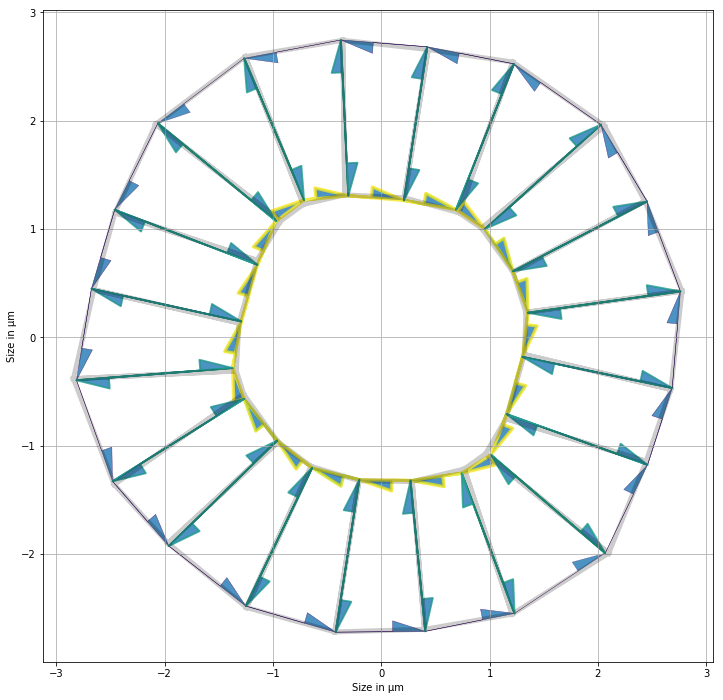

In [35]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
matrix = matrix[:-1]
constant = constant[:-1]
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
#avg_cste = [2.44/(3*organo.Nf)*4]*organo.Nf
print(avg_cste)
#avg_cste = np.multiply(np.array(avg_cste), polar_coefs)
#area_ela_line = np.concatenate((np.zeros(organo.Nf*3),
#                                np.ones(organo.Nf),
#                                [0]))
#matrix = np.vstack((matrix, area_ela_line))
#constant = np.concatenate((constant, [-params_in_sym_mesh[0]*organo.Nf]))
print(params_in_sym_mesh[0]*organo.Nf)
print(avg_cste)
for i in range(organo.Nf):
    i_cell_line = np.zeros(4*organo.Nf+1)
    index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
    index_suiv = np.squeeze(np.argwhere(organo.edge_df.face.values == (i+1)%organo.Nf))
    index[-1] = index_suiv[-2]
    #index[-1] = 40
    #print(index)
    i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
    #print(i_cell_line)
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
print(matrix.shape, constant.shape)
mat_eq_cst, residuals = nnls(matrix, constant)
organo_eq_cst = organo.copy()
organo_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_eq_cst,
                                                                 mat_eq_cst[:3*organo.Nf])
organo_eq_cst.face_df.loc[:, 'prefered_area'] = organo_eq_cst.face_df.area + mat_eq_cst[3*organo.Nf:
                                                                                          4*organo.Nf]
organo_eq_cst.settings['lumen_prefered_vol'] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo_eq_cst, geom, model)
print_tensions(organo_eq_cst, organo)
print(mat_eq_cst[organo.apical_edges])
print('Apical tensions: ', mat_eq_cst[organo.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo.lateral_edges[:organo.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance from th org to exp org: ', np.sum(np.linalg.norm(_distance(organo_eq_cst, organo), axis=1)),
      '\nNNLS residuals: ', residuals)

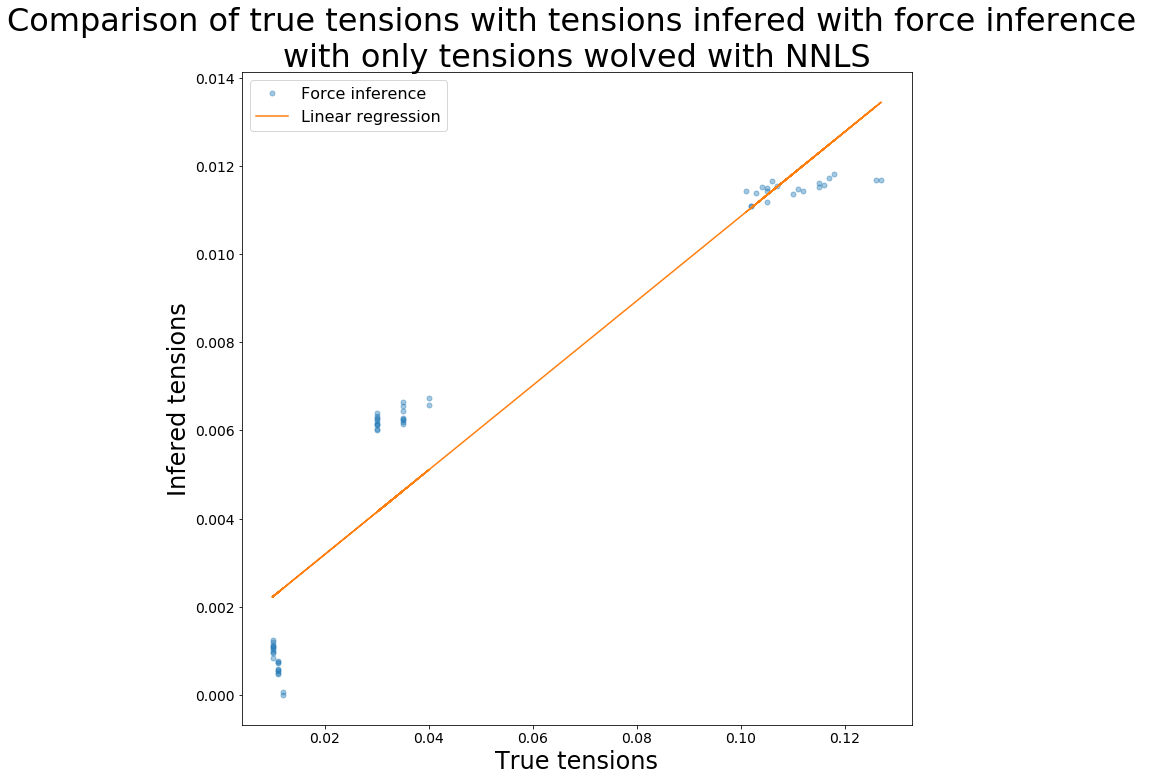

R value : 0.9420784996371543 
Standard error : 0.0012707239616727222


In [29]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  mat_eq_cst[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [30]:
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
start_copy = time.time()
iprint_file = "../../assets/dist_at_each_f_ev/14_03_eq_t_per_cell_new_criteria.txt"
to_opt_organo = organo.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas_copy = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    COPY_OR_SYM='copy',                                    
                                    **lm_opt)
end_copy = time.time()
print('Execution time: ', start_copy - end_copy)

1.067086668553904 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055911 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.067086679215965 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993419 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191057
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055912 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.067086684615343 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055912 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.0670866744135354 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055911 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.0670866688489307 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055911 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.0670866684282596 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055911 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.06708666876819 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055911 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.0670866689556864 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055911 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.0670866646407617 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063332
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055911 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.0670866652392426 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055912 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.0670866721585006 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015556
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055911 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009273 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.067086668553904 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055911 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.067086668553904 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055911 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.067086668553904 [0.02884061 0.04258589 0.04930784 0.04441205 0.02032695 0.01063333
 0.01599835 0.01479829 0.03993418 0.04194805 0.02784358 0.04178244
 0.04112463 0.04061637 0.03406544 0.02772175 0.03720067 0.03015555
 0.00616589 0.01746827 0.01753478 0.03490451 0.03164216 0.02191056
 0.01871953 0.00762433 0.01402404 0.02723742 0.03057489 0.03152037
 0.02298371 0.02698477 0.02055911 0.01792648 0.01708349 0.02486561
 0.01958825 0.03299878 0.02009272 0.01538103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.067085797150765 [0.02884058 0.04258586 0.04930782 0.04441202 0.02032692 0.0106333
 0.01599835 0.01479828 0.03993416 0.04194803 0.02784355 0.04178239
 0.04112461 0.04061635 0.03406541 0.02772171 0.03720065 0.03015554
 0.00616588 0.01746828 0.01753477 0.03490448 0.03164213 0.02191055
 0.01871952 0.00762432 0.01402401 0.02723739 0.03057486 0.03152033
 0.02298369 0.02698475 0.0205591  0.01792647 0.01708348 0.02486559
 0.01958823 0.03299874 0.02009271 0.015381   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.0670837104746491 [0.02884053 0.04258577 0.04930773 0.04441195 0.02032688 0.01063329
 0.01599832 0.01479826 0.03993408 0.04194796 0.0278435  0.04178231
 0.04112454 0.04061628 0.03406534 0.02772167 0.03720056 0.03015547
 0.00616587 0.01746824 0.01753473 0.03490441 0.03164206 0.02191049
 0.01871948 0.0076243  0.01402398 0.02723733 0.03057479 0.03152026
 0.02298364 0.0269847  0.02055905 0.01792642 0.01708345 0.02486555
 0.0195882  0.03299868 0.02009267 0.01538097 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.0670859974039195 [0.02884059 0.04258586 0.04930783 0.04441203 0.02032693 0.01063331
 0.01599835 0.01479828 0.03993416 0.04194804 0.02784355 0.0417824
 0.04112462 0.04061635 0.03406542 0.02772172 0.03720065 0.03015554
 0.00616588 0.01746828 0.01753477 0.03490449 0.03164214 0.02191055
 0.01871952 0.00762432 0.01402402 0.0272374  0.03057486 0.03152034
 0.0229837  0.02698475 0.0205591  0.01792647 0.01708348 0.0248656
 0.01958824 0.03299875 0.02009271 0.01538101 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.0670869627981832 [0.02884062 0.0425859  0.04930787 0.04441207 0.02032695 0.01063332
 0.01599836 0.01479829 0.0399342  0.04194807 0.02784358 0.04178244
 0.04112465 0.04061639 0.03406545 0.02772175 0.03720069 0.03015557
 0.00616589 0.01746828 0.01753479 0.03490452 0.03164217 0.02191057
 0.01871954 0.00762433 0.01402403 0.02723742 0.03057489 0.03152037
 0.02298372 0.02698478 0.02055912 0.01792649 0.0170835  0.02486562
 0.01958825 0.03299878 0.02009273 0.01538102 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5543605386532052 [1.11299069e-02 1.94177288e-02 1.91511757e-02 1.31841685e-02
 1.92048362e-02 6.84791054e-03 9.42955292e-03 5.13204629e-03
 1.23277614e-02 1.55524674e-02 8.01526360e-03 1.96901470e-02
 1.50006637e-02 2.11046368e-02 3.51939182e-02 3.44772320e-02
 2.69543481e-02 9.88915653e-03 5.54674105e-03 9.23596818e-03
 1.21359329e-02 1.21579371e-02 2.01486985e-02 9.48126798e-03
 1.62240576e-02 2.22475502e-03 1.18845570e-02 9.70922509e-03
 1.23536103e-02 8.39985781e-03 1.13382627e-02 1.08109353e-02
 1.38812080e-02 8.53945118e-03 2.30087821e-02 6.22837673e-03
 2.90862281e-02 8.23273472e-03 6.92994042e-03 5.01557819e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605321181347 [1.11299068e-02 1.94177287e-02 1.91511776e-02 1.31841702e-02
 1.92048363e-02 6.84791104e-03 9.42955131e-03 5.13204443e-03
 1.23277615e-02 1.55524670e-02 8.01526344e-03 1.96901467e-02
 1.50006635e-02 2.11046365e-02 3.51939176e-02 3.44772315e-02
 2.69543477e-02 9.88915635e-03 5.54674098e-03 9.23596805e-03
 1.21359328e-02 1.21579365e-02 2.01486998e-02 9.48126918e-03
 1.62240568e-02 2.22475450e-03 1.18845557e-02 9.70922361e-03
 1.23536102e-02 8.39985786e-03 1.13382625e-02 1.08109351e-02
 1.38812078e-02 8.53945104e-03 2.30087817e-02 6.22837668e-03
 2.90862276e-02 8.23273463e-03 6.92994038e-03 5.01557804e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605495355816 [1.11299070e-02 1.94177290e-02 1.91511779e-02 1.31841703e-02
 1.92048364e-02 6.84791073e-03 9.42955288e-03 5.13204635e-03
 1.23277614e-02 1.55524677e-02 8.01526599e-03 1.96901477e-02
 1.50006638e-02 2.11046367e-02 3.51939181e-02 3.44772320e-02
 2.69543481e-02 9.88915651e-03 5.54674104e-03 9.23596815e-03
 1.21359330e-02 1.21579367e-02 2.01487001e-02 9.48126938e-03
 1.62240572e-02 2.22475484e-03 1.18845571e-02 9.70922504e-03
 1.23536105e-02 8.39985811e-03 1.13382613e-02 1.08109363e-02
 1.38812085e-02 8.53945126e-03 2.30087820e-02 6.22837675e-03
 2.90862280e-02 8.23273473e-03 6.92994046e-03 5.01557810e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.554360551839025 [1.11299070e-02 1.94177291e-02 1.91511780e-02 1.31841703e-02
 1.92048365e-02 6.84791075e-03 9.42955293e-03 5.13204630e-03
 1.23277614e-02 1.55524674e-02 8.01526365e-03 1.96901471e-02
 1.50006638e-02 2.11046373e-02 3.51939185e-02 3.44772346e-02
 2.69543484e-02 9.88915645e-03 5.54674108e-03 9.23596817e-03
 1.21359331e-02 1.21579367e-02 2.01487002e-02 9.48126942e-03
 1.62240573e-02 2.22475485e-03 1.18845572e-02 9.70922514e-03
 1.23536103e-02 8.39985781e-03 1.13382627e-02 1.08109353e-02
 1.38812082e-02 8.53945081e-03 2.30087828e-02 6.22837693e-03
 2.90862287e-02 8.23273488e-03 6.92994042e-03 5.01557811e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.5543605369322214 [1.11299067e-02 1.94177290e-02 1.91511778e-02 1.31841702e-02
 1.92048362e-02 6.84791065e-03 9.42955281e-03 5.13204624e-03
 1.23277612e-02 1.55524671e-02 8.01526353e-03 1.96901468e-02
 1.50006636e-02 2.11046366e-02 3.51939177e-02 3.44772316e-02
 2.69543479e-02 9.88915681e-03 5.54674013e-03 9.23596650e-03
 1.21359323e-02 1.21579364e-02 2.01486998e-02 9.48126928e-03
 1.62240570e-02 2.22475481e-03 1.18845570e-02 9.70922501e-03
 1.23536101e-02 8.39985768e-03 1.13382626e-02 1.08109352e-02
 1.38812079e-02 8.53945106e-03 2.30087818e-02 6.22837664e-03
 2.90862278e-02 8.23273434e-03 6.92994005e-03 5.01557901e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605455532982 [1.11299070e-02 1.94177290e-02 1.91511781e-02 1.31841703e-02
 1.92048364e-02 6.84791071e-03 9.42955292e-03 5.13204624e-03
 1.23277613e-02 1.55524673e-02 8.01526361e-03 1.96901471e-02
 1.50006636e-02 2.11046368e-02 3.51939182e-02 3.44772320e-02
 2.69543480e-02 9.88915648e-03 5.54674097e-03 9.23596809e-03
 1.21359330e-02 1.21579367e-02 2.01487004e-02 9.48126967e-03
 1.62240572e-02 2.22475485e-03 1.18845571e-02 9.70922508e-03
 1.23536103e-02 8.39985780e-03 1.13382627e-02 1.08109353e-02
 1.38812080e-02 8.53945115e-03 2.30087820e-02 6.22837672e-03
 2.90862280e-02 8.23273472e-03 6.92994042e-03 5.01557812e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605433438572 [1.11299070e-02 1.94177289e-02 1.91511778e-02 1.31841702e-02
 1.92048363e-02 6.84791070e-03 9.42955291e-03 5.13204623e-03
 1.23277613e-02 1.55524673e-02 8.01526359e-03 1.96901470e-02
 1.50006636e-02 2.11046368e-02 3.51939181e-02 3.44772319e-02
 2.69543480e-02 9.88915646e-03 5.54674096e-03 9.23596807e-03
 1.21359329e-02 1.21579366e-02 2.01487000e-02 9.48126933e-03
 1.62240572e-02 2.22475484e-03 1.18845571e-02 9.70922507e-03
 1.23536103e-02 8.39985778e-03 1.13382626e-02 1.08109352e-02
 1.38812080e-02 8.53945113e-03 2.30087819e-02 6.22837671e-03
 2.90862279e-02 8.23273471e-03 6.92994041e-03 5.01557811e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605436926002 [1.11299070e-02 1.94177289e-02 1.91511778e-02 1.31841702e-02
 1.92048363e-02 6.84791071e-03 9.42955289e-03 5.13204623e-03
 1.23277613e-02 1.55524673e-02 8.01526339e-03 1.96901471e-02
 1.50006636e-02 2.11046368e-02 3.51939181e-02 3.44772319e-02
 2.69543480e-02 9.88915646e-03 5.54674097e-03 9.23596808e-03
 1.21359330e-02 1.21579366e-02 2.01487000e-02 9.48126934e-03
 1.62240572e-02 2.22475484e-03 1.18845571e-02 9.70922506e-03
 1.23536103e-02 8.39985780e-03 1.13382629e-02 1.08109352e-02
 1.38812080e-02 8.53945114e-03 2.30087820e-02 6.22837671e-03
 2.90862280e-02 8.23273471e-03 6.92994041e-03 5.01557811e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605432470682 [1.11299070e-02 1.94177289e-02 1.91511778e-02 1.31841702e-02
 1.92048363e-02 6.84791070e-03 9.42955289e-03 5.13204623e-03
 1.23277613e-02 1.55524673e-02 8.01526359e-03 1.96901470e-02
 1.50006636e-02 2.11046368e-02 3.51939181e-02 3.44772318e-02
 2.69543480e-02 9.88915645e-03 5.54674096e-03 9.23596807e-03
 1.21359329e-02 1.21579366e-02 2.01487000e-02 9.48126933e-03
 1.62240572e-02 2.22475484e-03 1.18845571e-02 9.70922506e-03
 1.23536103e-02 8.39985778e-03 1.13382626e-02 1.08109352e-02
 1.38812080e-02 8.53945112e-03 2.30087819e-02 6.22837675e-03
 2.90862280e-02 8.23273471e-03 6.92994041e-03 5.01557811e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605429740193 [1.11299070e-02 1.94177289e-02 1.91511778e-02 1.31841702e-02
 1.92048363e-02 6.84791070e-03 9.42955289e-03 5.13204622e-03
 1.23277613e-02 1.55524673e-02 8.01526359e-03 1.96901470e-02
 1.50006636e-02 2.11046368e-02 3.51939181e-02 3.44772319e-02
 2.69543479e-02 9.88915647e-03 5.54674093e-03 9.23596809e-03
 1.21359329e-02 1.21579366e-02 2.01487000e-02 9.48126933e-03
 1.62240572e-02 2.22475483e-03 1.18845570e-02 9.70922505e-03
 1.23536102e-02 8.39985777e-03 1.13382626e-02 1.08109352e-02
 1.38812080e-02 8.53945113e-03 2.30087819e-02 6.22837671e-03
 2.90862279e-02 8.23273469e-03 6.92994051e-03 5.01557799e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605457672373 [1.11299073e-02 1.94177293e-02 1.91511795e-02 1.31841704e-02
 1.92048365e-02 6.84791083e-03 9.42955292e-03 5.13204618e-03
 1.23277613e-02 1.55524673e-02 8.01526363e-03 1.96901471e-02
 1.50006636e-02 2.11046368e-02 3.51939182e-02 3.44772320e-02
 2.69543480e-02 9.88915645e-03 5.54674090e-03 9.23596795e-03
 1.21359332e-02 1.21579360e-02 2.01486997e-02 9.48126918e-03
 1.62240570e-02 2.22475475e-03 1.18845571e-02 9.70922506e-03
 1.23536103e-02 8.39985782e-03 1.13382627e-02 1.08109352e-02
 1.38812081e-02 8.53945115e-03 2.30087820e-02 6.22837670e-03
 2.90862281e-02 8.23273474e-03 6.92994042e-03 5.01557799e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.554360539467483 [1.11299071e-02 1.94177289e-02 1.91511778e-02 1.31841700e-02
 1.92048359e-02 6.84790991e-03 9.42955172e-03 5.13204626e-03
 1.23277609e-02 1.55524673e-02 8.01526365e-03 1.96901471e-02
 1.50006635e-02 2.11046367e-02 3.51939181e-02 3.44772319e-02
 2.69543479e-02 9.88915642e-03 5.54674088e-03 9.23596800e-03
 1.21359329e-02 1.21579366e-02 2.01487000e-02 9.48126944e-03
 1.62240574e-02 2.22475542e-03 1.18845559e-02 9.70922485e-03
 1.23536102e-02 8.39985764e-03 1.13382627e-02 1.08109352e-02
 1.38812080e-02 8.53945111e-03 2.30087819e-02 6.22837666e-03
 2.90862280e-02 8.23273470e-03 6.92994037e-03 5.01557814e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.5543605378074971 [1.11299071e-02 1.94177288e-02 1.91511777e-02 1.31841701e-02
 1.92048362e-02 6.84791067e-03 9.42955294e-03 5.13204599e-03
 1.23277611e-02 1.55524662e-02 8.01526331e-03 1.96901476e-02
 1.50006633e-02 2.11046368e-02 3.51939180e-02 3.44772318e-02
 2.69543477e-02 9.88915638e-03 5.54674084e-03 9.23596795e-03
 1.21359328e-02 1.21579366e-02 2.01486999e-02 9.48126926e-03
 1.62240571e-02 2.22475485e-03 1.18845570e-02 9.70922514e-03
 1.23536098e-02 8.39985703e-03 1.13382613e-02 1.08109363e-02
 1.38812076e-02 8.53945100e-03 2.30087818e-02 6.22837664e-03
 2.90862279e-02 8.23273467e-03 6.92994033e-03 5.01557813e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605364455698 [1.11299070e-02 1.94177288e-02 1.91511778e-02 1.31841701e-02
 1.92048362e-02 6.84791069e-03 9.42955291e-03 5.13204615e-03
 1.23277612e-02 1.55524672e-02 8.01526358e-03 1.96901471e-02
 1.50006635e-02 2.11046360e-02 3.51939158e-02 3.44772312e-02
 2.69543477e-02 9.88915647e-03 5.54674086e-03 9.23596800e-03
 1.21359329e-02 1.21579366e-02 2.01486999e-02 9.48126928e-03
 1.62240571e-02 2.22475484e-03 1.18845570e-02 9.70922502e-03
 1.23536102e-02 8.39985779e-03 1.13382626e-02 1.08109352e-02
 1.38812077e-02 8.53945176e-03 2.30087798e-02 6.22837728e-03
 2.90862276e-02 8.23273461e-03 6.92994040e-03 5.01557814e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605443648872 [1.11299073e-02 1.94177288e-02 1.91511778e-02 1.31841701e-02
 1.92048363e-02 6.84791072e-03 9.42955295e-03 5.13204614e-03
 1.23277612e-02 1.55524673e-02 8.01526362e-03 1.96901471e-02
 1.50006635e-02 2.11046368e-02 3.51939183e-02 3.44772321e-02
 2.69543478e-02 9.88915547e-03 5.54674386e-03 9.23596808e-03
 1.21359333e-02 1.21579368e-02 2.01487001e-02 9.48126931e-03
 1.62240572e-02 2.22475485e-03 1.18845570e-02 9.70922504e-03
 1.23536103e-02 8.39985784e-03 1.13382626e-02 1.08109352e-02
 1.38812081e-02 8.53945115e-03 2.30087820e-02 6.22837680e-03
 2.90862278e-02 8.23273540e-03 6.92993818e-03 5.01557794e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605433003373 [1.11299070e-02 1.94177289e-02 1.91511778e-02 1.31841702e-02
 1.92048363e-02 6.84791070e-03 9.42955289e-03 5.13204622e-03
 1.23277613e-02 1.55524673e-02 8.01526359e-03 1.96901470e-02
 1.50006636e-02 2.11046368e-02 3.51939181e-02 3.44772319e-02
 2.69543480e-02 9.88915646e-03 5.54674096e-03 9.23596807e-03
 1.21359329e-02 1.21579366e-02 2.01487000e-02 9.48126933e-03
 1.62240572e-02 2.22475484e-03 1.18845571e-02 9.70922506e-03
 1.23536103e-02 8.39985778e-03 1.13382626e-02 1.08109352e-02
 1.38812080e-02 8.53945113e-03 2.30087819e-02 6.22837671e-03
 2.90862279e-02 8.23273471e-03 6.92994041e-03 5.01557811e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605433003373 [1.11299070e-02 1.94177289e-02 1.91511778e-02 1.31841702e-02
 1.92048363e-02 6.84791070e-03 9.42955289e-03 5.13204622e-03
 1.23277613e-02 1.55524673e-02 8.01526359e-03 1.96901470e-02
 1.50006636e-02 2.11046368e-02 3.51939181e-02 3.44772319e-02
 2.69543480e-02 9.88915646e-03 5.54674096e-03 9.23596807e-03
 1.21359329e-02 1.21579366e-02 2.01487000e-02 9.48126933e-03
 1.62240572e-02 2.22475484e-03 1.18845571e-02 9.70922506e-03
 1.23536103e-02 8.39985778e-03 1.13382626e-02 1.08109352e-02
 1.38812080e-02 8.53945113e-03 2.30087819e-02 6.22837671e-03
 2.90862279e-02 8.23273471e-03 6.92994041e-03 5.01557811e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605433003373 [1.11299070e-02 1.94177289e-02 1.91511778e-02 1.31841702e-02
 1.92048363e-02 6.84791070e-03 9.42955289e-03 5.13204622e-03
 1.23277613e-02 1.55524673e-02 8.01526359e-03 1.96901470e-02
 1.50006636e-02 2.11046368e-02 3.51939181e-02 3.44772319e-02
 2.69543480e-02 9.88915646e-03 5.54674096e-03 9.23596807e-03
 1.21359329e-02 1.21579366e-02 2.01487000e-02 9.48126933e-03
 1.62240572e-02 2.22475484e-03 1.18845571e-02 9.70922506e-03
 1.23536103e-02 8.39985778e-03 1.13382626e-02 1.08109352e-02
 1.38812080e-02 8.53945113e-03 2.30087819e-02 6.22837671e-03
 2.90862279e-02 8.23273471e-03 6.92994041e-03 5.01557811e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605433003373 [1.11299070e-02 1.94177289e-02 1.91511778e-02 1.31841702e-02
 1.92048363e-02 6.84791070e-03 9.42955289e-03 5.13204622e-03
 1.23277613e-02 1.55524673e-02 8.01526359e-03 1.96901470e-02
 1.50006636e-02 2.11046368e-02 3.51939181e-02 3.44772319e-02
 2.69543480e-02 9.88915646e-03 5.54674096e-03 9.23596807e-03
 1.21359329e-02 1.21579366e-02 2.01487000e-02 9.48126933e-03
 1.62240572e-02 2.22475484e-03 1.18845571e-02 9.70922506e-03
 1.23536103e-02 8.39985778e-03 1.13382626e-02 1.08109352e-02
 1.38812080e-02 8.53945113e-03 2.30087819e-02 6.22837671e-03
 2.90862279e-02 8.23273471e-03 6.92994041e-03 5.01557811e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605433003373 [1.11299070e-02 1.94177289e-02 1.91511778e-02 1.31841702e-02
 1.92048363e-02 6.84791070e-03 9.42955289e-03 5.13204622e-03
 1.23277613e-02 1.55524673e-02 8.01526359e-03 1.96901470e-02
 1.50006636e-02 2.11046368e-02 3.51939181e-02 3.44772319e-02
 2.69543480e-02 9.88915646e-03 5.54674096e-03 9.23596807e-03
 1.21359329e-02 1.21579366e-02 2.01487000e-02 9.48126933e-03
 1.62240572e-02 2.22475484e-03 1.18845571e-02 9.70922506e-03
 1.23536103e-02 8.39985778e-03 1.13382626e-02 1.08109352e-02
 1.38812080e-02 8.53945113e-03 2.30087819e-02 6.22837671e-03
 2.90862279e-02 8.23273471e-03 6.92994041e-03 5.01557811e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543592623354662 [1.11298753e-02 1.94176855e-02 1.91511339e-02 1.31841418e-02
 1.92047935e-02 6.84789759e-03 9.42953406e-03 5.13203634e-03
 1.23277335e-02 1.55524269e-02 8.01524747e-03 1.96900939e-02
 1.50006358e-02 2.11045888e-02 3.51938299e-02 3.44771525e-02
 2.69542887e-02 9.88912961e-03 5.54672966e-03 9.23595345e-03
 1.21359040e-02 1.21579079e-02 2.01486526e-02 9.48124962e-03
 1.62240184e-02 2.22474618e-03 1.18845261e-02 9.70920538e-03
 1.23535797e-02 8.39983410e-03 1.13382409e-02 1.08109103e-02
 1.38811759e-02 8.53942934e-03 2.30087262e-02 6.22836653e-03
 2.90861525e-02 8.23271817e-03 6.92992981e-03 5.01556826e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543614245966625 [1.11299282e-02 1.94177594e-02 1.91512089e-02 1.31841892e-02
 1.92048664e-02 6.84791854e-03 9.42957045e-03 5.13205313e-03
 1.23277798e-02 1.55524947e-02 8.01527542e-03 1.96901827e-02
 1.50006830e-02 2.11046697e-02 3.51939780e-02 3.44772857e-02
 2.69543887e-02 9.88917496e-03 5.54674884e-03 9.23597853e-03
 1.21359534e-02 1.21579552e-02 2.01487320e-02 9.48128347e-03
 1.62240827e-02 2.22476162e-03 1.18845782e-02 9.70923811e-03
 1.23536311e-02 8.39987276e-03 1.13382786e-02 1.08109529e-02
 1.38812289e-02 8.53946592e-03 2.30088209e-02 6.22838463e-03
 2.90862784e-02 8.23274582e-03 6.92994862e-03 5.01558434e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543603074748514 [1.11299009e-02 1.94177208e-02 1.91511696e-02 1.31841655e-02
 1.92048280e-02 6.84790825e-03 9.42954882e-03 5.13204408e-03
 1.23277562e-02 1.55524580e-02 8.01525638e-03 1.96901394e-02
 1.50006584e-02 2.11046279e-02 3.51939014e-02 3.44772173e-02
 2.69543374e-02 9.88915181e-03 5.54673902e-03 9.23596578e-03
 1.21359284e-02 1.21579316e-02 2.01486915e-02 9.48126587e-03
 1.62240506e-02 2.22475307e-03 1.18845520e-02 9.70922271e-03
 1.23536040e-02 8.39985287e-03 1.13382581e-02 1.08109346e-02
 1.38812012e-02 8.53944700e-03 2.30087723e-02 6.22837557e-03
 2.90862128e-02 8.23273126e-03 6.92993920e-03 5.01557566e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543605111736415 [1.11299058e-02 1.94177272e-02 1.91511773e-02 1.31841698e-02
 1.92048351e-02 6.84791031e-03 9.42955229e-03 5.13204664e-03
 1.23277611e-02 1.55524665e-02 8.01526304e-03 1.96901450e-02
 1.50006631e-02 2.11046343e-02 3.51939184e-02 3.44772248e-02
 2.69543460e-02 9.88915581e-03 5.54674113e-03 9.23596805e-03
 1.21359326e-02 1.21579365e-02 2.01486982e-02 9.48126870e-03
 1.62240562e-02 2.22475448e-03 1.18845563e-02 9.70922407e-03
 1.23536089e-02 8.39985675e-03 1.13382620e-02 1.08109347e-02
 1.38812063e-02 8.53945148e-03 2.30087840e-02 6.22837855e-03
 2.90862251e-02 8.23273417e-03 6.92994050e-03 5.01557763e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5543616501726544 [1.11299337e-02 1.94177673e-02 1.91512170e-02 1.31841945e-02
 1.92048746e-02 6.84792256e-03 9.42956917e-03 5.13205513e-03
 1.23277856e-02 1.55525026e-02 8.01527714e-03 1.96901924e-02
 1.50006880e-02 2.11046783e-02 3.51939937e-02 3.44773008e-02
 2.69543994e-02 9.88917907e-03 5.54674873e-03 9.23598067e-03
 1.21359588e-02 1.21579604e-02 2.01487406e-02 9.48128663e-03
 1.62240894e-02 2.22476170e-03 1.18845840e-02 9.70924226e-03
 1.23536358e-02 8.39987724e-03 1.13382815e-02 1.08109577e-02
 1.38812351e-02 8.53947002e-03 2.30088307e-02 6.22838622e-03
 2.90862924e-02 8.23274966e-03 6.92995153e-03 5.01558591e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.05386624527181 [1.52880349e-03 2.05409856e-03 1.36597968e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501144e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777517e-04 9.00122421e-04 5.22868190e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545806e-04 8.48108860e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810429e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

0.05386624527509447 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000521e-03 1.77723494e-03 1.63108525e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501144e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122402e-04 5.22868198e-04 1.26252652e-04
 6.03579809e-04 5.89249407e-04 7.16647259e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545806e-04 8.48108859e-04 1.34367625e-03 9.75676953e-04
 1.76570163e-03 1.84462166e-03 4.74429616e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.053866245218747236 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000522e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501143e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777514e-04 9.00122401e-04 5.22868197e-04 1.26252659e-04
 6.03579786e-04 5.89249413e-04 7.16647267e-04 3.95844075e-04
 1.10769316e-03 1.13361727e-03 4.30768615e-04 7.39748884e-04
 1.66545805e-04 8.48108858e-04 1.34367625e-03 9.75676952e-04
 1.76570163e-03 1.84462166e-03 4.74429615e-04 5.80810435e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.05386624524446626 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712451e-03
 1.73038207e-03 1.15561749e-03 9.20501148e-04 2.09653545e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777516e-04 9.00122402e-04 5.22868199e-04 1.26252661e-04
 6.03579787e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748886e-04
 1.66545799e-04 8.48108854e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429618e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386624522705094 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629611e-03
 2.34000522e-03 1.77723494e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501143e-04 2.09653545e-03
 2.98045134e-03 2.58316199e-03 1.98890224e-03 1.56882590e-03
 9.63777513e-04 9.00122400e-04 5.22868196e-04 1.26252659e-04
 6.03579785e-04 5.89249413e-04 7.16647266e-04 3.95844076e-04
 1.10769319e-03 1.13361729e-03 4.30768615e-04 7.39748883e-04
 1.66545804e-04 8.48108857e-04 1.34367625e-03 9.75676957e-04
 1.76570161e-03 1.84462164e-03 4.74429619e-04 5.80810434e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.053866245289333675 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501143e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122398e-04 5.22868198e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545806e-04 8.48108860e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810435e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.05386624528923213 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501143e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122402e-04 5.22868198e-04 1.26252660e-04
 6.03579781e-04 5.89249416e-04 7.16647267e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545806e-04 8.48108860e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386624529925246 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501143e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122402e-04 5.22868198e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545806e-04 8.48108860e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429616e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386624531314719 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038211e-03 1.15561751e-03 9.20501144e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777516e-04 9.00122402e-04 5.22868199e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545812e-04 8.48108864e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386624529659432 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501143e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122402e-04 5.22868198e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545806e-04 8.48108859e-04 1.34367625e-03 9.75676954e-04
 1.76570164e-03 1.84462167e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.053866245256169454 [1.52880357e-03 2.05409857e-03 1.36597967e-03 1.84629612e-03
 2.34000522e-03 1.77723494e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501141e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777448e-04 9.00122409e-04 5.22868198e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647267e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748884e-04
 1.66545807e-04 8.48108859e-04 1.34367625e-03 9.75676953e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810442e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.05386624532775312 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629611e-03
 2.34000530e-03 1.77723494e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501142e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122402e-04 5.22868199e-04 1.26252668e-04
 6.03579766e-04 5.89249415e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545807e-04 8.48108860e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386624537277453 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159327e-03 1.79212975e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501142e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777516e-04 9.00122402e-04 5.22868199e-04 1.26252660e-04
 6.03579787e-04 5.89249414e-04 7.16647268e-04 3.95844079e-04
 1.10769323e-03 1.13361728e-03 4.30768616e-04 7.39748885e-04
 1.66545807e-04 8.48108860e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.053866245283225735 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000522e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038217e-03 1.15561751e-03 9.20501142e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122402e-04 5.22868199e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748884e-04
 1.66545754e-04 8.48108861e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.05386624540233998 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501142e-04 2.09653544e-03
 2.98045139e-03 2.58316197e-03 1.98890224e-03 1.56882590e-03
 9.63777516e-04 9.00122403e-04 5.22868199e-04 1.26252661e-04
 6.03579787e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545807e-04 8.48108860e-04 1.34367625e-03 9.75676950e-04
 1.76570170e-03 1.84462165e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386624529546033 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501143e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122402e-04 5.22868199e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545806e-04 8.48108860e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386624529546033 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501143e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122402e-04 5.22868199e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545806e-04 8.48108860e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386624529546033 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501143e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122402e-04 5.22868199e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545806e-04 8.48108860e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386624529546033 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501143e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122402e-04 5.22868199e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545806e-04 8.48108860e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386624529546033 [1.52880351e-03 2.05409858e-03 1.36597967e-03 1.84629612e-03
 2.34000523e-03 1.77723495e-03 1.63108524e-03 1.99682668e-03
 2.18159321e-03 1.79212976e-03 2.22620529e-03 1.84712450e-03
 1.73038210e-03 1.15561751e-03 9.20501143e-04 2.09653544e-03
 2.98045133e-03 2.58316198e-03 1.98890224e-03 1.56882590e-03
 9.63777515e-04 9.00122402e-04 5.22868199e-04 1.26252660e-04
 6.03579786e-04 5.89249414e-04 7.16647268e-04 3.95844078e-04
 1.10769319e-03 1.13361729e-03 4.30768616e-04 7.39748885e-04
 1.66545806e-04 8.48108860e-04 1.34367625e-03 9.75676954e-04
 1.76570163e-03 1.84462166e-03 4.74429617e-04 5.80810436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386625675530708 [1.52880217e-03 2.05409718e-03 1.36597938e-03 1.84629629e-03
 2.34000546e-03 1.77723515e-03 1.63108543e-03 1.99682688e-03
 2.18159341e-03 1.79212993e-03 2.22620552e-03 1.84712472e-03
 1.73038227e-03 1.15561765e-03 9.20501320e-04 2.09653567e-03
 2.98045157e-03 2.58316221e-03 1.98890243e-03 1.56882597e-03
 9.63780774e-04 9.00127273e-04 5.22869538e-04 1.26252650e-04
 6.03579808e-04 5.89249434e-04 7.16647294e-04 3.95844082e-04
 1.10769326e-03 1.13361737e-03 4.30768634e-04 7.39748915e-04
 1.66545789e-04 8.48108881e-04 1.34367629e-03 9.75676983e-04
 1.76570175e-03 1.84462179e-03 4.74429606e-04 5.80811649e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386625401342779 [1.52880371e-03 2.05409880e-03 1.36597982e-03 1.84629592e-03
 2.34000366e-03 1.77723273e-03 1.63108512e-03 1.99682689e-03
 2.18159342e-03 1.79212993e-03 2.22620553e-03 1.84712472e-03
 1.73038228e-03 1.15561765e-03 9.20501308e-04 2.09653568e-03
 2.98045158e-03 2.58316221e-03 1.98890244e-03 1.56882607e-03
 9.63777561e-04 9.00122448e-04 5.22868217e-04 1.26253985e-04
 6.03584086e-04 5.89251214e-04 7.16648729e-04 3.95844093e-04
 1.10769326e-03 1.13361736e-03 4.30768639e-04 7.39748924e-04
 1.66545803e-04 8.48108898e-04 1.34367631e-03 9.75677000e-04
 1.76570175e-03 1.84462178e-03 4.74429627e-04 5.80810462e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.053866240297148094 [1.52880381e-03 2.05409899e-03 1.36597995e-03 1.84629652e-03
 2.34000571e-03 1.77723531e-03 1.63108557e-03 1.99682647e-03
 2.18159084e-03 1.79212724e-03 2.22620514e-03 1.84712477e-03
 1.73038240e-03 1.15561775e-03 9.20501263e-04 2.09653593e-03
 2.98045175e-03 2.58316224e-03 1.98890273e-03 1.56882620e-03
 9.63777782e-04 9.00122607e-04 5.22868438e-04 1.26252796e-04
 6.03579932e-04 5.89249560e-04 7.16647433e-04 3.95844554e-04
 1.10768856e-03 1.13361299e-03 4.30768740e-04 7.39749035e-04
 1.66546014e-04 8.48109123e-04 1.34367661e-03 9.75677223e-04
 1.76570169e-03 1.84462168e-03 4.74429923e-04 5.80810618e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.05386624432094561 [1.52880349e-03 2.05409851e-03 1.36597962e-03 1.84629602e-03
 2.34000513e-03 1.77723489e-03 1.63108520e-03 1.99682654e-03
 2.18159319e-03 1.79212979e-03 2.22620514e-03 1.84712354e-03
 1.73038218e-03 1.15561632e-03 9.20500603e-04 2.09653532e-03
 2.98045133e-03 2.58316210e-03 1.98890207e-03 1.56882586e-03
 9.63777362e-04 9.00122304e-04 5.22868018e-04 1.26252536e-04
 6.03579712e-04 5.89249339e-04 7.16647188e-04 3.95843960e-04
 1.10769333e-03 1.13361741e-03 4.30768582e-04 7.39748640e-04
 1.66547280e-04 8.48110852e-04 1.34367641e-03 9.75676799e-04
 1.76570179e-03 1.84462188e-03 4.74429361e-04 5.80810322e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386624196139285 [1.52880394e-03 2.05409920e-03 1.36598009e-03 1.84629673e-03
 2.34000595e-03 1.77723549e-03 1.63108574e-03 1.99682740e-03
 2.18159373e-03 1.79213010e-03 2.22620609e-03 1.84712486e-03
 1.73038254e-03 1.15561787e-03 9.20501280e-04 2.09653540e-03
 2.98044874e-03 2.58315904e-03 1.98890241e-03 1.56882635e-03
 9.63777958e-04 9.00122734e-04 5.22868613e-04 1.26252905e-04
 6.03580025e-04 5.89249652e-04 7.16647535e-04 3.95844359e-04
 1.10769312e-03 1.13361728e-03 4.30768751e-04 7.39749125e-04
 1.66546181e-04 8.48109302e-04 1.34367685e-03 9.75676603e-04
 1.76569673e-03 1.84461677e-03 4.74429370e-04 5.80810742e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.05386647364816301 [1.52881499e-03 2.05411051e-03 1.36598727e-03 1.84630556e-03
 2.34001745e-03 1.77724632e-03 1.63109536e-03 1.99683826e-03
 2.18160221e-03 1.79213705e-03 2.22621833e-03 1.84713487e-03
 1.73038975e-03 1.15562536e-03 9.20511167e-04 2.09654843e-03
 2.98045984e-03 2.58316924e-03 1.98891375e-03 1.56883519e-03
 9.63779952e-04 9.00124323e-04 5.22870209e-04 1.26254476e-04
 6.03580888e-04 5.89251048e-04 7.16648852e-04 3.95845855e-04
 1.10769252e-03 1.13361688e-03 4.30770139e-04 7.39750666e-04
 1.66548025e-04 8.48111035e-04 1.34367923e-03 9.75678966e-04
 1.76570065e-03 1.84462056e-03 4.74431749e-04 5.80812308e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.04931761318352404 [1.58929128e-03 1.92468551e-03 1.28213796e-03 1.64545742e-03
 2.10561528e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274258e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171104e-04 4.28878160e-04 2.24862268e-04
 5.77337944e-04 5.53494714e-04 6.54623558e-04 4.55637104e-04
 9.62329901e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.049317613134133485 [1.58929128e-03 1.92468551e-03 1.28213798e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086613e-03 1.79739702e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152196e-03 1.49373777e-03
 7.72678745e-04 8.49171100e-04 4.28878169e-04 2.24862261e-04
 5.77337939e-04 5.53494706e-04 6.54623547e-04 4.55637109e-04
 9.62329897e-04 1.00713108e-03 5.58885879e-04 6.81257811e-04
 1.96089092e-04 6.89602147e-04 1.02418661e-03 8.67113831e-04
 1.40494313e-03 1.64161637e-03 4.66808129e-04 5.08076702e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.04931761318137974 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088086e-03 1.96449004e-03 1.87142112e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329902e-04 1.00713108e-03 5.58885888e-04 6.81257828e-04
 1.96089089e-04 6.89602147e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.049317613191529074 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321991e-03 1.88274255e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678745e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329902e-04 1.00713108e-03 5.58885879e-04 6.81257811e-04
 1.96089092e-04 6.89602140e-04 1.02418662e-03 8.67113849e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076702e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.049317613156184936 [1.58929129e-03 1.92468551e-03 1.28213798e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777870e-03 1.70152195e-03 1.49373777e-03
 7.72678739e-04 8.49171100e-04 4.28878169e-04 2.24862261e-04
 5.77337938e-04 5.53494713e-04 6.54623557e-04 4.55637103e-04
 9.62329902e-04 1.00713108e-03 5.58885879e-04 6.81257811e-04
 1.96089092e-04 6.89602146e-04 1.02418661e-03 8.67113831e-04
 1.40494313e-03 1.64161637e-03 4.66808142e-04 5.08076697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.04931761321015742 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878173e-04 2.24862260e-04
 5.77337940e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329902e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.04931761320499631 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623559e-04 4.55637104e-04
 9.62329901e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602147e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0493176131979211 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329902e-04 1.00713108e-03 5.58885877e-04 6.81257805e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.049317613203179844 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329902e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602147e-04 1.02418661e-03 8.67113832e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.049317613202989684 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329902e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602147e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808129e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.0493176132096536 [1.58929128e-03 1.92468550e-03 1.28213805e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142115e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777870e-03 1.70152196e-03 1.49373777e-03
 7.72678746e-04 8.49171099e-04 4.28878128e-04 2.24862266e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329901e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.049317613210130555 [1.58929128e-03 1.92468551e-03 1.28213798e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086621e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142115e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777870e-03 1.70152196e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494720e-04 6.54623511e-04 4.55637108e-04
 9.62329901e-04 1.00713108e-03 5.58885879e-04 6.81257811e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.04931761321161596 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449013e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777870e-03 1.70152196e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878171e-04 2.24862262e-04
 5.77337940e-04 5.53494714e-04 6.54623558e-04 4.55637105e-04
 9.62329901e-04 1.00713108e-03 5.58885817e-04 6.81257818e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808131e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.049317613178736924 [1.58929128e-03 1.92468551e-03 1.28213798e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142115e-03
 1.58542307e-03 1.14992207e-03 1.14321998e-03 1.88274257e-03
 2.55726931e-03 2.30777870e-03 1.70152196e-03 1.49373777e-03
 7.72678745e-04 8.49171100e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329901e-04 1.00713108e-03 5.58885879e-04 6.81257811e-04
 1.96089092e-04 6.89602152e-04 1.02418656e-03 8.67113838e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076702e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.04931761320976684 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152203e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878171e-04 2.24862262e-04
 5.77337940e-04 5.53494714e-04 6.54623558e-04 4.55637105e-04
 9.62329901e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808072e-04 5.08076704e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.049317613205484265 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329902e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.049317613205484265 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329902e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.049317613205484265 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329902e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.049317613205484265 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329902e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.049317613205484265 [1.58929128e-03 1.92468551e-03 1.28213799e-03 1.64545744e-03
 2.10561527e-03 1.69263816e-03 1.54086614e-03 1.79739704e-03
 1.92089747e-03 1.61088087e-03 1.96449006e-03 1.87142116e-03
 1.58542307e-03 1.14992207e-03 1.14321993e-03 1.88274257e-03
 2.55726931e-03 2.30777871e-03 1.70152197e-03 1.49373777e-03
 7.72678746e-04 8.49171101e-04 4.28878170e-04 2.24862261e-04
 5.77337939e-04 5.53494714e-04 6.54623557e-04 4.55637104e-04
 9.62329902e-04 1.00713108e-03 5.58885880e-04 6.81257811e-04
 1.96089092e-04 6.89602148e-04 1.02418661e-03 8.67113833e-04
 1.40494313e-03 1.64161637e-03 4.66808130e-04 5.08076703e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.04931761196929802 [1.58929121e-03 1.92468490e-03 1.28213742e-03 1.64545617e-03
 2.10561469e-03 1.69263807e-03 1.54086606e-03 1.79739692e-03
 1.92089742e-03 1.61088084e-03 1.96448992e-03 1.87142110e-03
 1.58542301e-03 1.14992201e-03 1.14321991e-03 1.88274244e-03
 2.55726926e-03 2.30777872e-03 1.70152184e-03 1.49373770e-03
 7.72678646e-04 8.49170646e-04 4.28878727e-04 2.24866432e-04
 5.77337310e-04 5.53494654e-04 6.54623492e-04 4.55637038e-04
 9.62329951e-04 1.00713110e-03 5.58885827e-04 6.81257773e-04
 1.96089070e-04 6.89602042e-04 1.02418648e-03 8.67113712e-04
 1.40494320e-03 1.64161645e-03 4.66808036e-04 5.08076624e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.049317623453461086 [1.58929158e-03 1.92468585e-03 1.28213821e-03 1.64545774e-03
 2.10561565e-03 1.69263822e-03 1.54086428e-03 1.79739581e-03
 1.92089799e-03 1.61088104e-03 1.96449046e-03 1.87142142e-03
 1.58542329e-03 1.14992228e-03 1.14322011e-03 1.88274297e-03
 2.55726956e-03 2.30777884e-03 1.70152232e-03 1.49373803e-03
 7.72678911e-04 8.49171256e-04 4.28878330e-04 2.24862334e-04
 5.77338061e-04 5.53495913e-04 6.54624320e-04 4.55641061e-04
 9.62330676e-04 1.00713109e-03 5.58885972e-04 6.81257889e-04
 1.96089129e-04 6.89602317e-04 1.02418683e-03 8.67114030e-04
 1.40494309e-03 1.64161633e-03 4.66808276e-04 5.08076829e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.049317623105207486 [1.58929141e-03 1.92468563e-03 1.28213806e-03 1.64545753e-03
 2.10561540e-03 1.69263828e-03 1.54086625e-03 1.79739715e-03
 1.92089757e-03 1.61088136e-03 1.96448834e-03 1.87142098e-03
 1.58542238e-03 1.14992215e-03 1.14322005e-03 1.88274270e-03
 2.55726941e-03 2.30777881e-03 1.70152207e-03 1.49373787e-03
 7.72678741e-04 8.49171099e-04 4.28878160e-04 2.24862257e-04
 5.77337936e-04 5.53494712e-04 6.54623556e-04 4.55637100e-04
 9.62329923e-04 1.00713187e-03 5.58890107e-04 6.81262669e-04
 1.96089461e-04 6.89602141e-04 1.02418660e-03 8.67113826e-04
 1.40494316e-03 1.64161641e-03 4.66808122e-04 5.08076697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.04931762706142107 [1.58929154e-03 1.92468579e-03 1.28213817e-03 1.64545769e-03
 2.10561558e-03 1.69263843e-03 1.54086637e-03 1.79739734e-03
 1.92089765e-03 1.61088100e-03 1.96449040e-03 1.87142137e-03
 1.58542325e-03 1.14992184e-03 1.14321864e-03 1.88274130e-03
 2.55727001e-03 2.30777878e-03 1.70152226e-03 1.49373799e-03
 7.72678863e-04 8.49171207e-04 4.28878293e-04 2.24862316e-04
 5.77338025e-04 5.53494785e-04 6.54623634e-04 4.55637181e-04
 9.62329847e-04 1.00713106e-03 5.58885941e-04 6.81257857e-04
 1.96089117e-04 6.89603437e-04 1.02419145e-03 8.67118834e-04
 1.40494336e-03 1.64161629e-03 4.66808240e-04 5.08076794e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.04931762567216802 [1.58929105e-03 1.92468590e-03 1.28213824e-03 1.64545779e-03
 2.10561570e-03 1.69263852e-03 1.54086645e-03 1.79739746e-03
 1.92089772e-03 1.61088103e-03 1.96449053e-03 1.87142143e-03
 1.58542331e-03 1.14992231e-03 1.14322011e-03 1.88274303e-03
 2.55726955e-03 2.30777939e-03 1.70152060e-03 1.49373578e-03
 7.72679694e-04 8.49171297e-04 4.28878393e-04 2.24862362e-04
 5.77338098e-04 5.53494845e-04 6.54623700e-04 4.55637246e-04
 9.62329811e-04 1.00713105e-03 5.58885994e-04 6.81257898e-04
 1.96089139e-04 6.89602373e-04 1.02418690e-03 8.67114092e-04
 1.40494301e-03 1.64161685e-03 4.66812946e-04 5.08078931e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.042888105937063346 [1.48300646e-03 1.62186039e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499303e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596182e-04 7.58389916e-04 3.87847586e-04 4.14732400e-04
 5.68203361e-04 5.23306856e-04 5.61248586e-04 5.92809078e-04
 8.84094568e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772975e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.042888105945235844 [1.48300647e-03 1.62186041e-03 1.07131395e-03 1.32996706e-03
 1.67163483e-03 1.43499302e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732398e-04
 5.68203373e-04 5.23306853e-04 5.61248580e-04 5.92809078e-04
 8.84094568e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.042888105936475095 [1.48300647e-03 1.62186040e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499302e-03 1.31648353e-03 1.47482677e-03
 1.54728629e-03 1.30276288e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596179e-04 7.58389904e-04 3.87847589e-04 4.14732399e-04
 5.68203360e-04 5.23306856e-04 5.61248585e-04 5.92809073e-04
 8.84094553e-04 8.33590952e-04 6.98923674e-04 6.36486925e-04
 4.13099056e-04 5.40221375e-04 6.61592889e-04 7.80335433e-04
 1.11879036e-03 1.53671268e-03 7.28451910e-04 4.09772980e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.04288810595078009 [1.48300648e-03 1.62186041e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499303e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470366e-03
 1.36328649e-03 1.03878452e-03 1.24390754e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203362e-04 5.23306857e-04 5.61248586e-04 5.92809079e-04
 8.84094568e-04 8.33590968e-04 6.98923678e-04 6.36486929e-04
 4.13099071e-04 5.40221381e-04 6.61592891e-04 7.80335435e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.042888105932713805 [1.48300647e-03 1.62186040e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499302e-03 1.31648353e-03 1.47482677e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425821e-03 1.97306333e-03 1.35082691e-03 1.28731154e-03
 5.90596179e-04 7.58389903e-04 3.87847589e-04 4.14732399e-04
 5.68203360e-04 5.23306855e-04 5.61248585e-04 5.92809078e-04
 8.84094567e-04 8.33590967e-04 6.98923676e-04 6.36486924e-04
 4.13099056e-04 5.40221375e-04 6.61592889e-04 7.80335430e-04
 1.11879035e-03 1.53671266e-03 7.28451904e-04 4.09772980e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.042888105956530115 [1.48300647e-03 1.62186041e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499303e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596179e-04 7.58389901e-04 3.87847589e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809078e-04
 8.84094568e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772980e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.04288810595805598 [1.48300647e-03 1.62186041e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499302e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732399e-04
 5.68203358e-04 5.23306858e-04 5.61248585e-04 5.92809078e-04
 8.84094568e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.042888105965125815 [1.48300647e-03 1.62186041e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499303e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809078e-04
 8.84094571e-04 8.33590971e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.04288810595641955 [1.48300647e-03 1.62186041e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499303e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809079e-04
 8.84094568e-04 8.33590967e-04 6.98923678e-04 6.36486926e-04
 4.13099045e-04 5.40221372e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.04288810596342562 [1.48300647e-03 1.62186040e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499303e-03 1.31648353e-03 1.47482677e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306856e-04 5.61248586e-04 5.92809078e-04
 8.84094568e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879037e-03 1.53671268e-03 7.28451910e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.04288810595426956 [1.48300653e-03 1.62186040e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499302e-03 1.31648353e-03 1.47482677e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596124e-04 7.58389910e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809078e-04
 8.84094567e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772985e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0428881059536933 [1.48300647e-03 1.62186040e-03 1.07131395e-03 1.32996706e-03
 1.67163490e-03 1.43499302e-03 1.31648353e-03 1.47482677e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203316e-04 5.23306857e-04 5.61248586e-04 5.92809078e-04
 8.84094567e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.042888105972017115 [1.48300647e-03 1.62186040e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499302e-03 1.31648353e-03 1.47482677e-03
 1.54728630e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809082e-04
 8.84094563e-04 8.33590964e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.042888105968759 [1.48300647e-03 1.62186040e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499302e-03 1.31648353e-03 1.47482677e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328658e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809078e-04
 8.84094567e-04 8.33590967e-04 6.98923678e-04 6.36486923e-04
 4.13099024e-04 5.40221379e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.04288810597734776 [1.48300647e-03 1.62186040e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499302e-03 1.31648353e-03 1.47482677e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268354e-03
 2.00425821e-03 1.97306329e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809078e-04
 8.84094567e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335436e-04
 1.11879038e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0428881059622126 [1.48300647e-03 1.62186041e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499303e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809078e-04
 8.84094568e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0428881059622126 [1.48300647e-03 1.62186041e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499303e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809078e-04
 8.84094568e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0428881059622126 [1.48300647e-03 1.62186041e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499303e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809078e-04
 8.84094568e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0428881059622126 [1.48300647e-03 1.62186041e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499303e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809078e-04
 8.84094568e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0428881059622126 [1.48300647e-03 1.62186041e-03 1.07131395e-03 1.32996706e-03
 1.67163484e-03 1.43499303e-03 1.31648353e-03 1.47482678e-03
 1.54728627e-03 1.30276286e-03 1.54829628e-03 1.70470365e-03
 1.36328653e-03 1.03878455e-03 1.24390753e-03 1.45268355e-03
 2.00425818e-03 1.97306330e-03 1.35082691e-03 1.28731155e-03
 5.90596180e-04 7.58389905e-04 3.87847590e-04 4.14732400e-04
 5.68203361e-04 5.23306857e-04 5.61248586e-04 5.92809078e-04
 8.84094568e-04 8.33590967e-04 6.98923678e-04 6.36486925e-04
 4.13099056e-04 5.40221376e-04 6.61592890e-04 7.80335434e-04
 1.11879036e-03 1.53671268e-03 7.28451911e-04 4.09772981e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.04288811469981602 [1.48300518e-03 1.62185914e-03 1.07131353e-03 1.32996716e-03
 1.67163498e-03 1.43499316e-03 1.31648365e-03 1.47482690e-03
 1.54728638e-03 1.30276296e-03 1.54829642e-03 1.70470379e-03
 1.36328663e-03 1.03878464e-03 1.24390766e-03 1.45268369e-03
 2.00425830e-03 1.97306342e-03 1.35082703e-03 1.28731163e-03
 5.90599149e-04 7.58394633e-04 3.87848282e-04 4.14732412e-04
 5.68203375e-04 5.23306871e-04 5.61248603e-04 5.92809099e-04
 8.84094607e-04 8.33591003e-04 6.98923698e-04 6.36486947e-04
 4.13099075e-04 5.40221391e-04 6.61592906e-04 7.80335457e-04
 1.11879042e-03 1.53671275e-03 7.28451941e-04 4.09773877e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.04288811250558809 [1.48300662e-03 1.62186055e-03 1.07131404e-03 1.32996676e-03
 1.67163350e-03 1.43499082e-03 1.31648358e-03 1.47482691e-03
 1.54728639e-03 1.30276297e-03 1.54829642e-03 1.70470381e-03
 1.36328664e-03 1.03878464e-03 1.24390766e-03 1.45268369e-03
 2.00425833e-03 1.97306344e-03 1.35082704e-03 1.28731166e-03
 5.90596201e-04 7.58389933e-04 3.87847601e-04 4.14732577e-04
 5.68208143e-04 5.23308580e-04 5.61249573e-04 5.92809106e-04
 8.84094622e-04 8.33591016e-04 6.98923706e-04 6.36486956e-04
 4.13099082e-04 5.40221397e-04 6.61592912e-04 7.80335465e-04
 1.11879044e-03 1.53671278e-03 7.28451953e-04 4.09772995e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.04288810312613654 [1.48300684e-03 1.62186080e-03 1.07131420e-03 1.32996738e-03
 1.67163524e-03 1.43499338e-03 1.31648384e-03 1.47482698e-03
 1.54728295e-03 1.30275960e-03 1.54829633e-03 1.70470404e-03
 1.36328682e-03 1.03878479e-03 1.24390783e-03 1.45268392e-03
 2.00425853e-03 1.97306359e-03 1.35082722e-03 1.28731185e-03
 5.90596328e-04 7.58390091e-04 3.87847701e-04 4.14732494e-04
 5.68203513e-04 5.23306981e-04 5.61248713e-04 5.92810010e-04
 8.84092089e-04 8.33587957e-04 6.98924344e-04 6.36487052e-04
 4.13099109e-04 5.40221503e-04 6.61593065e-04 7.80335619e-04
 1.11879048e-03 1.53671288e-03 7.28452024e-04 4.09773086e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.04288810939019302 [1.48300629e-03 1.62186021e-03 1.07131383e-03 1.32996689e-03
 1.67163464e-03 1.43499285e-03 1.31648339e-03 1.47482660e-03
 1.54728615e-03 1.30276277e-03 1.54829607e-03 1.70470283e-03
 1.36328725e-03 1.03878434e-03 1.24390698e-03 1.45268336e-03
 2.00425805e-03 1.97306322e-03 1.35082677e-03 1.28731140e-03
 5.90596075e-04 7.58389775e-04 3.87847504e-04 4.14732337e-04
 5.68203248e-04 5.23306772e-04 5.61248502e-04 5.92809008e-04
 8.84094535e-04 8.33590925e-04 6.98923572e-04 6.36486370e-04
 4.13103800e-04 5.40225297e-04 6.61592746e-04 7.80335309e-04
 1.11879037e-03 1.53671263e-03 7.28451867e-04 4.09772905e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0428881070114925 [1.48300709e-03 1.62186106e-03 1.07131437e-03 1.32996760e-03
 1.67163551e-03 1.43499362e-03 1.31648405e-03 1.47482738e-03
 1.54728674e-03 1.30276325e-03 1.54829695e-03 1.70470429e-03
 1.36328701e-03 1.03878495e-03 1.24390801e-03 1.45268380e-03
 2.00425479e-03 1.97305965e-03 1.35082744e-03 1.28731204e-03
 5.90596444e-04 7.58390235e-04 3.87847793e-04 4.14732565e-04
 5.68203636e-04 5.23307075e-04 5.61248808e-04 5.92809282e-04
 8.84094742e-04 8.33591153e-04 6.98923958e-04 6.36487138e-04
 4.13099130e-04 5.40221599e-04 6.61593206e-04 7.80336123e-04
 1.11878668e-03 1.53670975e-03 7.28452970e-04 4.09773169e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.04288832899239641 [1.48301865e-03 1.62187259e-03 1.07132125e-03 1.32997629e-03
 1.67164709e-03 1.43500462e-03 1.31649358e-03 1.47483801e-03
 1.54729358e-03 1.30276915e-03 1.54830917e-03 1.70471528e-03
 1.36329405e-03 1.03879226e-03 1.24391844e-03 1.45269653e-03
 2.00426465e-03 1.97306805e-03 1.35083697e-03 1.28732094e-03
 5.90598215e-04 7.58392206e-04 3.87849177e-04 4.14733544e-04
 5.68205371e-04 5.23308548e-04 5.61250178e-04 5.92810598e-04
 8.84095345e-04 8.33591735e-04 6.98925758e-04 6.36488377e-04
 4.13099318e-04 5.40222919e-04 6.61595225e-04 7.80337774e-04
 1.11879056e-03 1.53671348e-03 7.28453059e-04 4.09774495e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03485746225703964 [1.05640015e-03 1.11424167e-03 7.76707233e-04 9.10154458e-04
 1.11443665e-03 9.50999156e-04 9.73935447e-04 1.22197785e-03
 1.10918977e-03 8.80503783e-04 1.11634274e-03 1.11876886e-03
 9.55420766e-04 8.96986559e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435782e-04 6.27172387e-04 4.04162018e-04 5.14332147e-04
 5.47727743e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03485746229964426 [1.05640015e-03 1.11424166e-03 7.76707274e-04 9.10154490e-04
 1.11443665e-03 9.50999156e-04 9.73935459e-04 1.22197787e-03
 1.10918977e-03 8.80503782e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435782e-04 6.27172388e-04 4.04162010e-04 5.14332138e-04
 5.47727745e-04 4.81720924e-04 4.34004555e-04 7.58524377e-04
 7.64361789e-04 6.13597954e-04 7.62907433e-04 4.70903518e-04
 5.53886984e-04 6.03887107e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.034857462288308765 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999156e-04 9.73935446e-04 1.22197785e-03
 1.10918977e-03 8.80503779e-04 1.11634275e-03 1.11876884e-03
 9.55420769e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435782e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597949e-04 7.62907431e-04 4.70903528e-04
 5.53886985e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.03485746229314294 [1.05640015e-03 1.11424166e-03 7.76707274e-04 9.10154490e-04
 1.11443665e-03 9.50999155e-04 9.73935446e-04 1.22197785e-03
 1.10918977e-03 8.80503782e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986562e-04 9.36325651e-04 1.20430096e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435782e-04 6.27172388e-04 4.04162010e-04 5.14332138e-04
 5.47727745e-04 4.81720927e-04 4.34004562e-04 7.58524384e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903518e-04
 5.53886984e-04 6.03887109e-04 2.88964649e-04 1.08102631e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03485746229795963 [1.05640016e-03 1.11424166e-03 7.76707274e-04 9.10154489e-04
 1.11443665e-03 9.50999155e-04 9.73935446e-04 1.22197785e-03
 1.10918977e-03 8.80503782e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325662e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836759e-03 1.01479540e-03
 5.12435778e-04 6.27172387e-04 4.04162010e-04 5.14332138e-04
 5.47727744e-04 4.81720927e-04 4.34004562e-04 7.58524384e-04
 7.64361794e-04 6.13597954e-04 7.62907432e-04 4.70903518e-04
 5.53886984e-04 6.03887107e-04 2.88964640e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197883e-03 4.18393767e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03485746230436438 [1.05640015e-03 1.11424166e-03 7.76707276e-04 9.10154491e-04
 1.11443665e-03 9.50999156e-04 9.73935447e-04 1.22197785e-03
 1.10918977e-03 8.80503783e-04 1.11634274e-03 1.11876886e-03
 9.55420766e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435783e-04 6.27172388e-04 4.04162007e-04 5.14332135e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.034857462309783795 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999156e-04 9.73935446e-04 1.22197785e-03
 1.10918977e-03 8.80503783e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435782e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004565e-04 7.58524387e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.03485746230432585 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999156e-04 9.73935447e-04 1.22197785e-03
 1.10918977e-03 8.80503782e-04 1.11634274e-03 1.11876886e-03
 9.55420766e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435783e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907435e-04 4.70903514e-04
 5.53886985e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03485746230760668 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999156e-04 9.73935447e-04 1.22197785e-03
 1.10918977e-03 8.80503783e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986559e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435783e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964639e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.034857462309754644 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999156e-04 9.73935447e-04 1.22197785e-03
 1.10918977e-03 8.80503783e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435782e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393779e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.03485746230418368 [1.05640015e-03 1.11424166e-03 7.76707312e-04 9.10154491e-04
 1.11443665e-03 9.50999155e-04 9.73935446e-04 1.22197785e-03
 1.10918977e-03 8.80503782e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435783e-04 6.27172389e-04 4.04161970e-04 5.14332142e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0348574623069417 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999155e-04 9.73935484e-04 1.22197785e-03
 1.10918977e-03 8.80503782e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325662e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435783e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720930e-04 4.34004535e-04 7.58524384e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.034857462313771806 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999155e-04 9.73935446e-04 1.22197785e-03
 1.10918977e-03 8.80503785e-04 1.11634278e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325662e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435783e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597958e-04 7.62907392e-04 4.70903522e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.034857462293147776 [1.05640015e-03 1.11424166e-03 7.76707274e-04 9.10154490e-04
 1.11443665e-03 9.50999155e-04 9.73935446e-04 1.22197785e-03
 1.10918977e-03 8.80503782e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986555e-04 9.36325702e-04 1.20430093e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435782e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524384e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887107e-04 2.88964609e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.034857462316678814 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999155e-04 9.73935446e-04 1.22197785e-03
 1.10918977e-03 8.80503782e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325662e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836755e-03 1.01479542e-03
 5.12435785e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393762e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.034857462309466763 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999156e-04 9.73935447e-04 1.22197785e-03
 1.10918977e-03 8.80503783e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435783e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.034857462309466763 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999156e-04 9.73935447e-04 1.22197785e-03
 1.10918977e-03 8.80503783e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435783e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.034857462309466763 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999156e-04 9.73935447e-04 1.22197785e-03
 1.10918977e-03 8.80503783e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435783e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.034857462309466763 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999156e-04 9.73935447e-04 1.22197785e-03
 1.10918977e-03 8.80503783e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435783e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.034857462309466763 [1.05640015e-03 1.11424166e-03 7.76707275e-04 9.10154490e-04
 1.11443665e-03 9.50999156e-04 9.73935447e-04 1.22197785e-03
 1.10918977e-03 8.80503783e-04 1.11634274e-03 1.11876886e-03
 9.55420765e-04 8.96986558e-04 9.36325663e-04 1.20430094e-03
 1.43813177e-03 1.47216718e-03 1.35836756e-03 1.01479538e-03
 5.12435783e-04 6.27172388e-04 4.04162010e-04 5.14332139e-04
 5.47727745e-04 4.81720928e-04 4.34004563e-04 7.58524385e-04
 7.64361794e-04 6.13597954e-04 7.62907433e-04 4.70903519e-04
 5.53886984e-04 6.03887108e-04 2.88964641e-04 1.08102632e-03
 1.09138498e-03 1.22890461e-03 1.05197884e-03 4.18393778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.034857465372676574 [1.05640028e-03 1.11424180e-03 7.76707673e-04 9.10151969e-04
 1.11443461e-03 9.50998958e-04 9.73935563e-04 1.22197798e-03
 1.10918989e-03 8.80503880e-04 1.11634288e-03 1.11876900e-03
 9.55420870e-04 8.96986655e-04 9.36325786e-04 1.20430108e-03
 1.43813192e-03 1.47216733e-03 1.35836770e-03 1.01479550e-03
 5.12435819e-04 6.27172428e-04 4.04162653e-04 5.14333341e-04
 5.47730074e-04 4.81721224e-04 4.34004597e-04 7.58524448e-04
 7.64361861e-04 6.13598008e-04 7.62907489e-04 4.70903549e-04
 5.53887031e-04 6.03887157e-04 2.88964653e-04 1.08102641e-03
 1.09138508e-03 1.22890473e-03 1.05197894e-03 4.18393817e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.03485746924021002 [1.05640005e-03 1.11424156e-03 7.76707205e-04 9.10154404e-04
 1.11443655e-03 9.50999071e-04 9.73934822e-04 1.22197867e-03
 1.10919207e-03 8.80502999e-04 1.11634264e-03 1.11876877e-03
 9.55420686e-04 8.96986480e-04 9.36325594e-04 1.20430084e-03
 1.43813169e-03 1.47216710e-03 1.35836746e-03 1.01479531e-03
 5.12435708e-04 6.27172282e-04 4.04161957e-04 5.14332070e-04
 5.47727647e-04 4.81720857e-04 4.34004358e-04 7.58528656e-04
 7.64366041e-04 6.13597502e-04 7.62907328e-04 4.70903440e-04
 5.53886932e-04 6.03887045e-04 2.88964570e-04 1.08102621e-03
 1.09138490e-03 1.22890453e-03 1.05197876e-03 4.18393749e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03485746127690549 [1.05640031e-03 1.11424182e-03 7.76707381e-04 9.10154616e-04
 1.11443681e-03 9.50999296e-04 9.73935588e-04 1.22197802e-03
 1.10918992e-03 8.80503908e-04 1.11634246e-03 1.11876607e-03
 9.55417368e-04 8.96987086e-04 9.36325808e-04 1.20430111e-03
 1.43813197e-03 1.47216739e-03 1.35836774e-03 1.01479553e-03
 5.12435831e-04 6.27172441e-04 4.04162051e-04 5.14332190e-04
 5.47727789e-04 4.81720973e-04 4.34004609e-04 7.58524471e-04
 7.64361885e-04 6.13598028e-04 7.62907659e-04 4.70903896e-04
 5.53886796e-04 6.03887930e-04 2.88964656e-04 1.08102644e-03
 1.09138512e-03 1.22890477e-03 1.05197897e-03 4.18393832e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.034857469003222966 [1.05639998e-03 1.11424150e-03 7.76707164e-04 9.10154351e-04
 1.11443648e-03 9.50999014e-04 9.73935324e-04 1.22197769e-03
 1.10918965e-03 8.80503699e-04 1.11634257e-03 1.11876871e-03
 9.55420643e-04 8.96986437e-04 9.36325347e-04 1.20430122e-03
 1.43813484e-03 1.47216625e-03 1.35836741e-03 1.01479526e-03
 5.12435671e-04 6.27172228e-04 4.04161931e-04 5.14332037e-04
 5.47727596e-04 4.81720823e-04 4.34004490e-04 7.58524277e-04
 7.64361701e-04 6.13597881e-04 7.62907277e-04 4.70903399e-04
 5.53886910e-04 6.03887017e-04 2.88965261e-04 1.08103064e-03
 1.09138910e-03 1.22890400e-03 1.05197873e-03 4.18393740e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.03485746713894555 [1.05639808e-03 1.11424144e-03 7.76707246e-04 9.10154449e-04
 1.11443660e-03 9.50999116e-04 9.73935424e-04 1.22197781e-03
 1.10918976e-03 8.80503785e-04 1.11634269e-03 1.11876883e-03
 9.55420742e-04 8.96986531e-04 9.36325642e-04 1.20430091e-03
 1.43813179e-03 1.47216721e-03 1.35836686e-03 1.01479647e-03
 5.12439139e-04 6.27172934e-04 4.04161978e-04 5.14332097e-04
 5.47727668e-04 4.81720881e-04 4.34004538e-04 7.58524357e-04
 7.64361779e-04 6.13597944e-04 7.62907368e-04 4.70903460e-04
 5.53886968e-04 6.03887083e-04 2.88964575e-04 1.08102628e-03
 1.09138498e-03 1.22890462e-03 1.05197856e-03 4.18397812e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734770443103 [9.73050715e-04 1.07640223e-03 7.10569625e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929408e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669816e-03
 8.50663906e-04 7.98264467e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055521e-03 9.49293031e-04
 5.61272241e-04 6.13996972e-04 3.69821818e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896401e-04 4.48756191e-04
 5.29514277e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388018e-04 4.26086608e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734770950727 [9.73050726e-04 1.07640224e-03 7.10569621e-04 8.28188367e-04
 1.07704872e-03 8.83391590e-04 9.15929407e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669816e-03
 8.50663906e-04 7.98264467e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055521e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452988e-04 5.06987972e-04 4.29133148e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896401e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388018e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734772904024 [9.73050725e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929408e-04 1.13196505e-03
 1.04817140e-03 8.20532675e-04 1.06503959e-03 1.06669816e-03
 8.50663906e-04 7.98264467e-04 9.05099647e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055521e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452983e-04 5.06987972e-04 4.29133152e-04 7.50193341e-04
 6.90318805e-04 5.52224082e-04 7.67896397e-04 4.48756191e-04
 5.29514277e-04 5.61919938e-04 2.65799598e-04 1.04382302e-03
 9.60702789e-04 1.14391356e-03 9.94388018e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.032977347688666836 [9.73050726e-04 1.07640224e-03 7.10569622e-04 8.28188365e-04
 1.07704873e-03 8.83391595e-04 9.15929409e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669817e-03
 8.50663866e-04 7.98264426e-04 9.05099650e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055522e-03 9.49293034e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987973e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224094e-04 7.67896402e-04 4.48756191e-04
 5.29514289e-04 5.61919949e-04 2.65799597e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.03297734771450346 [9.73050724e-04 1.07640224e-03 7.10569620e-04 8.28188363e-04
 1.07704873e-03 8.83391593e-04 9.15929407e-04 1.13196505e-03
 1.04817138e-03 8.20532651e-04 1.06503959e-03 1.06669816e-03
 8.50663905e-04 7.98264466e-04 9.05099646e-04 1.14987698e-03
 1.37567524e-03 1.37976612e-03 1.27055521e-03 9.49293032e-04
 5.61272241e-04 6.13996965e-04 3.69821819e-04 5.13362730e-04
 5.45452983e-04 5.06987971e-04 4.29133152e-04 7.50193345e-04
 6.90318814e-04 5.52224093e-04 7.67896400e-04 4.48756190e-04
 5.29514277e-04 5.61919937e-04 2.65799598e-04 1.04382302e-03
 9.60702777e-04 1.14391355e-03 9.94388011e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734772827921 [9.73050726e-04 1.07640224e-03 7.10569622e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929409e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669816e-03
 8.50663906e-04 7.98264467e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055522e-03 9.49293033e-04
 5.61272243e-04 6.13996964e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734772955044 [9.73050726e-04 1.07640224e-03 7.10569621e-04 8.28188365e-04
 1.07704873e-03 8.83391594e-04 9.15929408e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669816e-03
 8.50663906e-04 7.98264467e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055522e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452983e-04 5.06987973e-04 4.29133152e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734773396933 [9.73050726e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929409e-04 1.13196505e-03
 1.04817138e-03 8.20532651e-04 1.06503959e-03 1.06669816e-03
 8.50663906e-04 7.98264467e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055522e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318818e-04 5.52224097e-04 7.67896401e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734771961926 [9.73050726e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929409e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669816e-03
 8.50663908e-04 7.98264469e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055522e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514269e-04 5.61919929e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734773264875 [9.73050726e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929409e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669816e-03
 8.50663906e-04 7.98264467e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055521e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702794e-04 1.14391357e-03 9.94388018e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.032977347732352016 [9.73050769e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929408e-04 1.13196505e-03
 1.04817138e-03 8.20532651e-04 1.06503959e-03 1.06669816e-03
 8.50663906e-04 7.98264467e-04 9.05099647e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055521e-03 9.49293034e-04
 5.61272200e-04 6.13996969e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987973e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086617e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.03297734771687087 [9.73050725e-04 1.07640224e-03 7.10569621e-04 8.28188362e-04
 1.07704878e-03 8.83391592e-04 9.15929408e-04 1.13196505e-03
 1.04817138e-03 8.20532651e-04 1.06503959e-03 1.06669816e-03
 8.50663906e-04 7.98264467e-04 9.05099647e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055521e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362732e-04
 5.45452939e-04 5.06987974e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388018e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734772744472 [9.73050725e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929408e-04 1.13196505e-03
 1.04817140e-03 8.20532649e-04 1.06503959e-03 1.06669816e-03
 8.50663906e-04 7.98264467e-04 9.05099647e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055521e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193349e-04
 6.90318799e-04 5.52224092e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388018e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734773383111 [9.73050725e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929408e-04 1.13196505e-03
 1.04817138e-03 8.20532651e-04 1.06503959e-03 1.06669816e-03
 8.50663940e-04 7.98264469e-04 9.05099647e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055521e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514248e-04 5.61919941e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734772441084 [9.73050725e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929408e-04 1.13196505e-03
 1.04817138e-03 8.20532651e-04 1.06503959e-03 1.06669816e-03
 8.50663906e-04 7.98264467e-04 9.05099647e-04 1.14987698e-03
 1.37567522e-03 1.37976608e-03 1.27055521e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382303e-03
 9.60702781e-04 1.14391356e-03 9.94388018e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734773234627 [9.73050726e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929409e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669816e-03
 8.50663907e-04 7.98264467e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055522e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734773234627 [9.73050726e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929409e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669816e-03
 8.50663907e-04 7.98264467e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055522e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734773234627 [9.73050726e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929409e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669816e-03
 8.50663907e-04 7.98264467e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055522e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734773234627 [9.73050726e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929409e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669816e-03
 8.50663907e-04 7.98264467e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055522e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297734773234627 [9.73050726e-04 1.07640224e-03 7.10569621e-04 8.28188364e-04
 1.07704873e-03 8.83391594e-04 9.15929409e-04 1.13196505e-03
 1.04817138e-03 8.20532652e-04 1.06503959e-03 1.06669816e-03
 8.50663907e-04 7.98264467e-04 9.05099648e-04 1.14987698e-03
 1.37567521e-03 1.37976609e-03 1.27055522e-03 9.49293033e-04
 5.61272242e-04 6.13996966e-04 3.69821819e-04 5.13362731e-04
 5.45452984e-04 5.06987972e-04 4.29133153e-04 7.50193346e-04
 6.90318815e-04 5.52224093e-04 7.67896402e-04 4.48756191e-04
 5.29514278e-04 5.61919938e-04 2.65799599e-04 1.04382302e-03
 9.60702790e-04 1.14391357e-03 9.94388019e-04 4.26086613e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297735455332959 [9.73049260e-04 1.07640088e-03 7.10569160e-04 8.28188477e-04
 1.07704889e-03 8.83391730e-04 9.15929526e-04 1.13196518e-03
 1.04817148e-03 8.20532735e-04 1.06503974e-03 1.06669831e-03
 8.50664004e-04 7.98264560e-04 9.05099782e-04 1.14987713e-03
 1.37567531e-03 1.37976619e-03 1.27055534e-03 9.49293436e-04
 5.61274327e-04 6.14000902e-04 3.69822047e-04 5.13362771e-04
 5.45453032e-04 5.06988013e-04 4.29133184e-04 7.50193398e-04
 6.90318858e-04 5.52224127e-04 7.67896462e-04 4.48756230e-04
 5.29514314e-04 5.61919978e-04 2.65799628e-04 1.04382309e-03
 9.60702845e-04 1.14391363e-03 9.94388080e-04 4.26087379e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297735356702326 [9.73050854e-04 1.07640238e-03 7.10569700e-04 8.28188043e-04
 1.07704755e-03 8.83389496e-04 9.15929706e-04 1.13196517e-03
 1.04817148e-03 8.20532733e-04 1.06503972e-03 1.06669830e-03
 8.50663996e-04 7.98264551e-04 9.05099767e-04 1.14987712e-03
 1.37567532e-03 1.37976620e-03 1.27055533e-03 9.49293135e-04
 5.61272280e-04 6.13997008e-04 3.69821844e-04 5.13362867e-04
 5.45456429e-04 5.06990237e-04 4.29133954e-04 7.50193396e-04
 6.90318861e-04 5.52224130e-04 7.67896453e-04 4.48756221e-04
 5.29514313e-04 5.61919976e-04 2.65799617e-04 1.04382309e-03
 9.60702854e-04 1.14391364e-03 9.94388085e-04 4.26086642e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.032977346233180174 [9.73050980e-04 1.07640252e-03 7.10569789e-04 8.28188569e-04
 1.07704900e-03 8.83391822e-04 9.15929622e-04 1.13196555e-03
 1.04816790e-03 8.20529217e-04 1.06503980e-03 1.06669843e-03
 8.50664097e-04 7.98264649e-04 9.05099871e-04 1.14987725e-03
 1.37567546e-03 1.37976633e-03 1.27055547e-03 9.49293241e-04
 5.61272372e-04 6.13997120e-04 3.69821902e-04 5.13362847e-04
 5.45453124e-04 5.06988090e-04 4.29133243e-04 7.50194268e-04
 6.90317852e-04 5.52222277e-04 7.67897191e-04 4.48756304e-04
 5.29514383e-04 5.61920053e-04 2.65799682e-04 1.04382323e-03
 9.60702950e-04 1.14391376e-03 9.94388198e-04 4.26086689e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.03297735781767213 [9.73050691e-04 1.07640220e-03 7.10569587e-04 8.28188329e-04
 1.07704869e-03 8.83391563e-04 9.15929364e-04 1.13196499e-03
 1.04817131e-03 8.20532600e-04 1.06503955e-03 1.06669768e-03
 8.50665473e-04 7.98266192e-04 9.05099387e-04 1.14987693e-03
 1.37567511e-03 1.37976598e-03 1.27055513e-03 9.49292981e-04
 5.61272207e-04 6.13996932e-04 3.69821795e-04 5.13362698e-04
 5.45452954e-04 5.06987941e-04 4.29133123e-04 7.50193292e-04
 6.90318761e-04 5.52224050e-04 7.67896353e-04 4.48756168e-04
 5.29518805e-04 5.61924464e-04 2.65799763e-04 1.04382295e-03
 9.60702711e-04 1.14391347e-03 9.94387941e-04 4.26086580e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297735026889474 [9.73051176e-04 1.07640272e-03 7.10569915e-04 8.28188725e-04
 1.07704921e-03 8.83391995e-04 9.15929776e-04 1.13196550e-03
 1.04817174e-03 8.20532929e-04 1.06504007e-03 1.06669862e-03
 8.50664234e-04 7.98264782e-04 9.05100034e-04 1.14987762e-03
 1.37567168e-03 1.37976250e-03 1.27055609e-03 9.49293386e-04
 5.61272483e-04 6.13997260e-04 3.69821970e-04 5.13362944e-04
 5.45453252e-04 5.06988191e-04 4.29133314e-04 7.50193612e-04
 6.90319026e-04 5.52224259e-04 7.67896724e-04 4.48756408e-04
 5.29514463e-04 5.61920141e-04 2.65799767e-04 1.04382419e-03
 9.60701021e-04 1.14391153e-03 9.94389148e-04 4.26086740e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.03297753817986255 [9.73061656e-04 1.07641316e-03 7.10575369e-04 8.28196124e-04
 1.07705958e-03 8.83401735e-04 9.15937460e-04 1.13197350e-03
 1.04817725e-03 8.20537712e-04 1.06505066e-03 1.06670888e-03
 8.50669853e-04 7.98270123e-04 9.05109621e-04 1.14988693e-03
 1.37567999e-03 1.37977026e-03 1.27056194e-03 9.49300110e-04
 5.61274054e-04 6.13999188e-04 3.69822909e-04 5.13364107e-04
 5.45455069e-04 5.06989683e-04 4.29134354e-04 7.50195035e-04
 6.90320111e-04 5.52225099e-04 7.67898606e-04 4.48758005e-04
 5.29515304e-04 5.61921080e-04 2.65801248e-04 1.04382517e-03
 9.60704121e-04 1.14391501e-03 9.94389598e-04 4.26087405e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.029325415105878334 [8.69740173e-04 9.98931930e-04 5.81896786e-04 7.02864524e-04
 9.96171731e-04 7.87527317e-04 8.02305604e-04 9.92499096e-04
 9.07306611e-04 6.88900570e-04 9.91612404e-04 9.60198892e-04
 6.88338578e-04 6.35687431e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614235e-04
 5.80368975e-04 5.72253014e-04 2.90617833e-04 4.64055906e-04
 5.22436189e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.02932541513342062 [8.69740172e-04 9.98931927e-04 5.81896826e-04 7.02864554e-04
 9.96171727e-04 7.87527317e-04 8.02305615e-04 9.92499111e-04
 9.07306608e-04 6.88900569e-04 9.91612403e-04 9.60198890e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055896e-04
 5.22436191e-04 4.95752853e-04 3.94003942e-04 6.97544886e-04
 5.82200211e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436881e-04 9.61154111e-04
 7.94332027e-04 1.00163117e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.029325415135900996 [8.69740173e-04 9.98931928e-04 5.81896827e-04 7.02864554e-04
 9.96171728e-04 7.87527317e-04 8.02305604e-04 9.92499095e-04
 9.07306611e-04 6.88900567e-04 9.91612408e-04 9.60198873e-04
 6.88338581e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560910e-04 7.40461103e-04 4.09309325e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.02932541513349146 [8.69740172e-04 9.98931927e-04 5.81896826e-04 7.02864553e-04
 9.96171727e-04 7.87527316e-04 8.02305603e-04 9.92499095e-04
 9.07306610e-04 6.88900569e-04 9.91612403e-04 9.60198890e-04
 6.88338577e-04 6.35687434e-04 8.32934636e-04 1.06404795e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253015e-04 2.90617826e-04 4.64055896e-04
 5.22436191e-04 4.95752857e-04 3.94003949e-04 6.97544893e-04
 5.82200216e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436883e-04 9.61154104e-04
 7.94332022e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.029325415133587857 [8.69740173e-04 9.98931926e-04 5.81896826e-04 7.02864553e-04
 9.96171727e-04 7.87527316e-04 8.02305603e-04 9.92499094e-04
 9.07306610e-04 6.88900569e-04 9.91612402e-04 9.60198890e-04
 6.88338577e-04 6.35687429e-04 8.32934638e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377143e-03 8.41614255e-04
 5.80368969e-04 5.72253015e-04 2.90617826e-04 4.64055896e-04
 5.22436191e-04 4.95752857e-04 3.94003949e-04 6.97544892e-04
 5.82200216e-04 4.55560915e-04 7.40461104e-04 4.09309317e-04
 4.46981078e-04 4.58193273e-04 2.52436881e-04 9.61154110e-04
 7.94332026e-04 1.00163117e-03 8.90299225e-04 4.10582653e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.029325415150380268 [8.69740173e-04 9.98931928e-04 5.81896827e-04 7.02864554e-04
 9.96171728e-04 7.87527317e-04 8.02305604e-04 9.92499096e-04
 9.07306611e-04 6.88900570e-04 9.91612404e-04 9.60198891e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617823e-04 4.64055894e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.029325415155732205 [8.69740173e-04 9.98931928e-04 5.81896827e-04 7.02864554e-04
 9.96171728e-04 7.87527317e-04 8.02305603e-04 9.92499095e-04
 9.07306611e-04 6.88900570e-04 9.91612404e-04 9.60198891e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003952e-04 6.97544896e-04
 5.82200216e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.029325415150581905 [8.69740173e-04 9.98931928e-04 5.81896827e-04 7.02864554e-04
 9.96171728e-04 7.87527317e-04 8.02305604e-04 9.92499095e-04
 9.07306611e-04 6.88900569e-04 9.91612403e-04 9.60198891e-04
 6.88338578e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560914e-04 7.40461108e-04 4.09309315e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.02932541515429546 [8.69740173e-04 9.98931928e-04 5.81896827e-04 7.02864554e-04
 9.96171728e-04 7.87527317e-04 8.02305604e-04 9.92499095e-04
 9.07306611e-04 6.88900570e-04 9.91612404e-04 9.60198891e-04
 6.88338577e-04 6.35687431e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436881e-04 9.61154114e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.029325415155413932 [8.69740173e-04 9.98931928e-04 5.81896827e-04 7.02864554e-04
 9.96171728e-04 7.87527317e-04 8.02305604e-04 9.92499095e-04
 9.07306611e-04 6.88900570e-04 9.91612404e-04 9.60198891e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299237e-04 4.10582665e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.029325415151312016 [8.69740173e-04 9.98931927e-04 5.81896866e-04 7.02864554e-04
 9.96171728e-04 7.87527316e-04 8.02305604e-04 9.92499095e-04
 9.07306611e-04 6.88900569e-04 9.91612404e-04 9.60198891e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253017e-04 2.90617785e-04 4.64055900e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461106e-04 4.09309319e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.029325415152526024 [8.69740172e-04 9.98931927e-04 5.81896826e-04 7.02864554e-04
 9.96171728e-04 7.87527316e-04 8.02305642e-04 9.92499093e-04
 9.07306611e-04 6.88900569e-04 9.91612403e-04 9.60198891e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752860e-04 3.94003921e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.029325415151359405 [8.69740172e-04 9.98931927e-04 5.81896826e-04 7.02864554e-04
 9.96171728e-04 7.87527316e-04 8.02305604e-04 9.92499095e-04
 9.07306610e-04 6.88900571e-04 9.91612446e-04 9.60198890e-04
 6.88338577e-04 6.35687430e-04 8.32934638e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560918e-04 7.40461064e-04 4.09309321e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.0293254151337424 [8.69740172e-04 9.98931927e-04 5.81896826e-04 7.02864554e-04
 9.96171727e-04 7.87527316e-04 8.02305603e-04 9.92499095e-04
 9.07306610e-04 6.88900569e-04 9.91612403e-04 9.60198890e-04
 6.88338577e-04 6.35687428e-04 8.32934678e-04 1.06404793e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436843e-04 9.61154111e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.029325415151695525 [8.69740172e-04 9.98931927e-04 5.81896826e-04 7.02864554e-04
 9.96171728e-04 7.87527316e-04 8.02305604e-04 9.92499095e-04
 9.07306611e-04 6.88900569e-04 9.91612403e-04 9.60198891e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377143e-03 8.41614231e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461106e-04 4.09309319e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299210e-04 4.10582663e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.029325415155371015 [8.69740173e-04 9.98931928e-04 5.81896827e-04 7.02864554e-04
 9.96171728e-04 7.87527317e-04 8.02305604e-04 9.92499096e-04
 9.07306611e-04 6.88900570e-04 9.91612404e-04 9.60198891e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.029325415155371015 [8.69740173e-04 9.98931928e-04 5.81896827e-04 7.02864554e-04
 9.96171728e-04 7.87527317e-04 8.02305604e-04 9.92499096e-04
 9.07306611e-04 6.88900570e-04 9.91612404e-04 9.60198891e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.029325415155371015 [8.69740173e-04 9.98931928e-04 5.81896827e-04 7.02864554e-04
 9.96171728e-04 7.87527317e-04 8.02305604e-04 9.92499096e-04
 9.07306611e-04 6.88900570e-04 9.91612404e-04 9.60198891e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.029325415155371015 [8.69740173e-04 9.98931928e-04 5.81896827e-04 7.02864554e-04
 9.96171728e-04 7.87527317e-04 8.02305604e-04 9.92499096e-04
 9.07306611e-04 6.88900570e-04 9.91612404e-04 9.60198891e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.029325415155371015 [8.69740173e-04 9.98931928e-04 5.81896827e-04 7.02864554e-04
 9.96171728e-04 7.87527317e-04 8.02305604e-04 9.92499096e-04
 9.07306611e-04 6.88900570e-04 9.91612404e-04 9.60198891e-04
 6.88338577e-04 6.35687430e-04 8.32934639e-04 1.06404794e-03
 1.21852040e-03 1.19744783e-03 1.12377140e-03 8.41614234e-04
 5.80368975e-04 5.72253016e-04 2.90617826e-04 4.64055897e-04
 5.22436192e-04 4.95752858e-04 3.94003949e-04 6.97544893e-04
 5.82200217e-04 4.55560915e-04 7.40461105e-04 4.09309318e-04
 4.46981078e-04 4.58193273e-04 2.52436882e-04 9.61154112e-04
 7.94332027e-04 1.00163118e-03 8.90299235e-04 4.10582664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.02932542486563298 [8.69740190e-04 9.98931726e-04 5.81898061e-04 7.02864419e-04
 9.96171460e-04 7.87527332e-04 8.02305612e-04 9.92499102e-04
 9.07306611e-04 6.88900570e-04 9.91612419e-04 9.60198906e-04
 6.88338583e-04 6.35687436e-04 8.32934653e-04 1.06404795e-03
 1.21852039e-03 1.19744782e-03 1.12377140e-03 8.41614237e-04
 5.80368969e-04 5.72253228e-04 2.90621997e-04 4.64060325e-04
 5.22436516e-04 4.95752853e-04 3.94003944e-04 6.97544884e-04
 5.82200207e-04 4.55560907e-04 7.40461098e-04 4.09309316e-04
 4.46981072e-04 4.58193267e-04 2.52436882e-04 9.61154098e-04
 7.94332010e-04 1.00163116e-03 8.90299220e-04 4.10582657e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.029325417730981733 [8.69740432e-04 9.98932215e-04 5.81896986e-04 7.02864755e-04
 9.96172014e-04 7.87527447e-04 8.02302668e-04 9.92496033e-04
 9.07307237e-04 6.88900733e-04 9.91612692e-04 9.60199165e-04
 6.88338758e-04 6.35687602e-04 8.32934875e-04 1.06404822e-03
 1.21852066e-03 1.19744807e-03 1.12377166e-03 8.41614441e-04
 5.80369116e-04 5.72253170e-04 2.90617896e-04 4.64056009e-04
 5.22436332e-04 4.95753550e-04 3.94003958e-04 6.97545277e-04
 5.82201123e-04 4.55561002e-04 7.40461287e-04 4.09309430e-04
 4.46981178e-04 4.58193377e-04 2.52436960e-04 9.61154322e-04
 7.94332166e-04 1.00163136e-03 8.90299412e-04 4.10582744e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.0293254217113793 [8.69740342e-04 9.98932110e-04 5.81896928e-04 7.02864683e-04
 9.96171909e-04 7.87527472e-04 8.02305744e-04 9.92499258e-04
 9.07306745e-04 6.88901118e-04 9.91609738e-04 9.60198010e-04
 6.88338092e-04 6.35687538e-04 8.32934798e-04 1.06404812e-03
 1.21852056e-03 1.19744798e-03 1.12377156e-03 8.41614368e-04
 5.80369037e-04 5.72253079e-04 2.90617857e-04 4.64055946e-04
 5.22436249e-04 4.95752911e-04 3.94003991e-04 6.97544966e-04
 5.82200276e-04 4.55561698e-04 7.40462939e-04 4.09313378e-04
 4.46981066e-04 4.58193321e-04 2.52436910e-04 9.61154212e-04
 7.94332106e-04 1.00163128e-03 8.90299326e-04 4.10582706e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.029325421085218982 [8.69740487e-04 9.98932272e-04 5.81897015e-04 7.02864794e-04
 9.96172071e-04 7.87527599e-04 8.02305855e-04 9.92499398e-04
 9.07306853e-04 6.88900750e-04 9.91612750e-04 9.60199218e-04
 6.88338787e-04 6.35686992e-04 8.32932681e-04 1.06404461e-03
 1.21852126e-03 1.19744807e-03 1.12377169e-03 8.41614467e-04
 5.80369135e-04 5.72253198e-04 2.90617904e-04 4.64056024e-04
 5.22436358e-04 4.95752997e-04 3.94004046e-04 6.97545061e-04
 5.82200331e-04 4.55561000e-04 7.40461311e-04 4.09309452e-04
 4.46981187e-04 4.58193391e-04 2.52439972e-04 9.61154255e-04
 7.94332936e-04 1.00163136e-03 8.90299414e-04 4.10582744e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.02932541770018702 [8.69740330e-04 9.98932336e-04 5.81897051e-04 7.02864838e-04
 9.96172135e-04 7.87527645e-04 8.02305900e-04 9.92499459e-04
 9.07306903e-04 6.88900783e-04 9.91612814e-04 9.60199275e-04
 6.88338827e-04 6.35687670e-04 8.32934965e-04 1.06404833e-03
 1.21852074e-03 1.19744875e-03 1.12376800e-03 8.41610990e-04
 5.80369797e-04 5.72253263e-04 2.90617931e-04 4.64056069e-04
 5.22436419e-04 4.95753046e-04 3.94004078e-04 6.97545117e-04
 5.82200367e-04 4.55561026e-04 7.40461383e-04 4.09309500e-04
 4.46981223e-04 4.58193426e-04 2.52437015e-04 9.61154413e-04
 7.94332192e-04 1.00163213e-03 8.90298749e-04 4.10581434e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.01761893437808326 [4.93841412e-04 5.17241263e-04 2.32779880e-04 3.17212630e-04
 4.93390890e-04 4.10513134e-04 4.56411908e-04 5.65977041e-04
 5.61837019e-04 4.55305381e-04 5.33699269e-04 4.79481676e-04
 3.07265636e-04 2.40960997e-04 5.10033365e-04 7.16892248e-04
 9.12873051e-04 9.43473595e-04 8.00839954e-04 6.07398859e-04
 3.70315320e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698706e-04 2.11455224e-04 6.62761884e-04
 6.66962572e-04 7.81220303e-04 6.99684653e-04 3.95690866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.017618934373572915 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390887e-04 4.10513145e-04 4.56411909e-04 5.65977041e-04
 5.61837019e-04 4.55305381e-04 5.33699269e-04 4.79481676e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873051e-04 9.43473596e-04 8.00839954e-04 6.07398860e-04
 3.70315320e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698706e-04 2.11455225e-04 6.62761884e-04
 6.66962572e-04 7.81220303e-04 6.99684653e-04 3.95690866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.017618934398856798 [4.93841398e-04 5.17241258e-04 2.32779880e-04 3.17212630e-04
 4.93390890e-04 4.10513134e-04 4.56411908e-04 5.65977041e-04
 5.61837042e-04 4.55305404e-04 5.33699269e-04 4.79481676e-04
 3.07265636e-04 2.40960997e-04 5.10033365e-04 7.16892248e-04
 9.12873051e-04 9.43473595e-04 8.00839954e-04 6.07398859e-04
 3.70315320e-04 2.04470031e-04 1.01172337e-04 1.97389735e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698706e-04 2.11455224e-04 6.62761883e-04
 6.66962572e-04 7.81220302e-04 6.99684652e-04 3.95690866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.0176189343253245 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837019e-04 4.55305381e-04 5.33699269e-04 4.79481677e-04
 3.07265613e-04 2.40960977e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473596e-04 8.00839954e-04 6.07398860e-04
 3.70315320e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698706e-04 2.11455225e-04 6.62761884e-04
 6.66962572e-04 7.81220303e-04 6.99684653e-04 3.95690866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.017618934384673695 [4.93841397e-04 5.17241258e-04 2.32779880e-04 3.17212630e-04
 4.93390889e-04 4.10513134e-04 4.56411907e-04 5.65977040e-04
 5.61837018e-04 4.55305380e-04 5.33699268e-04 4.79481675e-04
 3.07265636e-04 2.40960996e-04 5.10033364e-04 7.16892247e-04
 9.12873078e-04 9.43473623e-04 8.00839953e-04 6.07398858e-04
 3.70315319e-04 2.04470031e-04 1.01172337e-04 1.97389735e-04
 1.82118744e-04 2.52231884e-04 2.66040775e-04 4.36786378e-04
 4.10763072e-04 3.41541177e-04 3.86616517e-04 1.19486593e-04
 1.84008264e-04 1.71698706e-04 2.11455224e-04 6.62761882e-04
 6.66962571e-04 7.81220301e-04 6.99684651e-04 3.95690865e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.017618934381806138 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473596e-04 8.00839955e-04 6.07398860e-04
 3.70315324e-04 2.04470033e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698706e-04 2.11455225e-04 6.62761884e-04
 6.66962573e-04 7.81220303e-04 6.99684653e-04 3.95690866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.017618934381013522 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473596e-04 8.00839955e-04 6.07398860e-04
 3.70315321e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118745e-04 2.52231887e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698707e-04 2.11455225e-04 6.62761884e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.017618934381705514 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473596e-04 8.00839955e-04 6.07398860e-04
 3.70315320e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763075e-04 3.41541181e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698707e-04 2.11455225e-04 6.62761884e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.017618934368461407 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473596e-04 8.00839955e-04 6.07398860e-04
 3.70315321e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008259e-04 1.71698703e-04 2.11455225e-04 6.62761884e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01761893437982999 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837019e-04 4.55305381e-04 5.33699269e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473596e-04 8.00839955e-04 6.07398860e-04
 3.70315320e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698706e-04 2.11455225e-04 6.62761884e-04
 6.66962576e-04 7.81220306e-04 6.99684653e-04 3.95690866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.017618934388034656 [4.93841418e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305382e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473597e-04 8.00839955e-04 6.07398860e-04
 3.70315306e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763074e-04 3.41541179e-04 3.86616519e-04 1.19486593e-04
 1.84008264e-04 1.71698707e-04 2.11455225e-04 6.62761885e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01761893437988171 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390913e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473597e-04 8.00839955e-04 6.07398860e-04
 3.70315321e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118722e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698707e-04 2.11455225e-04 6.62761884e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.017618934383040876 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837026e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473596e-04 8.00839955e-04 6.07398860e-04
 3.70315321e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763071e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698707e-04 2.11455225e-04 6.62761884e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.017618934388451857 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265655e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473597e-04 8.00839955e-04 6.07398860e-04
 3.70315321e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763074e-04 3.41541179e-04 3.86616519e-04 1.19486593e-04
 1.84008252e-04 1.71698707e-04 2.11455225e-04 6.62761885e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.017618934374260577 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837019e-04 4.55305381e-04 5.33699269e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873055e-04 9.43473596e-04 8.00839955e-04 6.07398860e-04
 3.70315320e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698706e-04 2.11455225e-04 6.62761884e-04
 6.66962571e-04 7.81220303e-04 6.99684653e-04 3.95690866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01761893437950699 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473597e-04 8.00839955e-04 6.07398860e-04
 3.70315321e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698707e-04 2.11455225e-04 6.62761884e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.01761893437950699 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473597e-04 8.00839955e-04 6.07398860e-04
 3.70315321e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698707e-04 2.11455225e-04 6.62761884e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.01761893437950699 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473597e-04 8.00839955e-04 6.07398860e-04
 3.70315321e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698707e-04 2.11455225e-04 6.62761884e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.01761893437950699 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473597e-04 8.00839955e-04 6.07398860e-04
 3.70315321e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698707e-04 2.11455225e-04 6.62761884e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.01761893437950699 [4.93841399e-04 5.17241259e-04 2.32779880e-04 3.17212631e-04
 4.93390890e-04 4.10513135e-04 4.56411909e-04 5.65977042e-04
 5.61837020e-04 4.55305381e-04 5.33699270e-04 4.79481677e-04
 3.07265637e-04 2.40960997e-04 5.10033365e-04 7.16892249e-04
 9.12873052e-04 9.43473597e-04 8.00839955e-04 6.07398860e-04
 3.70315321e-04 2.04470031e-04 1.01172337e-04 1.97389736e-04
 1.82118744e-04 2.52231885e-04 2.66040776e-04 4.36786379e-04
 4.10763073e-04 3.41541178e-04 3.86616518e-04 1.19486593e-04
 1.84008264e-04 1.71698707e-04 2.11455225e-04 6.62761884e-04
 6.66962573e-04 7.81220304e-04 6.99684653e-04 3.95690867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.017618932871423885 [4.93838695e-04 5.17239477e-04 2.32779928e-04 3.17212695e-04
 4.93390991e-04 4.10513218e-04 4.56412002e-04 5.65977157e-04
 5.61837134e-04 4.55305474e-04 5.33699378e-04 4.79481774e-04
 3.07265699e-04 2.40961046e-04 5.10033469e-04 7.16892395e-04
 9.12873238e-04 9.43473788e-04 8.00840118e-04 6.07398984e-04
 3.70314292e-04 2.04470781e-04 1.01172357e-04 1.97389776e-04
 1.82118781e-04 2.52231936e-04 2.66040830e-04 4.36786468e-04
 4.10763157e-04 3.41541248e-04 3.86616597e-04 1.19486618e-04
 1.84008302e-04 1.71698741e-04 2.11455268e-04 6.62762019e-04
 6.66962708e-04 7.81220462e-04 6.99684796e-04 3.95690947e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.017618933777062862 [4.93841462e-04 5.17241325e-04 2.32779910e-04 3.17212671e-04
 4.93389790e-04 4.10510591e-04 4.56411967e-04 5.65977114e-04
 5.61837092e-04 4.55305440e-04 5.33699338e-04 4.79481738e-04
 3.07265676e-04 2.40961028e-04 5.10033431e-04 7.16892341e-04
 9.12873169e-04 9.43473717e-04 8.00840057e-04 6.07398938e-04
 3.70315368e-04 2.04470057e-04 1.01172350e-04 1.97389761e-04
 1.82120113e-04 2.52231477e-04 2.66040810e-04 4.36786435e-04
 4.10763126e-04 3.41541222e-04 3.86616568e-04 1.19486609e-04
 1.84008288e-04 1.71698728e-04 2.11455252e-04 6.62761969e-04
 6.66962658e-04 7.81220404e-04 6.99684743e-04 3.95690917e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01761892794011907 [4.93841566e-04 5.17241434e-04 2.32779959e-04 3.17212738e-04
 4.93391057e-04 4.10513274e-04 4.56412063e-04 5.65977233e-04
 5.61833755e-04 4.55301989e-04 5.33699450e-04 4.79481839e-04
 3.07265741e-04 2.40961079e-04 5.10033538e-04 7.16892492e-04
 9.12873361e-04 9.43473916e-04 8.00840226e-04 6.07399065e-04
 3.70315446e-04 2.04470100e-04 1.01172371e-04 1.97389803e-04
 1.82118806e-04 2.52231970e-04 2.66040866e-04 4.36786527e-04
 4.10760791e-04 3.41538323e-04 3.86616649e-04 1.19486634e-04
 1.84008327e-04 1.71698765e-04 2.11455296e-04 6.62762109e-04
 6.66962798e-04 7.81220568e-04 6.99684890e-04 3.95691000e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.017618944730191745 [4.93841438e-04 5.17241301e-04 2.32779899e-04 3.17212656e-04
 4.93390930e-04 4.10513168e-04 4.56411945e-04 5.65977087e-04
 5.61837065e-04 4.55305418e-04 5.33699312e-04 4.79481715e-04
 3.07266991e-04 2.40961840e-04 5.10033406e-04 7.16892307e-04
 9.12873125e-04 9.43473672e-04 8.00840019e-04 6.07398909e-04
 3.70315350e-04 2.04470048e-04 1.01172345e-04 1.97389752e-04
 1.82118759e-04 2.52231905e-04 2.66040797e-04 4.36786414e-04
 4.10763106e-04 3.41541206e-04 3.86616549e-04 1.19486603e-04
 1.84011878e-04 1.71701911e-04 2.11455242e-04 6.62761937e-04
 6.66962626e-04 7.81220366e-04 6.99684709e-04 3.95690898e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.017618934048307743 [4.93841747e-04 5.17241624e-04 2.32780044e-04 3.17212855e-04
 4.93391238e-04 4.10513424e-04 4.56412231e-04 5.65977441e-04
 5.61837416e-04 4.55305702e-04 5.33699646e-04 4.79482015e-04
 3.07265853e-04 2.40961167e-04 5.10033725e-04 7.16892755e-04
 9.12870053e-04 9.43470611e-04 8.00840520e-04 6.07399288e-04
 3.70315582e-04 2.04470175e-04 1.01172408e-04 1.97389875e-04
 1.82118873e-04 2.52232063e-04 2.66040964e-04 4.36786687e-04
 4.10763363e-04 3.41541419e-04 3.86616791e-04 1.19486677e-04
 1.84008394e-04 1.71698828e-04 2.11455374e-04 6.62762352e-04
 6.66960361e-04 7.81218088e-04 6.99685147e-04 3.95691146e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01761906971554566 [4.93848165e-04 5.17248714e-04 2.32783512e-04 3.17217773e-04
 4.93398376e-04 4.10519526e-04 4.56417048e-04 5.65982724e-04
 5.61841022e-04 4.55308534e-04 5.33706593e-04 4.79489347e-04
 3.07270040e-04 2.40965285e-04 5.10039791e-04 7.16898810e-04
 9.12877261e-04 9.43477773e-04 8.00845042e-04 6.07403386e-04
 3.70316678e-04 2.04470781e-04 1.01172708e-04 1.97390459e-04
 1.82119412e-04 2.52232810e-04 2.66041752e-04 4.36787981e-04
 4.10764579e-04 3.41542431e-04 3.86617936e-04 1.19487031e-04
 1.84008939e-04 1.71699336e-04 2.11456000e-04 6.62764314e-04
 6.66965018e-04 7.81223168e-04 6.99687218e-04 3.95692317e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.016802935940563674 [4.76560558e-04 5.11111745e-04 2.13475644e-04 3.02061326e-04
 4.85272429e-04 3.98882194e-04 4.27475214e-04 5.35857221e-04
 5.21075540e-04 4.15029521e-04 5.26149227e-04 4.66310758e-04
 2.79623716e-04 2.25750845e-04 4.90655166e-04 6.83156784e-04
 8.47902192e-04 8.69377894e-04 7.47548821e-04 5.69074483e-04
 3.72845713e-04 2.31863167e-04 9.28745451e-05 1.90970823e-04
 2.13394286e-04 2.56072935e-04 2.48536541e-04 4.16860842e-04
 3.74366240e-04 3.10970304e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689810e-04 2.14711783e-04 6.35601910e-04
 6.12209237e-04 7.22640513e-04 6.53294440e-04 3.67890850e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935937700384 [4.76560545e-04 5.11111741e-04 2.13475644e-04 3.02061326e-04
 4.85272427e-04 3.98882204e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029521e-04 5.26149227e-04 4.66310758e-04
 2.79623716e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902192e-04 8.69377894e-04 7.47548822e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072935e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970304e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689810e-04 2.14711783e-04 6.35601910e-04
 6.12209237e-04 7.22640513e-04 6.53294441e-04 3.67890850e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935961003844 [4.76560545e-04 5.11111741e-04 2.13475644e-04 3.02061326e-04
 4.85272429e-04 3.98882193e-04 4.27475214e-04 5.35857221e-04
 5.21075562e-04 4.15029545e-04 5.26149226e-04 4.66310757e-04
 2.79623716e-04 2.25750844e-04 4.90655166e-04 6.83156784e-04
 8.47902191e-04 8.69377893e-04 7.47548821e-04 5.69074483e-04
 3.72845713e-04 2.31863167e-04 9.28745451e-05 1.90970822e-04
 2.13394286e-04 2.56072935e-04 2.48536541e-04 4.16860841e-04
 3.74366239e-04 3.10970304e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689810e-04 2.14711783e-04 6.35601910e-04
 6.12209237e-04 7.22640512e-04 6.53294440e-04 3.67890850e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01680293589555383 [4.76560545e-04 5.11111742e-04 2.13475644e-04 3.02061326e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029521e-04 5.26149227e-04 4.66310758e-04
 2.79623694e-04 2.25750827e-04 4.90655167e-04 6.83156785e-04
 8.47902192e-04 8.69377895e-04 7.47548822e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640513e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.016802935939215745 [4.76560544e-04 5.11111740e-04 2.13475643e-04 3.02061325e-04
 4.85272428e-04 3.98882193e-04 4.27475213e-04 5.35857220e-04
 5.21075538e-04 4.15029520e-04 5.26149225e-04 4.66310756e-04
 2.79623715e-04 2.25750844e-04 4.90655165e-04 6.83156783e-04
 8.47902219e-04 8.69377922e-04 7.47548820e-04 5.69074482e-04
 3.72845713e-04 2.31863166e-04 9.28745449e-05 1.90970822e-04
 2.13394286e-04 2.56072935e-04 2.48536541e-04 4.16860841e-04
 3.74366239e-04 3.10970303e-04 3.94068636e-04 1.54850485e-04
 1.64247597e-04 1.63689810e-04 2.14711783e-04 6.35601909e-04
 6.12209236e-04 7.22640511e-04 6.53294439e-04 3.67890849e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935947766058 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029521e-04 5.26149227e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548822e-04 5.69074484e-04
 3.72845717e-04 2.31863168e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935947377636 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029521e-04 5.26149227e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548822e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394287e-04 2.56072938e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01680293594853655 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029521e-04 5.26149227e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548822e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366242e-04 3.10970307e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.016802935936251748 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029521e-04 5.26149227e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548822e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247593e-04 1.63689808e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935945980473 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029521e-04 5.26149227e-04 4.66310758e-04
 2.79623716e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548822e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209241e-04 7.22640517e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935952393537 [4.76560565e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029522e-04 5.26149228e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156786e-04
 8.47902193e-04 8.69377895e-04 7.47548823e-04 5.69074484e-04
 3.72845698e-04 2.31863167e-04 9.28745453e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068638e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935944409313 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272453e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029521e-04 5.26149227e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548822e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394264e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935949325852 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075548e-04 4.15029521e-04 5.26149227e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548822e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366237e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935952915946 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029522e-04 5.26149228e-04 4.66310758e-04
 2.79623736e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548823e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745453e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068638e-04 1.54850485e-04
 1.64247583e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935942380436 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029521e-04 5.26149227e-04 4.66310758e-04
 2.79623716e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902196e-04 8.69377895e-04 7.47548822e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209237e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935946596945 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029522e-04 5.26149227e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548823e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935946596945 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029522e-04 5.26149227e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548823e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935946596945 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029522e-04 5.26149227e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548823e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935946596945 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029522e-04 5.26149227e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548823e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935946596945 [4.76560546e-04 5.11111742e-04 2.13475644e-04 3.02061327e-04
 4.85272430e-04 3.98882194e-04 4.27475215e-04 5.35857222e-04
 5.21075540e-04 4.15029522e-04 5.26149227e-04 4.66310758e-04
 2.79623717e-04 2.25750845e-04 4.90655167e-04 6.83156785e-04
 8.47902193e-04 8.69377895e-04 7.47548823e-04 5.69074484e-04
 3.72845714e-04 2.31863167e-04 9.28745452e-05 1.90970823e-04
 2.13394286e-04 2.56072936e-04 2.48536542e-04 4.16860842e-04
 3.74366240e-04 3.10970305e-04 3.94068637e-04 1.54850485e-04
 1.64247598e-04 1.63689811e-04 2.14711783e-04 6.35601911e-04
 6.12209238e-04 7.22640514e-04 6.53294441e-04 3.67890851e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802935946080504 [4.76557832e-04 5.11109929e-04 2.13475705e-04 3.02061412e-04
 4.85272567e-04 3.98882307e-04 4.27475336e-04 5.35857374e-04
 5.21075688e-04 4.15029639e-04 5.26149376e-04 4.66310890e-04
 2.79623796e-04 2.25750909e-04 4.90655306e-04 6.83156979e-04
 8.47902433e-04 8.69378141e-04 7.47549034e-04 5.69074645e-04
 3.72844929e-04 2.31864179e-04 9.28745715e-05 1.90970877e-04
 2.13394347e-04 2.56073008e-04 2.48536612e-04 4.16860960e-04
 3.74366346e-04 3.10970393e-04 3.94068749e-04 1.54850529e-04
 1.64247644e-04 1.63689857e-04 2.14711844e-04 6.35602091e-04
 6.12209411e-04 7.22640718e-04 6.53294626e-04 3.67890955e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802936472305498 [4.76560633e-04 5.11111836e-04 2.13475683e-04 3.02061382e-04
 4.85271292e-04 3.98879637e-04 4.27475293e-04 5.35857320e-04
 5.21075636e-04 4.15029598e-04 5.26149324e-04 4.66310844e-04
 2.79623768e-04 2.25750886e-04 4.90655257e-04 6.83156911e-04
 8.47902348e-04 8.69378055e-04 7.47548960e-04 5.69074589e-04
 3.72845782e-04 2.31863210e-04 9.28745623e-05 1.90970858e-04
 2.13395775e-04 2.56072838e-04 2.48536587e-04 4.16860919e-04
 3.74366309e-04 3.10970362e-04 3.94068710e-04 1.54850514e-04
 1.64247628e-04 1.63689841e-04 2.14711823e-04 6.35602028e-04
 6.12209350e-04 7.22640646e-04 6.53294561e-04 3.67890918e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01680293068436384 [4.76560756e-04 5.11111968e-04 2.13475739e-04 3.02061460e-04
 4.85272644e-04 3.98882370e-04 4.27475404e-04 5.35857459e-04
 5.21072198e-04 4.15026017e-04 5.26149460e-04 4.66310964e-04
 2.79623840e-04 2.25750945e-04 4.90655384e-04 6.83157087e-04
 8.47902567e-04 8.69378279e-04 7.47549153e-04 5.69074735e-04
 3.72845879e-04 2.31863270e-04 9.28745863e-05 1.90970907e-04
 2.13394381e-04 2.56073049e-04 2.48536652e-04 4.16861026e-04
 3.74364014e-04 3.10967420e-04 3.94068812e-04 1.54850554e-04
 1.64247670e-04 1.63689883e-04 2.14711878e-04 6.35602192e-04
 6.12209508e-04 7.22640833e-04 6.53294730e-04 3.67891013e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.016802945897934372 [4.76560595e-04 5.11111794e-04 2.13475666e-04 3.02061358e-04
 4.85272480e-04 3.98882235e-04 4.27475259e-04 5.35857277e-04
 5.21075594e-04 4.15029564e-04 5.26149281e-04 4.66310806e-04
 2.79624769e-04 2.25751283e-04 4.90655217e-04 6.83156855e-04
 8.47902280e-04 8.69377984e-04 7.47548899e-04 5.69074542e-04
 3.72845752e-04 2.31863191e-04 9.28745548e-05 1.90970842e-04
 2.13394308e-04 2.56072962e-04 2.48536567e-04 4.16860885e-04
 3.74366278e-04 3.10970337e-04 3.94068678e-04 1.54850501e-04
 1.64251377e-04 1.63692859e-04 2.14711805e-04 6.35601976e-04
 6.12209301e-04 7.22640588e-04 6.53294508e-04 3.67890888e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016802937740545955 [4.76560974e-04 5.11112202e-04 2.13475836e-04 3.02061598e-04
 4.85272866e-04 3.98882553e-04 4.27475600e-04 5.35857704e-04
 5.21076009e-04 4.15029895e-04 5.26149701e-04 4.66311178e-04
 2.79623968e-04 2.25751048e-04 4.90655608e-04 6.83157400e-04
 8.47899153e-04 8.69374861e-04 7.47549495e-04 5.69074996e-04
 3.72846049e-04 2.31863376e-04 9.28746288e-05 1.90970995e-04
 2.13394478e-04 2.56073166e-04 2.48536765e-04 4.16861217e-04
 3.74366577e-04 3.10970584e-04 3.94068992e-04 1.54850624e-04
 1.64247746e-04 1.63689958e-04 2.14711977e-04 6.35602483e-04
 6.12206993e-04 7.22638273e-04 6.53295029e-04 3.67891182e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.016803080540984817 [4.76567774e-04 5.11119642e-04 2.13479560e-04 3.02066815e-04
 4.85280341e-04 3.98889004e-04 4.27480665e-04 5.35863355e-04
 5.21079856e-04 4.15032830e-04 5.26157080e-04 4.66318837e-04
 2.79628489e-04 2.25755480e-04 4.90661911e-04 6.83163923e-04
 8.47906717e-04 8.69382312e-04 7.47554289e-04 5.69079235e-04
 3.72847237e-04 2.31864115e-04 9.28749247e-05 1.90971603e-04
 2.13395158e-04 2.56073982e-04 2.48537557e-04 4.16862546e-04
 3.74367770e-04 3.10971575e-04 3.94070248e-04 1.54851118e-04
 1.64248269e-04 1.63690479e-04 2.14712661e-04 6.35604508e-04
 6.12211740e-04 7.22643467e-04 6.53297111e-04 3.67892354e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548568960296922 [4.51488212e-04 5.09159110e-04 1.74224723e-04 2.76944999e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662908e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829654e-04 6.63539002e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536752e-04
 3.11028392e-04 2.59773533e-04 4.13397832e-04 2.15905179e-04
 1.29514786e-04 1.53935397e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076551e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548568995709918 [4.51488211e-04 5.09159109e-04 1.74224748e-04 2.76945012e-04
 4.78682108e-04 3.81286535e-04 3.75305882e-04 4.86662925e-04
 4.50711628e-04 3.43072496e-04 5.21510245e-04 4.51665153e-04
 2.33734109e-04 2.03753514e-04 4.62415097e-04 6.33263626e-04
 7.41889315e-04 7.45829652e-04 6.63539001e-04 5.05115094e-04
 3.81456731e-04 2.80676236e-04 7.86235016e-05 1.78434079e-04
 2.67498196e-04 2.63708148e-04 2.21673318e-04 3.90536751e-04
 3.11028391e-04 2.59773532e-04 4.13397831e-04 2.15905178e-04
 1.29514786e-04 1.53935397e-04 2.37067305e-04 6.00420749e-04
 5.21757502e-04 6.26076550e-04 5.84211981e-04 3.25269696e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548568986141119 [4.51488211e-04 5.09159110e-04 1.74224748e-04 2.76945012e-04
 4.78682108e-04 3.81286536e-04 3.75305865e-04 4.86662908e-04
 4.50711628e-04 3.43072496e-04 5.21510256e-04 4.51665152e-04
 2.33734109e-04 2.03753515e-04 4.62415098e-04 6.33263627e-04
 7.41889316e-04 7.45829653e-04 6.63539001e-04 5.05115094e-04
 3.81456731e-04 2.80676237e-04 7.86235017e-05 1.78434079e-04
 2.67498196e-04 2.63708148e-04 2.21673319e-04 3.90536752e-04
 3.11028391e-04 2.59773533e-04 4.13397832e-04 2.15905178e-04
 1.29514786e-04 1.53935397e-04 2.37067305e-04 6.00420750e-04
 5.21757503e-04 6.26076551e-04 5.84211982e-04 3.25269696e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548568977913416 [4.51488210e-04 5.09159108e-04 1.74224748e-04 2.76945011e-04
 4.78682107e-04 3.81286535e-04 3.75305865e-04 4.86662907e-04
 4.50711627e-04 3.43072495e-04 5.21510245e-04 4.51665152e-04
 2.33734109e-04 2.03753514e-04 4.62415114e-04 6.33263647e-04
 7.41889314e-04 7.45829651e-04 6.63539000e-04 5.05115093e-04
 3.81456730e-04 2.80676236e-04 7.86235015e-05 1.78434078e-04
 2.67498196e-04 2.63708148e-04 2.21673318e-04 3.90536751e-04
 3.11028390e-04 2.59773532e-04 4.13397831e-04 2.15905178e-04
 1.29514786e-04 1.53935397e-04 2.37067304e-04 6.00420748e-04
 5.21757502e-04 6.26076549e-04 5.84211980e-04 3.25269695e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548568979823141 [4.51488210e-04 5.09159108e-04 1.74224748e-04 2.76945011e-04
 4.78682107e-04 3.81286534e-04 3.75305864e-04 4.86662906e-04
 4.50711626e-04 3.43072495e-04 5.21510244e-04 4.51665152e-04
 2.33734109e-04 2.03753514e-04 4.62415096e-04 6.33263625e-04
 7.41889313e-04 7.45829651e-04 6.63539028e-04 5.05115121e-04
 3.81456730e-04 2.80676236e-04 7.86235014e-05 1.78434078e-04
 2.67498196e-04 2.63708147e-04 2.21673318e-04 3.90536750e-04
 3.11028390e-04 2.59773532e-04 4.13397830e-04 2.15905178e-04
 1.29514785e-04 1.53935397e-04 2.37067304e-04 6.00420748e-04
 5.21757501e-04 6.26076548e-04 5.84211980e-04 3.25269695e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569003627194 [4.51488212e-04 5.09159111e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662909e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829655e-04 6.63539003e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235013e-05 1.78434077e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536753e-04
 3.11028392e-04 2.59773533e-04 4.13397832e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569007191485 [4.51488212e-04 5.09159111e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662908e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829654e-04 6.63539002e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673321e-04 3.90536755e-04
 3.11028392e-04 2.59773533e-04 4.13397832e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01554856900455218 [4.51488212e-04 5.09159110e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662908e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829654e-04 6.63539002e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536752e-04
 3.11028392e-04 2.59773533e-04 4.13397835e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.015548569005864564 [4.51488212e-04 5.09159111e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662908e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829654e-04 6.63539002e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536752e-04
 3.11028392e-04 2.59773533e-04 4.13397832e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067307e-04 6.00420753e-04
 5.21757504e-04 6.26076552e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569005804785 [4.51488212e-04 5.09159111e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662908e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829654e-04 6.63539002e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536752e-04
 3.11028392e-04 2.59773533e-04 4.13397832e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211984e-04 3.25269698e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569005504663 [4.51488212e-04 5.09159111e-04 1.74224771e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662909e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829655e-04 6.63539003e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86234778e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536753e-04
 3.11028392e-04 2.59773533e-04 4.13397833e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569006639885 [4.51488212e-04 5.09159110e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305884e-04 4.86662908e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829654e-04 6.63539002e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673307e-04 3.90536752e-04
 3.11028392e-04 2.59773533e-04 4.13397832e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076551e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569003482348 [4.51488212e-04 5.09159111e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662908e-04
 4.50711629e-04 3.43072497e-04 5.21510270e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829654e-04 6.63539002e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536752e-04
 3.11028392e-04 2.59773533e-04 4.13397811e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569000512321 [4.51488212e-04 5.09159110e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662908e-04
 4.50711628e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415117e-04 6.33263627e-04
 7.41889316e-04 7.45829654e-04 6.63539002e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536752e-04
 3.11028392e-04 2.59773533e-04 4.13397832e-04 2.15905179e-04
 1.29514786e-04 1.53935397e-04 2.37067292e-04 6.00420751e-04
 5.21757504e-04 6.26076551e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569007750252 [4.51488212e-04 5.09159111e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662909e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829655e-04 6.63539014e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536753e-04
 3.11028392e-04 2.59773533e-04 4.13397833e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211973e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569006498722 [4.51488212e-04 5.09159111e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662909e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829655e-04 6.63539003e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536753e-04
 3.11028392e-04 2.59773533e-04 4.13397833e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569006498722 [4.51488212e-04 5.09159111e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662909e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829655e-04 6.63539003e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536753e-04
 3.11028392e-04 2.59773533e-04 4.13397833e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569006498722 [4.51488212e-04 5.09159111e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662909e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829655e-04 6.63539003e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536753e-04
 3.11028392e-04 2.59773533e-04 4.13397833e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569006498722 [4.51488212e-04 5.09159111e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662909e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829655e-04 6.63539003e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536753e-04
 3.11028392e-04 2.59773533e-04 4.13397833e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548569006498722 [4.51488212e-04 5.09159111e-04 1.74224748e-04 2.76945012e-04
 4.78682109e-04 3.81286536e-04 3.75305866e-04 4.86662909e-04
 4.50711629e-04 3.43072497e-04 5.21510247e-04 4.51665154e-04
 2.33734110e-04 2.03753515e-04 4.62415099e-04 6.33263628e-04
 7.41889317e-04 7.45829655e-04 6.63539003e-04 5.05115095e-04
 3.81456732e-04 2.80676237e-04 7.86235018e-05 1.78434079e-04
 2.67498197e-04 2.63708149e-04 2.21673319e-04 3.90536753e-04
 3.11028392e-04 2.59773533e-04 4.13397833e-04 2.15905179e-04
 1.29514786e-04 1.53935398e-04 2.37067305e-04 6.00420751e-04
 5.21757504e-04 6.26076552e-04 5.84211983e-04 3.25269697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01554857690628122 [4.51488257e-04 5.09159162e-04 1.74225746e-04 2.76944523e-04
 4.78682157e-04 3.81286574e-04 3.75305904e-04 4.86662957e-04
 4.50711674e-04 3.43072531e-04 5.21510299e-04 4.51665199e-04
 2.33734133e-04 2.03753535e-04 4.62415145e-04 6.33263691e-04
 7.41889391e-04 7.45829729e-04 6.63539069e-04 5.05115146e-04
 3.81456770e-04 2.80676265e-04 7.86256997e-05 1.78437790e-04
 2.67498224e-04 2.63708175e-04 2.21673341e-04 3.90536792e-04
 3.11028423e-04 2.59773559e-04 4.13397874e-04 2.15905200e-04
 1.29514799e-04 1.53935413e-04 2.37067329e-04 6.00420811e-04
 5.21757556e-04 6.26076614e-04 5.84212041e-04 3.25269729e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.015548569670475864 [4.51488493e-04 5.09159427e-04 1.74224857e-04 2.76945185e-04
 4.78682407e-04 3.81286773e-04 3.75302735e-04 4.86659979e-04
 4.50711909e-04 3.43072710e-04 5.21510571e-04 4.51665435e-04
 2.33734255e-04 2.03753642e-04 4.62415386e-04 6.33264022e-04
 7.41889778e-04 7.45830118e-04 6.63539415e-04 5.05115409e-04
 3.81456969e-04 2.80676412e-04 7.86235507e-05 1.78434190e-04
 2.67498363e-04 2.63708313e-04 2.21671975e-04 3.90536079e-04
 3.11028585e-04 2.59773695e-04 4.13398090e-04 2.15905313e-04
 1.29514867e-04 1.53935493e-04 2.37067453e-04 6.00421124e-04
 5.21757828e-04 6.26076941e-04 5.84212346e-04 3.25269899e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548573068603504 [4.51488406e-04 5.09159329e-04 1.74224823e-04 2.76945131e-04
 4.78682315e-04 3.81286700e-04 3.75306027e-04 4.86663117e-04
 4.50711822e-04 3.43072644e-04 5.21507693e-04 4.51663703e-04
 2.33734210e-04 2.03753602e-04 4.62415297e-04 6.33263900e-04
 7.41889635e-04 7.45829975e-04 6.63539287e-04 5.05115312e-04
 3.81456896e-04 2.80676358e-04 7.86235356e-05 1.78434156e-04
 2.67498312e-04 2.63708262e-04 2.21673414e-04 3.90536920e-04
 3.11028525e-04 2.59773645e-04 4.13398332e-04 2.15906767e-04
 1.29514842e-04 1.53935464e-04 2.37067407e-04 6.00421009e-04
 5.21757728e-04 6.26076820e-04 5.84212234e-04 3.25269836e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548573613833385 [4.51488645e-04 5.09159598e-04 1.74224915e-04 2.76945277e-04
 4.78682568e-04 3.81286901e-04 3.75306225e-04 4.86663375e-04
 4.50712060e-04 3.43072825e-04 5.21510746e-04 4.51665586e-04
 2.33734334e-04 2.03753710e-04 4.62412146e-04 6.33260416e-04
 7.41890027e-04 7.45830369e-04 6.63539638e-04 5.05115579e-04
 3.81457097e-04 2.80676506e-04 7.86235771e-05 1.78434250e-04
 2.67498453e-04 2.63708401e-04 2.21673531e-04 3.90537126e-04
 3.11028690e-04 2.59773782e-04 4.13398228e-04 2.15905385e-04
 1.29514910e-04 1.53935545e-04 2.37065937e-04 6.00419871e-04
 5.21758003e-04 6.26077151e-04 5.84212542e-04 3.25270008e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.015548573160758175 [4.51488697e-04 5.09159658e-04 1.74224936e-04 2.76945310e-04
 4.78682624e-04 3.81286946e-04 3.75306269e-04 4.86663432e-04
 4.50712113e-04 3.43072866e-04 5.21510807e-04 4.51665639e-04
 2.33734361e-04 2.03753734e-04 4.62415596e-04 6.33264308e-04
 7.41890114e-04 7.45830456e-04 6.63535884e-04 5.05111674e-04
 3.81457142e-04 2.80676539e-04 7.86235863e-05 1.78434271e-04
 2.67498484e-04 2.63708432e-04 2.21673557e-04 3.90537172e-04
 3.11028726e-04 2.59773812e-04 4.13398277e-04 2.15905411e-04
 1.29514925e-04 1.53935563e-04 2.37067560e-04 6.00421396e-04
 5.21758065e-04 6.26077224e-04 5.84210595e-04 3.25267323e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01288400016736596 [3.88541182e-04 4.35061071e-04 8.83849692e-05 1.90701535e-04
 3.85325470e-04 3.10328323e-04 3.04290447e-04 3.99292540e-04
 3.43968867e-04 2.67131047e-04 4.51898363e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482461e-04 5.56534209e-04
 6.03937285e-04 5.98313783e-04 5.58921864e-04 4.30205472e-04
 3.21619399e-04 2.44668714e-04 6.54097474e-05 1.01138598e-04
 2.17828642e-04 2.03039750e-04 1.78497267e-04 3.15710650e-04
 2.36326996e-04 2.23869287e-04 3.48224353e-04 2.04131983e-04
 8.50150303e-05 1.42257199e-04 2.46318866e-04 5.23126155e-04
 4.40597866e-04 5.14276256e-04 4.95550347e-04 2.87488633e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.012884000165548666 [3.88541168e-04 4.35061062e-04 8.83849692e-05 1.90701535e-04
 3.85325471e-04 3.10328336e-04 3.04290447e-04 3.99292540e-04
 3.43968867e-04 2.67131048e-04 4.51898363e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482461e-04 5.56534209e-04
 6.03937285e-04 5.98313783e-04 5.58921865e-04 4.30205472e-04
 3.21619399e-04 2.44668715e-04 6.54097474e-05 1.01138599e-04
 2.17828642e-04 2.03039750e-04 1.78497267e-04 3.15710650e-04
 2.36326996e-04 2.23869287e-04 3.48224353e-04 2.04131983e-04
 8.50150304e-05 1.42257199e-04 2.46318866e-04 5.23126156e-04
 4.40597866e-04 5.14276257e-04 4.95550347e-04 2.87488633e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012884000185438275 [3.88541167e-04 4.35061061e-04 8.83849691e-05 1.90701535e-04
 3.85325469e-04 3.10328323e-04 3.04290447e-04 3.99292540e-04
 3.43968889e-04 2.67131073e-04 4.51898363e-04 3.77269367e-04
 1.75317710e-04 1.76806850e-04 4.32482461e-04 5.56534208e-04
 6.03937285e-04 5.98313783e-04 5.58921864e-04 4.30205472e-04
 3.21619399e-04 2.44668714e-04 6.54097473e-05 1.01138598e-04
 2.17828642e-04 2.03039750e-04 1.78497267e-04 3.15710650e-04
 2.36326996e-04 2.23869287e-04 3.48224353e-04 2.04131983e-04
 8.50150303e-05 1.42257199e-04 2.46318866e-04 5.23126155e-04
 4.40597866e-04 5.14276256e-04 4.95550347e-04 2.87488633e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012884000178439393 [3.88541167e-04 4.35061062e-04 8.83849692e-05 1.90701535e-04
 3.85325470e-04 3.10328323e-04 3.04290447e-04 3.99292540e-04
 3.43968867e-04 2.67131047e-04 4.51898363e-04 3.77269368e-04
 1.75317722e-04 1.76806869e-04 4.32482461e-04 5.56534209e-04
 6.03937285e-04 5.98313783e-04 5.58921865e-04 4.30205472e-04
 3.21619399e-04 2.44668715e-04 6.54097474e-05 1.01138599e-04
 2.17828642e-04 2.03039750e-04 1.78497267e-04 3.15710650e-04
 2.36326996e-04 2.23869287e-04 3.48224353e-04 2.04131983e-04
 8.50150304e-05 1.42257199e-04 2.46318866e-04 5.23126155e-04
 4.40597866e-04 5.14276256e-04 4.95550347e-04 2.87488633e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012884000158633934 [3.88541166e-04 4.35061060e-04 8.83849689e-05 1.90701535e-04
 3.85325468e-04 3.10328322e-04 3.04290446e-04 3.99292539e-04
 3.43968866e-04 2.67131046e-04 4.51898361e-04 3.77269366e-04
 1.75317709e-04 1.76806849e-04 4.32482460e-04 5.56534207e-04
 6.03937312e-04 5.98313811e-04 5.58921863e-04 4.30205470e-04
 3.21619398e-04 2.44668714e-04 6.54097471e-05 1.01138598e-04
 2.17828642e-04 2.03039750e-04 1.78497266e-04 3.15710649e-04
 2.36326995e-04 2.23869286e-04 3.48224352e-04 2.04131983e-04
 8.50150301e-05 1.42257198e-04 2.46318865e-04 5.23126154e-04
 4.40597864e-04 5.14276254e-04 4.95550345e-04 2.87488632e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012884000175448648 [3.88541168e-04 4.35061062e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290447e-04 3.99292541e-04
 3.43968867e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619403e-04 2.44668718e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224353e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126156e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012884000175451707 [3.88541168e-04 4.35061062e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290447e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828645e-04 2.03039753e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224354e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126156e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012884000175659395 [3.88541168e-04 4.35061062e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290448e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326998e-04 2.23869290e-04 3.48224354e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126156e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01288400017621059 [3.88541168e-04 4.35061062e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290447e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224353e-04 2.04131984e-04
 8.50150335e-05 1.42257203e-04 2.46318867e-04 5.23126156e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.01288400017338815 [3.88541168e-04 4.35061062e-04 8.83849693e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290447e-04 3.99292541e-04
 3.43968867e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224353e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126156e-04
 4.40597870e-04 5.14276260e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.01288400017631639 [3.88541186e-04 4.35061063e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290448e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619385e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224354e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126157e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.012884000172432507 [3.88541168e-04 4.35061062e-04 8.83849694e-05 1.90701536e-04
 3.85325492e-04 3.10328324e-04 3.04290447e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828622e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224354e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126156e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01288400017946025 [3.88541168e-04 4.35061063e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290448e-04 3.99292541e-04
 3.43968876e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326994e-04 2.23869288e-04 3.48224354e-04 2.04131984e-04
 8.50150306e-05 1.42257199e-04 2.46318867e-04 5.23126157e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.012884000174998548 [3.88541168e-04 4.35061062e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290448e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317727e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224354e-04 2.04131984e-04
 8.50150171e-05 1.42257199e-04 2.46318867e-04 5.23126156e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012884000177591766 [3.88541168e-04 4.35061063e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290448e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937291e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224354e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126157e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.01288400017354907 [3.88541168e-04 4.35061063e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290448e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224354e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126157e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.01288400017354907 [3.88541168e-04 4.35061063e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290448e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224354e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126157e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.01288400017354907 [3.88541168e-04 4.35061063e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290448e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224354e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126157e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.01288400017354907 [3.88541168e-04 4.35061063e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290448e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224354e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126157e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.01288400017354907 [3.88541168e-04 4.35061063e-04 8.83849694e-05 1.90701536e-04
 3.85325470e-04 3.10328324e-04 3.04290448e-04 3.99292541e-04
 3.43968868e-04 2.67131048e-04 4.51898364e-04 3.77269368e-04
 1.75317710e-04 1.76806850e-04 4.32482462e-04 5.56534210e-04
 6.03937286e-04 5.98313784e-04 5.58921866e-04 4.30205473e-04
 3.21619400e-04 2.44668715e-04 6.54097475e-05 1.01138599e-04
 2.17828643e-04 2.03039751e-04 1.78497267e-04 3.15710651e-04
 2.36326996e-04 2.23869288e-04 3.48224354e-04 2.04131984e-04
 8.50150305e-05 1.42257199e-04 2.46318867e-04 5.23126157e-04
 4.40597867e-04 5.14276257e-04 4.95550348e-04 2.87488634e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.012883999938639272 [3.88538353e-04 4.35058848e-04 8.83850116e-05 1.90701627e-04
 3.85325655e-04 3.10328472e-04 3.04290593e-04 3.99292732e-04
 3.43969032e-04 2.67131176e-04 4.51898580e-04 3.77269549e-04
 1.75317794e-04 1.76806935e-04 4.32482669e-04 5.56534476e-04
 6.03937575e-04 5.98314070e-04 5.58922133e-04 4.30205679e-04
 3.21618566e-04 2.44668856e-04 6.54097788e-05 1.01138647e-04
 2.17828747e-04 2.03039848e-04 1.78497353e-04 3.15710802e-04
 2.36327109e-04 2.23869395e-04 3.48224520e-04 2.04132081e-04
 8.50150712e-05 1.42257267e-04 2.46318984e-04 5.23126407e-04
 4.40598077e-04 5.14276503e-04 4.95550585e-04 2.87488771e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012884000072435791 [3.88541293e-04 4.35061202e-04 8.83849977e-05 1.90701597e-04
 3.85323932e-04 3.10325607e-04 3.04290545e-04 3.99292669e-04
 3.43968978e-04 2.67131134e-04 4.51898509e-04 3.77269489e-04
 1.75317767e-04 1.76806907e-04 4.32482601e-04 5.56534388e-04
 6.03937480e-04 5.98313976e-04 5.58922045e-04 4.30205611e-04
 3.21619503e-04 2.44668794e-04 6.54097685e-05 1.01138631e-04
 2.17829266e-04 2.03039512e-04 1.78497324e-04 3.15710752e-04
 2.36327072e-04 2.23869360e-04 3.48224465e-04 2.04132049e-04
 8.50150578e-05 1.42257245e-04 2.46318946e-04 5.23126324e-04
 4.40598008e-04 5.14276422e-04 4.95550507e-04 2.87488726e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012883994373027709 [3.88541393e-04 4.35061314e-04 8.83850204e-05 1.90701646e-04
 3.85325693e-04 3.10328503e-04 3.04290623e-04 3.99292772e-04
 3.43965525e-04 2.67127415e-04 4.51898625e-04 3.77269586e-04
 1.75317812e-04 1.76806952e-04 4.32482712e-04 5.56534531e-04
 6.03937635e-04 5.98314130e-04 5.58922189e-04 4.30205721e-04
 3.21619586e-04 2.44668856e-04 6.54097853e-05 1.01138657e-04
 2.17828769e-04 2.03039868e-04 1.78497370e-04 3.15710833e-04
 2.36324563e-04 2.23866081e-04 3.48224555e-04 2.04132102e-04
 8.50150797e-05 1.42257281e-04 2.46319009e-04 5.23126459e-04
 4.40598121e-04 5.14276554e-04 4.95550635e-04 2.87488800e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012883997549998106 [3.88541318e-04 4.35061231e-04 8.83850036e-05 1.90701609e-04
 3.85325619e-04 3.10328444e-04 3.04290565e-04 3.99292695e-04
 3.43969001e-04 2.67131151e-04 4.51898539e-04 3.77269514e-04
 1.75315052e-04 1.76803750e-04 4.32482629e-04 5.56534425e-04
 6.03937520e-04 5.98314016e-04 5.58922082e-04 4.30205639e-04
 3.21619524e-04 2.44668810e-04 6.54097728e-05 1.01138638e-04
 2.17828727e-04 2.03039829e-04 1.78497336e-04 3.15710773e-04
 2.36327088e-04 2.23869374e-04 3.48224488e-04 2.04132063e-04
 8.50144555e-05 1.42256158e-04 2.46318962e-04 5.23126359e-04
 4.40598037e-04 5.14276456e-04 4.95550540e-04 2.87488745e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012884001471489302 [3.88541625e-04 4.35061574e-04 8.83850733e-05 1.90701760e-04
 3.85325923e-04 3.10328689e-04 3.04290805e-04 3.99293010e-04
 3.43969272e-04 2.67131362e-04 4.51898895e-04 3.77269812e-04
 1.75317916e-04 1.76807058e-04 4.32482970e-04 5.56534864e-04
 6.03934164e-04 5.98310633e-04 5.58922523e-04 4.30205979e-04
 3.21619778e-04 2.44669003e-04 6.54098244e-05 1.01138718e-04
 2.17828899e-04 2.03039989e-04 1.78497477e-04 3.15711022e-04
 2.36327274e-04 2.23869551e-04 3.48224763e-04 2.04132224e-04
 8.50151305e-05 1.42257366e-04 2.46319156e-04 5.23126771e-04
 4.40595342e-04 5.14273762e-04 4.95550931e-04 2.87488972e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

0.012884142314904827 [3.88548377e-04 4.35068938e-04 8.83891240e-05 1.90706938e-04
 3.85333408e-04 3.10335029e-04 3.04295659e-04 3.99298832e-04
 3.43973120e-04 2.67133795e-04 4.51906399e-04 3.77277243e-04
 1.75322021e-04 1.76810479e-04 4.32488810e-04 5.56541704e-04
 6.03941698e-04 5.98317791e-04 5.58927307e-04 4.30209878e-04
 3.21621093e-04 2.44670003e-04 6.54100918e-05 1.01139131e-04
 2.17829789e-04 2.03040820e-04 1.78498207e-04 3.15712313e-04
 2.36328241e-04 2.23870466e-04 3.48226187e-04 2.04133058e-04
 8.50154781e-05 1.42257948e-04 2.46320163e-04 5.23128910e-04
 4.40600186e-04 5.14278965e-04 4.95552957e-04 2.87490147e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557746621502e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

1.1101557747371106e-05 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

3.2893503849732085e-06 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223132344629e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746222897558727e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

9.746223144123278e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.88776975651676e-07 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

8.556354659435612e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.535216132311529e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.5352161369752443e-08 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751331863526e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751262836343e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.511751332370737e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.2257040377921793e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.2257039841751096e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

2.22570404048202e-09 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.749613938692609e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

7.049684526094522e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

6.594678479043515e-10 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

Distance from th organo to exp organo : 3.181076957253655
Distance from th tensions to exp tensions : 0.09419398362635265


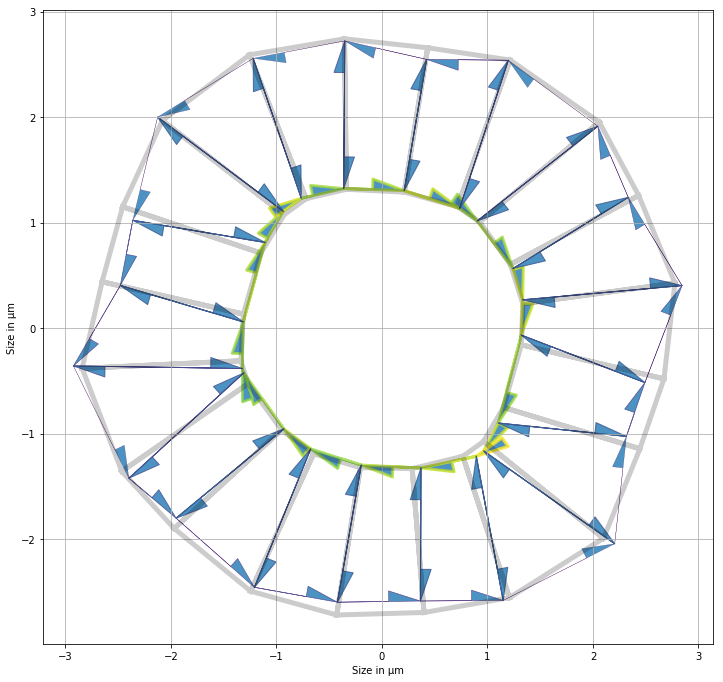

In [33]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas_copy.x[:organo.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = res_2_cst_areas_copy.x[4*organo.Nf:5*organo.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas_copy.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*organo.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo.Nf]))))

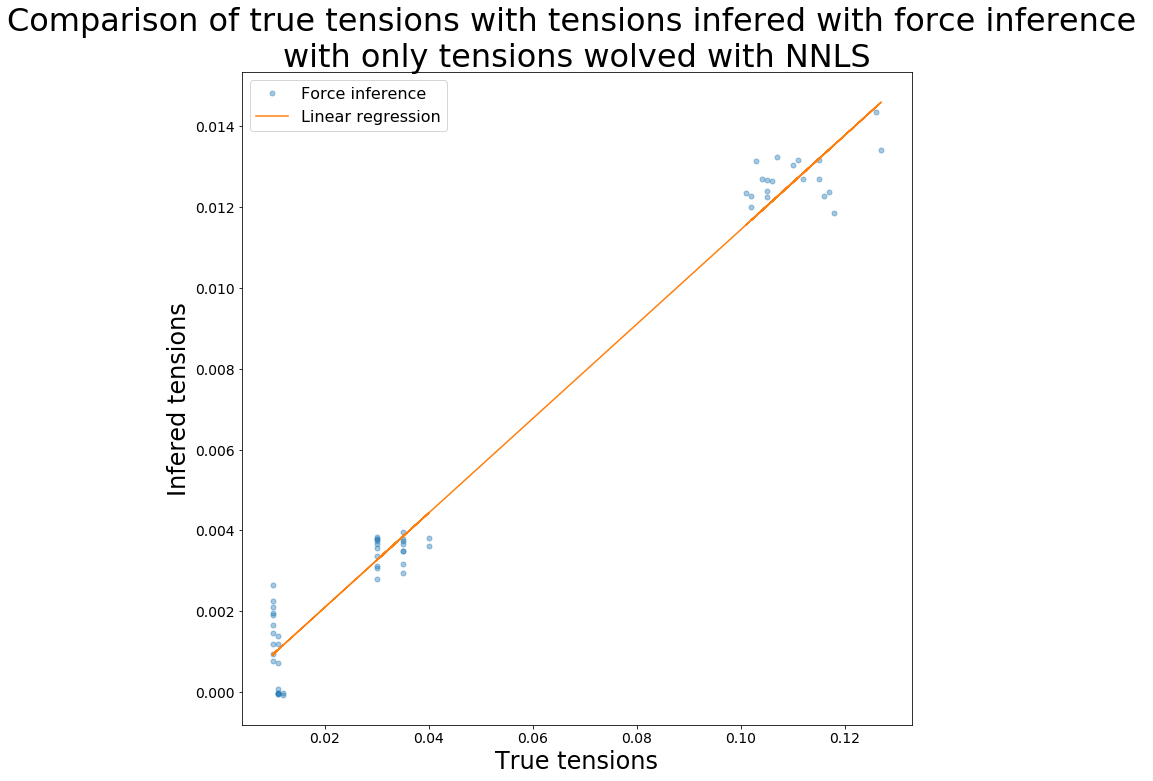

R value : 0.9887570428178261 
Standard error : 0.0006575963503413099


In [32]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  opt_mat_2_cst_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))